In [25]:
!pip install rasterio

In [ ]:
import shutil

#define src and dst paths
src_path = '/content/drive/MyDrive/GEE_Exports/fullscl'
dst_path = '/content/GEE_Exports'

# Copy entire directory tree
shutil.copytree(src_path, dst_path)

In [ ]:
import rasterio
import numpy as np

image_path = '/content/drive/MyDrive/GEE_Exports/fullscl/Images/2020/S2_2020_tile1A.tif'

with rasterio.open(image_path) as src:
    image = src.read()  # (bands, height, width)
    profile = src.profile

    print(f"Image shape (bands, height, width): {image.shape}")
    print(f"Number of bands: {src.count}")
    print(f"Band indexes: {list(range(1, src.count + 1))}")

    # Total number of pixels (all bands combined)
    total_pixels = np.prod(image.shape)

    # Count NaNs
    nan_mask = np.isnan(image)
    nan_pixels = np.count_nonzero(nan_mask)

    # Valid pixels = total - nan
    valid_pixels = total_pixels - nan_pixels

    # Percentage
    if total_pixels > 0:
        nan_percentage = (nan_pixels / total_pixels) * 100
        print(f"NaN pixels: {nan_pixels}")
        print(f"Valid pixels: {valid_pixels}")
        print(f"NaN percentage: {nan_percentage:.4f}%")
    else:
        print(" Error: Image has zero pixels.")

Image shape (bands, height, width): (5, 3772, 6544)
Number of bands: 5
Band indexes: [1, 2, 3, 4, 5]
NaN pixels: 16
Valid pixels: 123419824
 NaN percentage: 0.0000%


In [ ]:
# Create binary vegetation masks based on NDVI values for Sentinel-2 images for the years 2020 and 2021.

import os
import rasterio
import numpy as np
from tqdm import tqdm

def compute_ndvi(image):
    nir = image[3].astype(np.float32)  # Band 8 (NIR)
    red = image[0].astype(np.float32)  # Band 4 (Red)
    ndvi = (nir - red) / (nir + red + 1e-6)
    return ndvi

def save_mask(mask, src, output_path):
    os.makedirs(os.path.dirname(output_path), exist_ok=True)
    with rasterio.open(
        output_path,
        'w',
        driver='GTiff',
        height=mask.shape[0],
        width=mask.shape[1],
        count=1,
        dtype=rasterio.uint8,
        crs=src.crs,
        transform=src.transform
    ) as dst:
        dst.write(mask, 1)

# Input directories
base_img_dir = '/content/GEE_Exports/Images'
years = ['2020', '2021']

# Output directories for masks
base_mask_dir = '/content/GEE_Exports/Masks'

threshold = 0.3

for year in years:
    img_dir = os.path.join(base_img_dir, year)
    mask_dir = os.path.join(base_mask_dir, year)

    print(f'Processing year: {year}')

    tile_files = [f for f in os.listdir(img_dir) if f.endswith('.tif')]

    for tile_file in tqdm(tile_files):
        img_path = os.path.join(img_dir, tile_file)
        with rasterio.open(img_path) as src:
            img = src.read()
            ndvi = compute_ndvi(img)
            mask = (ndvi > threshold).astype(np.uint8)

            mask_output_path = os.path.join(mask_dir, tile_file.replace('.tif', '_mask.tif'))
            save_mask(mask, src, mask_output_path)

Processing year: 2020


100%|██████████| 23/23 [01:58<00:00,  5.14s/it]


Processing year: 2021


100%|██████████| 23/23 [01:55<00:00,  5.04s/it]


In [ ]:
# Split the patches into 256x256 for images and masks and store them;

import os
import rasterio
import numpy as np
from rasterio.windows import Window

# Input Directories
img_2020_dir = '/content/GEE_Exports/Images/2020'
img_2021_dir = '/content/GEE_Exports/Images/2021'
mask_2020_dir = '/content/GEE_Exports/Masks/2020'
mask_2021_dir = '/content/GEE_Exports/Masks/2021'

# Output Base Directory
output_base = '/content/patches'
patch_size = 256

# Output Subdirectories
out_img2020_dir = os.path.join(output_base, 'Images', '2020')
out_img2021_dir = os.path.join(output_base, 'Images', '2021')
out_mask2020_dir = os.path.join(output_base, 'Masks', '2020')
out_mask2021_dir = os.path.join(output_base, 'Masks', '2021')

os.makedirs(out_img2020_dir, exist_ok=True)
os.makedirs(out_img2021_dir, exist_ok=True)
os.makedirs(out_mask2020_dir, exist_ok=True)
os.makedirs(out_mask2021_dir, exist_ok=True)

# Process all 2020 image tiles
img_2020_files = [f for f in os.listdir(img_2020_dir) if f.endswith('.tif')]

for filename in img_2020_files:
    print(f'Processing {filename}...')

    img_2020_path = os.path.join(img_2020_dir, filename)
    img_2021_path = os.path.join(img_2021_dir, filename.replace('2020', '2021'))
    mask_2020_path = os.path.join(mask_2020_dir, filename.replace('.tif', '_mask.tif'))
    mask_2021_path = os.path.join(mask_2021_dir, filename.replace('2020', '2021').replace('.tif', '_mask.tif'))

    if not os.path.exists(img_2020_path):
        print(f'Skipped: 2020 image not found: {img_2020_path}')
        continue
    if not os.path.exists(img_2021_path):
        print(f'Skipped: 2021 image not found: {img_2021_path}')
        continue
    if not os.path.exists(mask_2020_path):
        print(f'Skipped: 2020 mask not found: {mask_2020_path}')
        continue
    if not os.path.exists(mask_2021_path):
        print(f'Skipped: 2021 mask not found: {mask_2021_path}')
        continue

    # Extract tile base name (e.g., "tile1")
    base_name = filename.replace('S2_2020_', '').replace('.tif', '')

    with rasterio.open(img_2020_path) as src_2020, \
         rasterio.open(img_2021_path) as src_2021, \
         rasterio.open(mask_2020_path) as src_mask_2020, \
         rasterio.open(mask_2021_path) as src_mask_2021:

        height, width = src_2020.height, src_2020.width
        n_rows = height // patch_size
        n_cols = width // patch_size

        for i in range(n_rows):
            for j in range(n_cols):
                row_off = i * patch_size
                col_off = j * patch_size
                window = Window(col_off=col_off, row_off=row_off, width=patch_size, height=patch_size)

                patch_2020 = src_2020.read(window=window)
                patch_2021 = src_2021.read(window=window)
                patch_mask_2020 = src_mask_2020.read(1, window=window)
                patch_mask_2021 = src_mask_2021.read(1, window=window)

                patch_id = f"{base_name}_patch_{i}_{j}.tif"

                # Save image patches
                for patch, out_dir, src in [(patch_2020, out_img2020_dir, src_2020),
                                            (patch_2021, out_img2021_dir, src_2021)]:
                    out_path = os.path.join(out_dir, patch_id)
                    meta = src.meta.copy()
                    meta.update({
                        'height': patch_size,
                        'width': patch_size,
                        'count': src.count,
                        'transform': rasterio.windows.transform(window, src.transform)
                    })
                    with rasterio.open(out_path, 'w', **meta) as dst:
                        dst.write(patch)

                # Save mask patches
                for patch_mask, out_mask_dir, src_mask in [
                    (patch_mask_2020, out_mask2020_dir, src_mask_2020),
                    (patch_mask_2021, out_mask2021_dir, src_mask_2021)
                ]:
                    out_mask_path = os.path.join(out_mask_dir, patch_id)
                    meta_mask = src_mask.meta.copy()
                    meta_mask.update({
                        'height': patch_size,
                        'width': patch_size,
                        'count': 1,
                        'dtype': patch_mask.dtype,
                        'transform': rasterio.windows.transform(window, src_mask.transform)
                    })
                    with rasterio.open(out_mask_path, 'w', **meta_mask) as dst:
                        dst.write(patch_mask, 1)

    print(f'Finished processing {filename}')

print("All done! Yearly patches saved in respective folders.")

Processing S2_2020_tile3F.tif...
Finished processing S2_2020_tile3F.tif
Processing S2_2020_tile3D.tif...
Finished processing S2_2020_tile3D.tif
Processing S2_2020_tile5D.tif...
Finished processing S2_2020_tile5D.tif
Processing S2_2020_tile2C.tif...
Finished processing S2_2020_tile2C.tif
Processing S2_2020_tile1A.tif...
Finished processing S2_2020_tile1A.tif
Processing S2_2020_tile3B.tif...
Finished processing S2_2020_tile3B.tif
Processing S2_2020_tile2E.tif...
Finished processing S2_2020_tile2E.tif
Processing S2_2020_tile2A.tif...
Finished processing S2_2020_tile2A.tif
Processing S2_2020_tile3C.tif...
Finished processing S2_2020_tile3C.tif
Processing S2_2020_tile4B.tif...
Finished processing S2_2020_tile4B.tif
Processing S2_2020_tile5B.tif...
Finished processing S2_2020_tile5B.tif
Processing S2_2020_tile5C.tif...
Finished processing S2_2020_tile5C.tif
Processing S2_2020_tile1C.tif...
Finished processing S2_2020_tile1C.tif
Processing S2_2020_tile4A.tif...
Finished processing S2_2020_til

Visualizing patch: tile5B_patch_10_26.tif


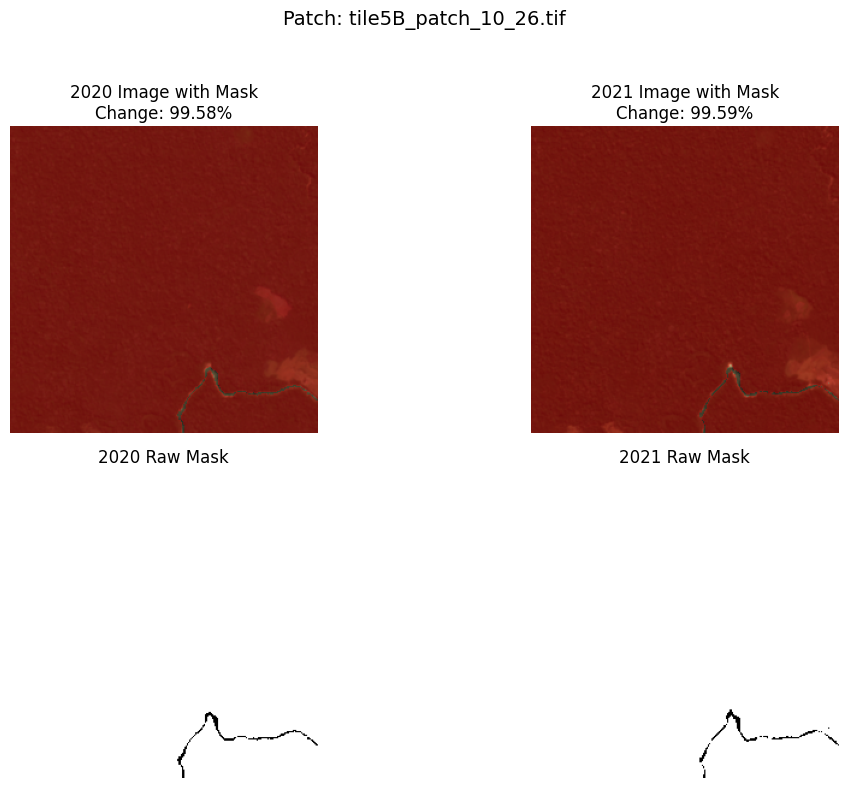

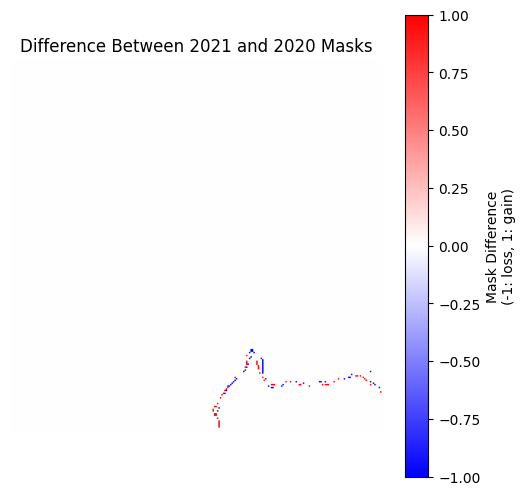

In [ ]:
import os
import rasterio
import numpy as np
import matplotlib.pyplot as plt
import random

# Base patches directory
base_dir = '/content/patches'

# Paths for images and masks
img_2020_dir = os.path.join(base_dir, 'Images', '2020')
img_2021_dir = os.path.join(base_dir, 'Images', '2021')
mask_2020_dir = os.path.join(base_dir, 'Masks', '2020')
mask_2021_dir = os.path.join(base_dir, 'Masks', '2021')

# Get list of patch files from 2020 images folder
patch_files = [f for f in os.listdir(img_2020_dir) if f.endswith('.tif')]

if not patch_files:
    raise FileNotFoundError(f"No .tif files found in {img_2020_dir}")

# Pick one random patch file
patch_file = random.choice(patch_files)
print(f"Visualizing patch: {patch_file}")

# Helper Functions

def load_patch(path):
    with rasterio.open(path) as src:
        return src.read().astype(np.float32)

def normalize_patch(patch, max_val=0.3):
    return np.clip(patch, 0, max_val) / max_val

def overlay_mask_on_rgb(rgb, mask, alpha=0.4, color=(1, 0, 0)):
    """Overlay a binary mask on an RGB image."""
    overlay = rgb.copy()
    mask_bool = mask.astype(bool)
    for c in range(3):
        overlay[:, :, c] = np.where(mask_bool,
                                    alpha * color[c] + (1 - alpha) * rgb[:, :, c],
                                    rgb[:, :, c])
    return overlay

# Load Data

patch_2020 = load_patch(os.path.join(img_2020_dir, patch_file))
patch_2021 = load_patch(os.path.join(img_2021_dir, patch_file))
mask_2020 = load_patch(os.path.join(mask_2020_dir, patch_file))[0]  # single band
mask_2021 = load_patch(os.path.join(mask_2021_dir, patch_file))[0]

# Normalize and Overlay

patch_2020_rgb = np.transpose(normalize_patch(patch_2020[:3]), (1, 2, 0))
patch_2021_rgb = np.transpose(normalize_patch(patch_2021[:3]), (1, 2, 0))

overlay_2020 = overlay_mask_on_rgb(patch_2020_rgb, mask_2020)
overlay_2021 = overlay_mask_on_rgb(patch_2021_rgb, mask_2021)

# Calculate Statistics

total_pixels = mask_2020.size
percent_change_2020 = 100 * np.sum(mask_2020 == 1) / total_pixels
percent_change_2021 = 100 * np.sum(mask_2021 == 1) / total_pixels
mask_diff = mask_2021.astype(int) - mask_2020.astype(int)

# Plot

plt.figure(figsize=(12, 8))
plt.suptitle(f'Patch: {patch_file}', fontsize=14)

plt.subplot(2, 2, 1)
plt.imshow(overlay_2020)
plt.title(f'2020 Image with Mask\nChange: {percent_change_2020:.2f}%')
plt.axis('off')

plt.subplot(2, 2, 2)
plt.imshow(overlay_2021)
plt.title(f'2021 Image with Mask\nChange: {percent_change_2021:.2f}%')
plt.axis('off')

plt.subplot(2, 2, 3)
plt.imshow(mask_2020, cmap='gray')
plt.title('2020 Raw Mask')
plt.axis('off')

plt.subplot(2, 2, 4)
plt.imshow(mask_2021, cmap='gray')
plt.title('2021 Raw Mask')
plt.axis('off')

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# Difference Mask

plt.figure(figsize=(6, 6))
plt.imshow(mask_diff, cmap='bwr', vmin=-1, vmax=1)
plt.colorbar(label='Mask Difference\n(-1: loss, 1: gain)')
plt.title('Difference Between 2021 and 2020 Masks')
plt.axis('off')
plt.show()

In [ ]:
import os

def count_all_patch_files(base_dir):
    """
    Counts the number of .tif files  in each [Images|Masks]/[2020|2021] subfolder.
    """
    for category in ['Images', 'Masks']:
        print(f"\n Category: {category}")
        for year in ['2020', '2021']:
            folder_path = os.path.join(base_dir, category, year)
            if not os.path.isdir(folder_path):
                print(f"❗ Directory not found: {folder_path}")
                continue

            num_files = len([
                f for f in os.listdir(folder_path)
                if os.path.isfile(os.path.join(folder_path, f)) and f.endswith('.tif')
            ])
            print(f" {year}: {num_files} patch files")

count_all_patch_files("/content/patches")


 Category: Images
 2020: 6520 patch files
 2021: 6520 patch files

 Category: Masks
 2020: 6520 patch files
 2021: 6520 patch files


In [ ]:
import os
import rasterio
import numpy as np

def rotate_and_save(image, rotation_deg):
    """Rotates image by specified degree (90 or 180)."""
    if rotation_deg == 90:
        return np.rot90(image, k=1, axes=(1, 2)) if image.ndim == 3 else np.rot90(image)
    elif rotation_deg == 180:
        return np.rot90(image, k=2, axes=(1, 2)) if image.ndim == 3 else np.rot90(image, k=2)
    else:
        raise ValueError("Only 90 and 180 degrees are supported.")

def augment_folder(folder_path):
    for file in os.listdir(folder_path):
        if not file.endswith('.tif') or any(rot in file for rot in ['_rot90', '_rot180']):
            continue  # Skip augmented files

        full_path = os.path.join(folder_path, file)
        with rasterio.open(full_path) as src:
            data = src.read()
            meta = src.meta.copy()
            is_mask = (data.shape[0] == 1)

            for angle in [90, 180]:
                rotated = rotate_and_save(data, angle)

                # For masks, drop band dimension
                if is_mask:
                    rotated = rotated[0]
                    meta.update(count=1)
                else:
                    meta.update(count=data.shape[0])

                out_name = file.replace('.tif', f'_rot{angle}.tif')
                out_path = os.path.join(folder_path, out_name)
                with rasterio.open(out_path, 'w', **meta) as dst:
                    if is_mask:
                        dst.write(rotated, 1)
                    else:
                        dst.write(rotated)

                print(f" Saved: {out_name}")

# Paths
base_dir = "/content/patches"
subfolders = [
    os.path.join(base_dir, 'Images', '2020'),
    os.path.join(base_dir, 'Images', '2021'),
    os.path.join(base_dir, 'Masks', '2020'),
    os.path.join(base_dir, 'Masks', '2021'),
]

# Run augmentation
for folder in subfolders:
    print(f"\n Augmenting folder: {folder}")
    augment_folder(folder)

print("\n Done! Rotated images saved in the same folders.")

Streaming output truncated to the last 5000 lines.
 Saved: tile3A-0000000000-0000000000_patch_8_21_rot90.tif
 Saved: tile3A-0000000000-0000000000_patch_8_21_rot180.tif
 Saved: tile3A-0000000000-0000014848_patch_2_2_rot90.tif
 Saved: tile3A-0000000000-0000014848_patch_2_2_rot180.tif
 Saved: tile2F_patch_3_21_rot90.tif
 Saved: tile2F_patch_3_21_rot180.tif
 Saved: tile2C_patch_12_2_rot90.tif
 Saved: tile2C_patch_12_2_rot180.tif
 Saved: tile3A-0000000000-0000000000_patch_7_1_rot90.tif
 Saved: tile3A-0000000000-0000000000_patch_7_1_rot180.tif
 Saved: tile5B_patch_9_20_rot90.tif
 Saved: tile5B_patch_9_20_rot180.tif
 Saved: tile1B_patch_13_5_rot90.tif
 Saved: tile1B_patch_13_5_rot180.tif
 Saved: tile1C_patch_2_10_rot90.tif
 Saved: tile1C_patch_2_10_rot180.tif
 Saved: tile3A-0000000000-0000000000_patch_9_34_rot90.tif
 Saved: tile3A-0000000000-0000000000_patch_9_34_rot180.tif
 Saved: tile3A-0000000000-0000000000_patch_6_56_rot90.tif
 Saved: tile3A-0000000000-0000000000_patch_6_56_rot180.tif
 Sa

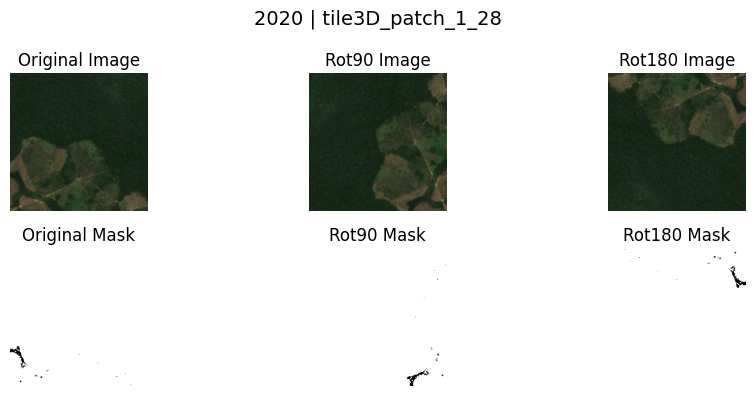

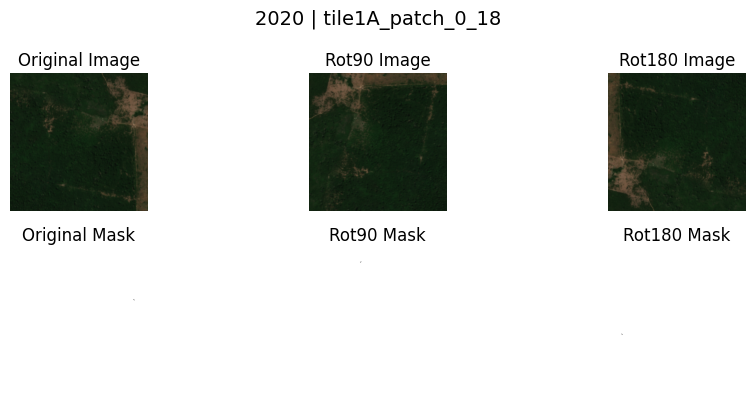

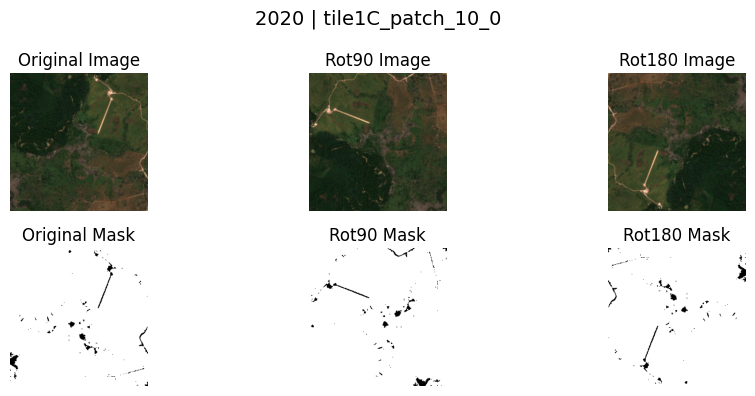

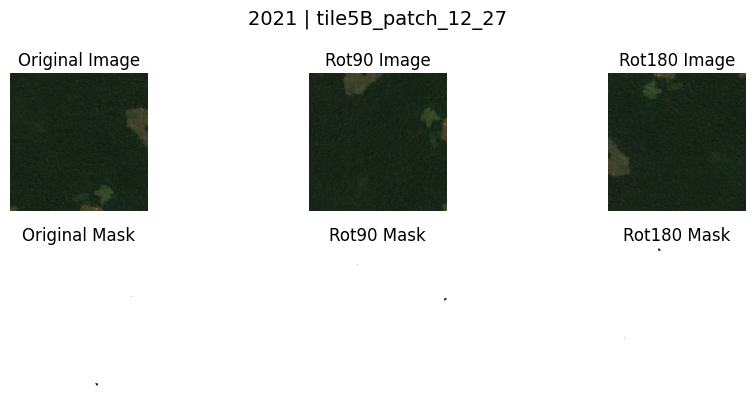

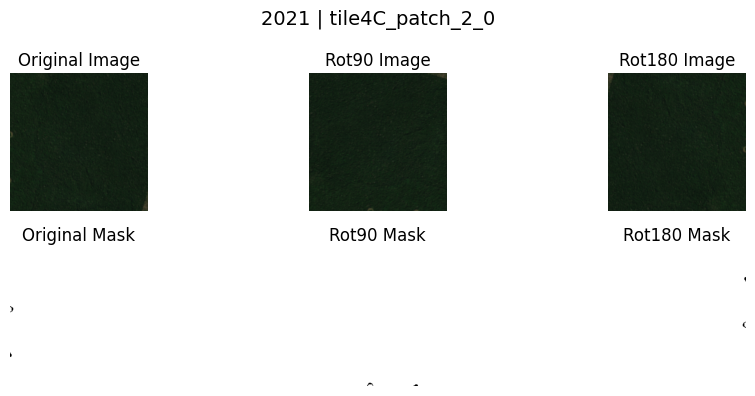

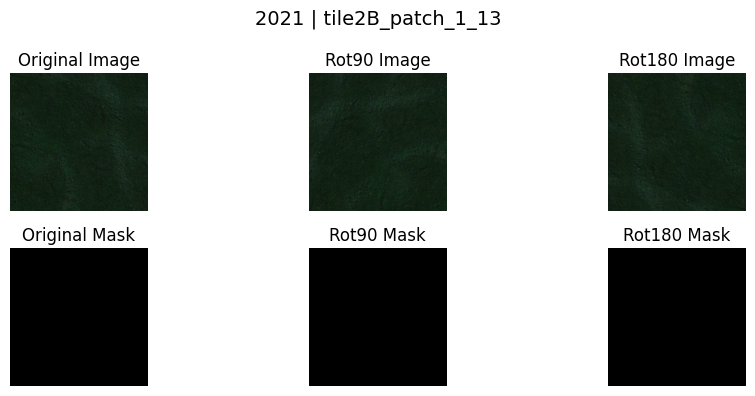

In [ ]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import rasterio

base_dir = '/content/patches'
years = ['2020', '2021']

def load_tif(path):
    with rasterio.open(path) as src:
        img = src.read()
    return np.transpose(img[:3], (1, 2, 0)) if img.shape[0] >= 3 else img[0]

def visualize_with_rotations(year, n=3):
    img_dir = os.path.join(base_dir, 'Images', year)
    mask_dir = os.path.join(base_dir, 'Masks', year)

    # Select only original (non-rotated) image files
    img_files = [f for f in os.listdir(img_dir) if f.endswith('.tif') and '_rot' not in f]
    if not img_files:
        print(f"[{year}] No original image patches found.")
        return

    sample_files = random.sample(img_files, min(n, len(img_files)))

    for fname in sample_files:
        base_name = fname.replace('.tif', '')

        variants = {
            'Original': (f"{base_name}.tif", f"{base_name}.tif"),
            'Rot90': (f"{base_name}_rot90.tif", f"{base_name}_rot90.tif"),
            'Rot180': (f"{base_name}_rot180.tif", f"{base_name}_rot180.tif")
        }

        plt.figure(figsize=(10, 4))
        plt.suptitle(f"{year} | {base_name}", fontsize=14)

        for i, (label, (img_name, mask_name)) in enumerate(variants.items()):
            img_path = os.path.join(img_dir, img_name)
            mask_path = os.path.join(mask_dir, mask_name)

            if not (os.path.exists(img_path) and os.path.exists(mask_path)):
                print(f" Skipping missing pair: {img_name}, {mask_name}")
                continue

            img = load_tif(img_path)
            mask = load_tif(mask_path)

            # Plot image
            plt.subplot(2, 3, i + 1)
            plt.imshow(np.clip(img, 0, 0.3) / 0.3)  # Normalize for visualization
            plt.title(f"{label} Image")
            plt.axis('off')

            # Plot mask
            plt.subplot(2, 3, i + 4)
            plt.imshow(mask, cmap='gray')
            plt.title(f"{label} Mask")
            plt.axis('off')

        plt.tight_layout()
        plt.show()

# Run for each year
for yr in years:
    visualize_with_rotations(yr, n=3)

In [ ]:
import os
import random
import shutil
import rasterio
from collections import defaultdict
from tqdm import tqdm

# Paths
base_patch_dir = '/content/patches/'
image_2020_dir = os.path.join(base_patch_dir, 'Images', '2020')
image_2021_dir = os.path.join(base_patch_dir, 'Images', '2021')
mask_dir = os.path.join(base_patch_dir, 'Masks', '2020')

output_dir = '/content/bitemporal_stratified_split'
split_ratios = {'train': 0.6, 'val': 0.2, 'test': 0.2}

# Step 1: Compute change percentages for all masks
def compute_change_percentage(mask_path):
    with rasterio.open(mask_path) as src:
        mask = src.read(1)
        total_pixels = mask.size
        changed_pixels = (mask > 0).sum()
        return (changed_pixels / total_pixels) * 100

print("Computing change percentages for masks...")
change_stats = {}

# Your mask filenames are like tile1A_patch_0_0.tif (no _mask suffix)
for mask_file in tqdm(os.listdir(mask_dir)):
    if not mask_file.endswith('.tif'):
        continue
    mask_path = os.path.join(mask_dir, mask_file)
    base_name = mask_file[:-4]  # remove '.tif' extension

    try:
        change_percent = compute_change_percentage(mask_path)
        change_stats[base_name] = change_percent
    except Exception as e:
        print(f"Error reading {mask_file}: {e}")

print(f"Computed change percentage for {len(change_stats)} patches.")

# Step 2: Stratify patches by change amount
bins = {'low': [], 'medium': [], 'high': []}
for patch_name, percent in change_stats.items():
    if percent > 30:
        bins['high'].append(patch_name)
    elif percent > 10:
        bins['medium'].append(patch_name)
    else:
        bins['low'].append(patch_name)

print("Number of patches by change level:")
for level in bins:
    print(f"  {level}: {len(bins[level])}")

# Step 3: Stratified splitting
splits = defaultdict(list)
for level, patch_list in bins.items():
    random.shuffle(patch_list)
    n = len(patch_list)
    n_train = int(n * split_ratios['train'])
    n_val = int(n * split_ratios['val'])
    n_test = n - n_train - n_val

    splits['train'].extend(patch_list[:n_train])
    splits['val'].extend(patch_list[n_train:n_train+n_val])
    splits['test'].extend(patch_list[n_train+n_val:])

print("\nSplit counts:")
for split_name in ['train', 'val', 'test']:
    print(f"  {split_name}: {len(splits[split_name])}")

# Step 4: Copy files to output folders
def copy_triplet(patch_name, split_name):
    # Compose filenames
    f_2020 = patch_name + '.tif'
    f_2021 = patch_name.replace('2020', '2021') + '.tif'
    f_mask = patch_name + '.tif'  # masks have same filename as 2020 image, just different folder

    # Source paths
    src_2020 = os.path.join(image_2020_dir, f_2020)
    src_2021 = os.path.join(image_2021_dir, f_2021)
    src_mask = os.path.join(mask_dir, f_mask)

    # Destination dirs
    dst_2020_dir = os.path.join(output_dir, split_name, 'image_2020')
    dst_2021_dir = os.path.join(output_dir, split_name, 'image_2021')
    dst_mask_dir = os.path.join(output_dir, split_name, 'mask')

    # Make sure output dirs exist
    os.makedirs(dst_2020_dir, exist_ok=True)
    os.makedirs(dst_2021_dir, exist_ok=True)
    os.makedirs(dst_mask_dir, exist_ok=True)

    # Copy files if all exist
    if all(os.path.exists(p) for p in [src_2020, src_2021, src_mask]):
        shutil.copy2(src_2020, os.path.join(dst_2020_dir, f_2020))
        shutil.copy2(src_2021, os.path.join(dst_2021_dir, f_2021))
        shutil.copy2(src_mask, os.path.join(dst_mask_dir, f_mask))
    else:
        print(f"Warning: Missing files for patch {patch_name}, skipping.")

print("\nCopying files to output folders...")
for split_name in ['train', 'val', 'test']:
    print(f"  Copying {split_name} set ({len(splits[split_name])} patches)...")
    for patch_name in tqdm(splits[split_name]):
        copy_triplet(patch_name, split_name)

print("\n Stratified bitemporal dataset split complete!")

Computing change percentages for masks...


100%|██████████| 19560/19560 [00:30<00:00, 634.87it/s]


Computed change percentage for 19560 patches.
Number of patches by change level:
  low: 0
  medium: 0
  high: 19560

Split counts:
  train: 11736
  val: 3912
  test: 3912

Copying files to output folders...
  Copying train set (11736 patches)...


100%|██████████| 11736/11736 [06:59<00:00, 27.98it/s]


  Copying val set (3912 patches)...


100%|██████████| 3912/3912 [02:15<00:00, 28.78it/s]


  Copying test set (3912 patches)...


100%|██████████| 3912/3912 [02:14<00:00, 29.06it/s]


 Stratified bitemporal dataset split complete!


In [27]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from timm.models.vision_transformer import VisionTransformer

class FeatureDifferenceModule(nn.Module):
    """Computes feature differences using absolute difference and Conv2D."""
    def __init__(self, in_channels):
        super(FeatureDifferenceModule, self).__init__()
        self.conv = nn.Conv2d(in_channels, in_channels // 2, kernel_size=3, padding=1)  # Reduced channels
        self.bn = nn.BatchNorm2d(in_channels // 2)
        self.relu = nn.ReLU()

    def forward(self, feat1, feat2):
        x = torch.abs(feat1 - feat2)  # Absolute difference
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        return x

class DeconvDecoder(nn.Module):
    """Deconvolution-based decoder for better spatial reconstruction."""
    def __init__(self, in_channels, num_classes):
        super(DeconvDecoder, self).__init__()
        self.deconv1 = nn.ConvTranspose2d(in_channels // 2, 128, kernel_size=3, stride=2, padding=1, output_padding=1)  # Reduced channels
        self.deconv2 = nn.ConvTranspose2d(128, 32, kernel_size=3, stride=2, padding=1, output_padding=1)  # Reduced channels
        self.deconv3 = nn.ConvTranspose2d(32, num_classes, kernel_size=3, stride=2, padding=1, output_padding=1)

    def forward(self, x):
        x = F.relu(self.deconv1(x))
        x = F.relu(self.deconv2(x))
        x = self.deconv3(x)
        return x

class ChangeFormer(nn.Module):
    """Transformer-based Change Detection Model with shared encoder."""
    def __init__(self, img_size=256, num_classes=1):
        super(ChangeFormer, self).__init__()
        self.encoder = VisionTransformer(
            img_size=img_size,
            patch_size=16,
            embed_dim=384,
            depth=4,
            num_heads=6,
            in_chans=4,
        )

        self.feature_diff = FeatureDifferenceModule(in_channels=384)
        self.decoder = DeconvDecoder(in_channels=384, num_classes=num_classes)
        self.img_size = img_size
        self.patch_size = 16

    def forward(self, img1, img2):
        # Extract features using a shared encoder
        feat1 = self.encoder.forward_features(img1)  # (B, num_tokens, embed_dim)
        feat2 = self.encoder.forward_features(img2)

        # Remove the class token
        feat1 = feat1[:, 1:, :]
        feat2 = feat2[:, 1:, :]

        # Compute spatial dimensions
        B, N, C = feat1.shape
        h = w = self.img_size // self.patch_size

        # Reshape tokens into spatial feature maps: (B, C, h, w)
        feat1 = feat1.transpose(1, 2).view(B, C, h, w)
        feat2 = feat2.transpose(1, 2).view(B, C, h, w)

        # Compute feature difference
        diff = self.feature_diff(feat1, feat2)

        # Decode feature differences into segmentation map
        out = self.decoder(diff)

        # Upsample to original image size
        out = F.interpolate(out, size=(self.img_size, self.img_size), mode='bilinear', align_corners=False)

        return out

# Model Initialization
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ChangeFormer(num_classes=1).to(device)
print(" ChangeFormer Model Initialized!")

 ChangeFormer Model Initialized!


In [ ]:
import os
import torch
from torch.utils.data import Dataset
import numpy as np
import re
import rasterio

class ChangeDetectionDataset(Dataset):
    def __init__(self, root_dir, split, transform=None):
        self.transform = transform
        self.samples = []

        img_dir_2020 = os.path.join(root_dir, split, 'image_2020')
        img_dir_2021 = os.path.join(root_dir, split, 'image_2021')
        mask_dir = os.path.join(root_dir, split, 'mask')

        def list_tif_files(folder):
            return sorted([f for f in os.listdir(folder) if f.endswith('.tif')])

        image_files_2020 = list_tif_files(img_dir_2020)
        image_files_2021 = list_tif_files(img_dir_2021)
        mask_files = list_tif_files(mask_dir)

        def get_patch_key(filename):
            # Remove year prefix, mask suffix, and extension to get base patch key
            key = re.sub(r'(S2_20\d{2}_|_mask|\.tif)', '', filename)
            return key

        img20_dict = {get_patch_key(f): f for f in image_files_2020}
        img21_dict = {get_patch_key(f): f for f in image_files_2021}
        mask_dict = {get_patch_key(f): f for f in mask_files}

        common_keys = set(img20_dict) & set(img21_dict) & set(mask_dict)

        print(f"[{split.upper()}] Found {len(common_keys)} matching samples")

        for key in sorted(common_keys):
            self.samples.append((
                os.path.join(img_dir_2020, img20_dict[key]),
                os.path.join(img_dir_2021, img21_dict[key]),
                os.path.join(mask_dir, mask_dict[key]),
            ))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path_2020, img_path_2021, mask_path = self.samples[idx]

        try:
            with rasterio.open(img_path_2020) as src:
                image_2020 = src.read().astype(np.float32)
            with rasterio.open(img_path_2021) as src:
                image_2021 = src.read().astype(np.float32)
            with rasterio.open(mask_path) as src:
                mask = src.read(1).astype(np.uint8)
        except Exception as e:
            raise RuntimeError(f"Error reading files for index {idx}: {e}")

        # Keep only first 4 channels (e.g., RGB + NIR)
        image_2020 = image_2020[:4, :, :]
        image_2021 = image_2021[:4, :, :]

        # Handle NaNs and infs gracefully
        image_2020 = np.nan_to_num(image_2020, nan=0.0, posinf=1.0, neginf=0.0)
        image_2021 = np.nan_to_num(image_2021, nan=0.0, posinf=1.0, neginf=0.0)

        # Normalize images to [0,1]
        image_2020 /= (image_2020.max() + 1e-6)
        image_2021 /= (image_2021.max() + 1e-6)

        image_2020 = np.clip(image_2020, 0.0, 1.0)
        image_2021 = np.clip(image_2021, 0.0, 1.0)

        # Add channel dimension to mask
        mask = np.expand_dims(mask, axis=0)

        if self.transform:
            image_2020 = self.transform(image_2020)
            image_2021 = self.transform(image_2021)
            mask = self.transform(mask)

        return (
            torch.from_numpy(image_2020).float(),
            torch.from_numpy(image_2021).float(),
            torch.from_numpy(mask).float()
        )

In [ ]:
from torch.utils.data import DataLoader

base_dir = "/content/bitemporal_stratified_split"

train_dataset = ChangeDetectionDataset(root_dir=base_dir, split='train')
val_dataset = ChangeDetectionDataset(root_dir=base_dir, split='val')

train_loader = DataLoader(
    train_dataset,
    batch_size=16,
    shuffle=True,
    num_workers=2,
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=16,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

print(f"Dataloaders ready! Train samples: {len(train_dataset)}, Val samples: {len(val_dataset)}")

[TRAIN] Found 11736 matching samples
[VAL] Found 3912 matching samples
Dataloaders ready! Train samples: 11736, Val samples: 3912


[TRAIN] Found 11736 matching samples


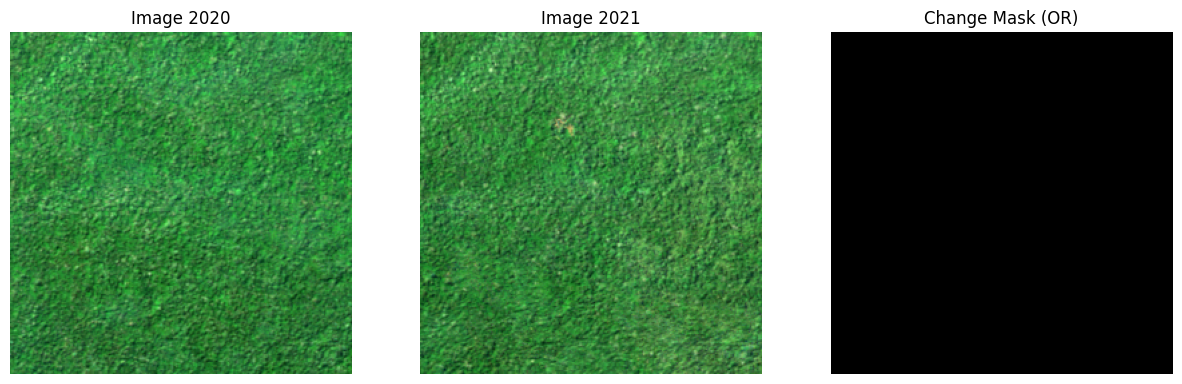

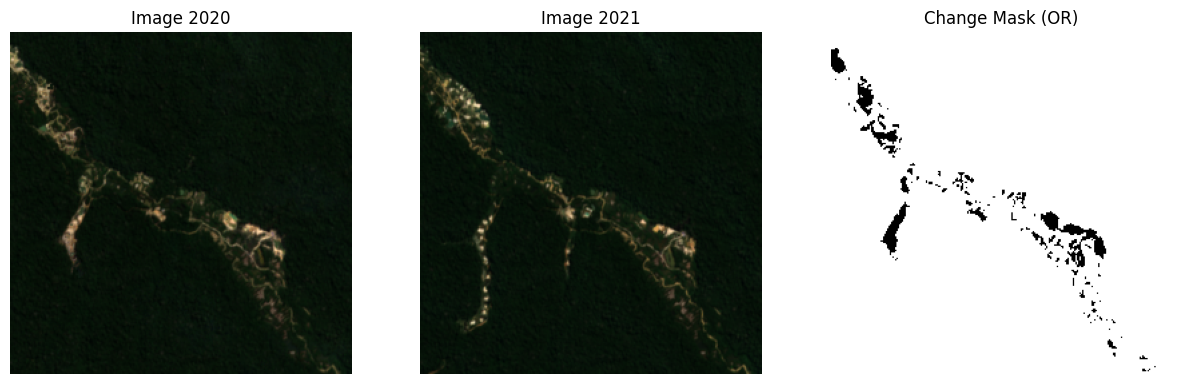

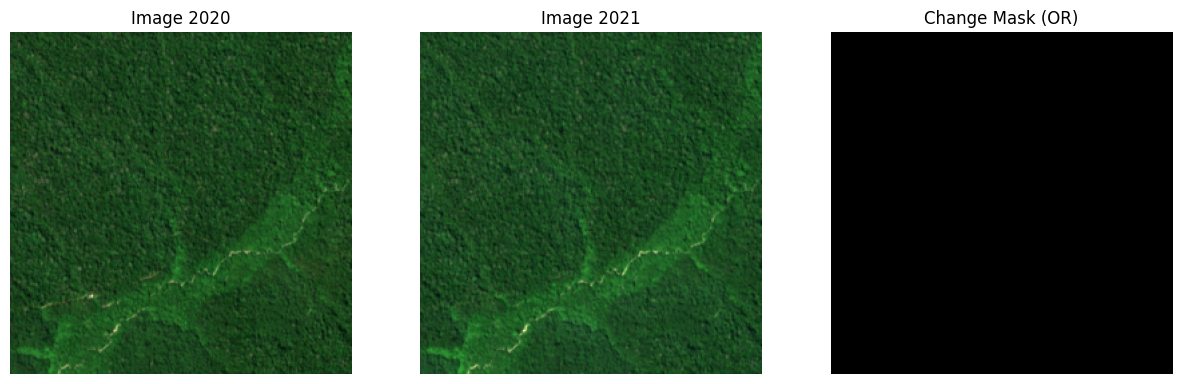

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import random

# Use your existing dataset instance
dataset = ChangeDetectionDataset(root_dir="/content/bitemporal_stratified_split", split='train')

def plot_sample(idx):
    img1, img2, mask = dataset[idx]

    # Convert tensors to numpy arrays
    img1 = img1.numpy()
    img2 = img2.numpy()
    mask = mask.numpy()

    # img shape: (channels, height, width)
    def to_rgb(img):
        if img.shape[0] >= 3:
            rgb = img[:3, :, :]
        else:
            rgb = np.repeat(img, 3, axis=0)
        rgb_min = rgb.min()
        rgb_max = rgb.max()
        rgb = (rgb - rgb_min) / (rgb_max - rgb_min + 1e-7)
        rgb = np.transpose(rgb, (1, 2, 0))  # HWC
        return rgb

    rgb1 = to_rgb(img1)
    rgb2 = to_rgb(img2)
    mask_img = mask.squeeze()

    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    axs[0].imshow(rgb1)
    axs[0].set_title("Image 2020")
    axs[0].axis('off')

    axs[1].imshow(rgb2)
    axs[1].set_title("Image 2021")
    axs[1].axis('off')

    axs[2].imshow(mask_img, cmap='gray')
    axs[2].set_title("Change Mask (OR)")
    axs[2].axis('off')

    plt.show()

# Visualize 3 random samples
random_indices = random.sample(range(len(dataset)), 3)
for idx in random_indices:
    plot_sample(idx)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Focal Loss with clamping
class FocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2.0, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        # Clamp logits to prevent extreme values that cause NaNs in sigmoid
        inputs = torch.clamp(inputs, min=-20, max=20)

        # BCE with logits (no need to sigmoid first)
        BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
        probs = torch.sigmoid(inputs).clamp(min=1e-7, max=1 - 1e-7)

        # Compute focal loss factor
        focal_factor = self.alpha * (1 - probs) ** self.gamma * targets + \
                       (1 - self.alpha) * probs ** self.gamma * (1 - targets)
        loss = focal_factor * BCE_loss

        if self.reduction == 'mean':
            return loss.mean()
        elif self.reduction == 'sum':
            return loss.sum()
        else:
            return loss

# Dice Loss for segmentation with batch safety
class DiceLoss(nn.Module):
    def __init__(self):
        super(DiceLoss, self).__init__()

    def forward(self, preds, targets, smooth=1):
        preds = torch.sigmoid(preds).clamp(min=1e-7, max=1 - 1e-7)
        preds = preds.flatten(start_dim=1)
        targets = targets.flatten(start_dim=1)
        intersection = (preds * targets).sum(dim=1)
        dice = (2. * intersection + smooth) / (preds.sum(dim=1) + targets.sum(dim=1) + smooth)
        return 1 - dice.mean()

# Combined Dice + Focal Loss
class CombinedLoss(nn.Module):
    def __init__(self, alpha=0.5, focal_alpha=0.25, focal_gamma=2.0):
        super(CombinedLoss, self).__init__()
        self.dice = DiceLoss()
        self.focal = FocalLoss(alpha=focal_alpha, gamma=focal_gamma)
        self.alpha = alpha  # Weight for Dice loss

    def forward(self, preds, targets):
        loss_dice = self.dice(preds, targets)
        loss_focal = self.focal(preds, targets)
        return self.alpha * loss_dice + (1 - self.alpha) * loss_focal

print("Training Components Ready!")

Training Components Ready!


In [ ]:
import torch
from tqdm import tqdm
import numpy as np

#METRIC FUNCTIONS
def compute_metrics(preds, targets, threshold=0.5, epsilon=1e-7):
    preds = (torch.sigmoid(preds) > threshold).float()

    TP = (preds * targets).sum().item()
    FP = ((preds == 1) & (targets == 0)).sum().item()
    FN = ((preds == 0) & (targets == 1)).sum().item()

    precision = TP / (TP + FP + epsilon)
    recall = TP / (TP + FN + epsilon)
    f1 = 2 * precision * recall / (precision + recall + epsilon)
    iou = TP / (TP + FP + FN + epsilon)

    return precision, recall, f1, iou

# MAIN TRAINING LOOP
def train_model(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    scheduler=None,
    num_epochs=20,
    device='cuda',
    skip_empty_masks=True,
    print_freq=10
):
    best_val_loss = float('inf')

    for epoch in range(num_epochs):
        print(f"\n Epoch {epoch+1}/{num_epochs}")
        model.train()
        train_loss, train_metrics = [], []

        for i, (img1, img2, mask) in enumerate(tqdm(train_loader, desc="Training")):
            img1, img2, mask = img1.to(device), img2.to(device), mask.to(device)

            if skip_empty_masks and mask.sum().item() == 0:  # fix here
                continue

            optimizer.zero_grad()
            outputs = model(img1, img2)
            loss = criterion(outputs, mask)
            loss.backward()
            optimizer.step()

            train_loss.append(loss.item())
            train_metrics.append(compute_metrics(outputs.detach(), mask))

            if i % print_freq == 0:
                print(f"Batch {i} Loss: {loss.item():.4f} | Output Range: [{outputs.min().item():.3f}, {outputs.max().item():.3f}]")

        avg_train_loss = np.mean(train_loss)
        avg_train_metrics = np.mean(train_metrics, axis=0)
        print(f"Train Loss: {avg_train_loss:.4f} | "
              f"Precision: {avg_train_metrics[0]:.4f} | Recall: {avg_train_metrics[1]:.4f} | "
              f"F1: {avg_train_metrics[2]:.4f} | IoU: {avg_train_metrics[3]:.4f}")

        model.eval()
        val_loss, val_metrics = [], []

        with torch.no_grad():
            for img1, img2, mask in tqdm(val_loader, desc="Validating"):
                img1, img2, mask = img1.to(device), img2.to(device), mask.to(device)

                outputs = model(img1, img2)
                loss = criterion(outputs, mask)

                val_loss.append(loss.item())
                val_metrics.append(compute_metrics(outputs, mask))

        avg_val_loss = np.mean(val_loss)
        avg_val_metrics = np.mean(val_metrics, axis=0)

        print(f"Val Loss: {avg_val_loss:.4f} | "
              f"Precision: {avg_val_metrics[0]:.4f} | Recall: {avg_val_metrics[1]:.4f} | "
              f"F1: {avg_val_metrics[2]:.4f} | IoU: {avg_val_metrics[3]:.4f}")

        if scheduler:
            scheduler.step(avg_val_loss)

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), "best_model.pth")
            print(" Best model saved!")

    print(" Training Complete!")

In [ ]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize model
model = ChangeFormer(num_classes=1).to(device)

# Define loss
criterion = CombinedLoss(alpha=0.5, focal_alpha=0.25, focal_gamma=2.0)

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# Optional scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

# Start training
train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    num_epochs=20,
    device=device,
    skip_empty_masks=True
)


🔁 Epoch 1/20


Training:   0%|          | 1/773 [00:04<55:43,  4.33s/it]

Batch 0 Loss: 0.2142 | Output Range: [-0.830, 0.325]


Training:   1%|▏         | 11/773 [00:06<04:20,  2.92it/s]

Batch 10 Loss: 0.1946 | Output Range: [-0.546, 1.469]


Training:   3%|▎         | 21/773 [00:10<04:12,  2.97it/s]

Batch 20 Loss: 0.1783 | Output Range: [-0.652, 4.270]


Training:   4%|▍         | 31/773 [00:14<04:12,  2.94it/s]

Batch 30 Loss: 0.1524 | Output Range: [-0.439, 5.055]


Training:   5%|▌         | 41/773 [00:18<05:22,  2.27it/s]

Batch 40 Loss: 0.1173 | Output Range: [-0.541, 6.331]


Training:   7%|▋         | 51/773 [00:22<04:05,  2.94it/s]

Batch 50 Loss: 0.0986 | Output Range: [-0.460, 14.826]


Training:   8%|▊         | 61/773 [00:25<04:08,  2.87it/s]

Batch 60 Loss: 0.0635 | Output Range: [-0.730, 10.358]


Training:   9%|▉         | 71/773 [00:29<04:40,  2.50it/s]

Batch 70 Loss: 0.0485 | Output Range: [-0.569, 11.994]


Training:  10%|█         | 81/773 [00:33<04:16,  2.70it/s]

Batch 80 Loss: 0.0478 | Output Range: [-0.581, 14.455]


Training:  12%|█▏        | 91/773 [00:37<03:59,  2.85it/s]

Batch 90 Loss: 0.0412 | Output Range: [-0.469, 14.282]


Training:  13%|█▎        | 101/773 [00:40<03:56,  2.84it/s]

Batch 100 Loss: 0.0254 | Output Range: [-0.279, 16.481]


Training:  14%|█▍        | 111/773 [00:45<04:59,  2.21it/s]

Batch 110 Loss: 0.0259 | Output Range: [-0.141, 17.006]


Training:  16%|█▌        | 121/773 [00:49<04:21,  2.50it/s]

Batch 120 Loss: 0.0182 | Output Range: [-0.129, 18.126]


Training:  17%|█▋        | 131/773 [00:52<04:01,  2.66it/s]

Batch 130 Loss: 0.0300 | Output Range: [-0.071, 25.273]


Training:  18%|█▊        | 141/773 [00:56<03:40,  2.87it/s]

Batch 140 Loss: 0.0133 | Output Range: [-0.103, 22.267]


Training:  20%|█▉        | 151/773 [01:00<04:38,  2.23it/s]

Batch 150 Loss: 0.0235 | Output Range: [-0.082, 29.692]


Training:  21%|██        | 161/773 [01:04<03:34,  2.86it/s]

Batch 160 Loss: 0.0102 | Output Range: [-0.069, 23.193]


Training:  22%|██▏       | 171/773 [01:07<03:21,  2.99it/s]

Batch 170 Loss: 0.0183 | Output Range: [-0.116, 28.195]


Training:  23%|██▎       | 181/773 [01:11<03:21,  2.93it/s]

Batch 180 Loss: 0.0135 | Output Range: [-0.114, 21.652]


Training:  25%|██▍       | 191/773 [01:15<04:07,  2.35it/s]

Batch 190 Loss: 0.0065 | Output Range: [-0.090, 27.033]


Training:  26%|██▌       | 201/773 [01:19<03:22,  2.82it/s]

Batch 200 Loss: 0.0132 | Output Range: [-0.126, 26.374]


Training:  27%|██▋       | 211/773 [01:22<03:12,  2.92it/s]

Batch 210 Loss: 0.0096 | Output Range: [-0.128, 23.319]


Training:  29%|██▊       | 221/773 [01:26<03:54,  2.35it/s]

Batch 220 Loss: 0.0104 | Output Range: [-0.092, 24.382]


Training:  30%|██▉       | 231/773 [01:30<03:15,  2.78it/s]

Batch 230 Loss: 0.0070 | Output Range: [-0.116, 25.978]


Training:  31%|███       | 241/773 [01:34<02:56,  3.01it/s]

Batch 240 Loss: 0.0089 | Output Range: [-0.068, 35.873]


Training:  32%|███▏      | 251/773 [01:37<02:52,  3.02it/s]

Batch 250 Loss: 0.0129 | Output Range: [-0.121, 30.385]


Training:  34%|███▍      | 261/773 [01:42<03:45,  2.27it/s]

Batch 260 Loss: 0.0062 | Output Range: [0.129, 28.327]


Training:  35%|███▌      | 271/773 [01:45<02:53,  2.90it/s]

Batch 270 Loss: 0.0057 | Output Range: [-0.116, 37.624]


Training:  36%|███▋      | 281/773 [01:49<02:53,  2.84it/s]

Batch 280 Loss: 0.0049 | Output Range: [-0.024, 33.331]


Training:  38%|███▊      | 291/773 [01:52<02:44,  2.93it/s]

Batch 290 Loss: 0.0053 | Output Range: [-0.107, 36.824]


Training:  39%|███▉      | 301/773 [01:57<03:24,  2.31it/s]

Batch 300 Loss: 0.0063 | Output Range: [-0.079, 40.920]


Training:  40%|████      | 311/773 [02:00<02:39,  2.89it/s]

Batch 310 Loss: 0.0044 | Output Range: [-0.112, 33.608]


Training:  42%|████▏     | 321/773 [02:04<02:31,  2.98it/s]

Batch 320 Loss: 0.0120 | Output Range: [-0.108, 27.314]


Training:  43%|████▎     | 331/773 [02:08<02:56,  2.50it/s]

Batch 330 Loss: 0.0170 | Output Range: [-0.126, 26.235]


Training:  44%|████▍     | 341/773 [02:12<02:46,  2.59it/s]

Batch 340 Loss: 0.0072 | Output Range: [-0.107, 38.678]


Training:  45%|████▌     | 351/773 [02:15<02:25,  2.90it/s]

Batch 350 Loss: 0.0084 | Output Range: [-0.129, 31.239]


Training:  47%|████▋     | 361/773 [02:19<02:20,  2.93it/s]

Batch 360 Loss: 0.0076 | Output Range: [-0.101, 35.387]


Training:  48%|████▊     | 371/773 [02:23<03:04,  2.18it/s]

Batch 370 Loss: 0.0089 | Output Range: [-0.108, 39.684]


Training:  49%|████▉     | 381/773 [02:27<02:22,  2.75it/s]

Batch 380 Loss: 0.0138 | Output Range: [-0.111, 27.727]


Training:  51%|█████     | 391/773 [02:31<02:15,  2.81it/s]

Batch 390 Loss: 0.0047 | Output Range: [-0.045, 40.628]


Training:  52%|█████▏    | 401/773 [02:34<02:08,  2.90it/s]

Batch 400 Loss: 0.0094 | Output Range: [-0.107, 34.837]


Training:  53%|█████▎    | 411/773 [02:39<02:36,  2.32it/s]

Batch 410 Loss: 0.0152 | Output Range: [-0.109, 31.028]


Training:  54%|█████▍    | 421/773 [02:43<02:04,  2.83it/s]

Batch 420 Loss: 0.0079 | Output Range: [-0.107, 34.448]


Training:  56%|█████▌    | 431/773 [02:46<01:57,  2.92it/s]

Batch 430 Loss: 0.0054 | Output Range: [0.370, 40.535]


Training:  57%|█████▋    | 441/773 [02:50<02:25,  2.29it/s]

Batch 440 Loss: 0.0048 | Output Range: [-0.088, 38.772]


Training:  58%|█████▊    | 451/773 [02:54<02:09,  2.48it/s]

Batch 450 Loss: 0.0043 | Output Range: [-0.088, 30.459]


Training:  60%|█████▉    | 461/773 [02:58<01:51,  2.80it/s]

Batch 460 Loss: 0.0034 | Output Range: [-0.063, 36.234]


Training:  61%|██████    | 471/773 [03:01<01:47,  2.81it/s]

Batch 470 Loss: 0.0099 | Output Range: [-0.088, 47.588]


Training:  62%|██████▏   | 481/773 [03:06<02:13,  2.18it/s]

Batch 480 Loss: 0.0168 | Output Range: [-0.118, 31.384]


Training:  64%|██████▎   | 491/773 [03:09<01:43,  2.71it/s]

Batch 490 Loss: 0.0120 | Output Range: [-0.114, 28.719]


Training:  65%|██████▍   | 501/773 [03:13<01:35,  2.84it/s]

Batch 500 Loss: 0.0072 | Output Range: [-0.095, 34.431]


Training:  66%|██████▌   | 511/773 [03:16<01:36,  2.70it/s]

Batch 510 Loss: 0.0121 | Output Range: [-0.032, 31.959]


Training:  67%|██████▋   | 521/773 [03:21<01:47,  2.34it/s]

Batch 520 Loss: 0.0052 | Output Range: [-0.104, 24.599]


Training:  69%|██████▊   | 531/773 [03:24<01:23,  2.89it/s]

Batch 530 Loss: 0.0042 | Output Range: [-0.034, 37.284]


Training:  70%|██████▉   | 541/773 [03:28<01:21,  2.85it/s]

Batch 540 Loss: 0.0101 | Output Range: [-0.101, 29.447]


Training:  71%|███████▏  | 551/773 [03:32<01:28,  2.50it/s]

Batch 550 Loss: 0.0051 | Output Range: [-0.070, 36.462]


Training:  73%|███████▎  | 561/773 [03:36<01:27,  2.43it/s]

Batch 560 Loss: 0.0087 | Output Range: [-0.117, 32.403]


Training:  74%|███████▍  | 571/773 [03:40<01:13,  2.75it/s]

Batch 570 Loss: 0.0035 | Output Range: [0.107, 33.278]


Training:  75%|███████▌  | 581/773 [03:43<01:12,  2.65it/s]

Batch 580 Loss: 0.0130 | Output Range: [-0.081, 32.444]


Training:  76%|███████▋  | 591/773 [03:47<01:23,  2.18it/s]

Batch 590 Loss: 0.0119 | Output Range: [-0.101, 35.542]


Training:  78%|███████▊  | 601/773 [03:51<01:05,  2.62it/s]

Batch 600 Loss: 0.0038 | Output Range: [-0.076, 44.477]


Training:  79%|███████▉  | 611/773 [03:55<00:59,  2.74it/s]

Batch 610 Loss: 0.0124 | Output Range: [-0.106, 23.498]


Training:  80%|████████  | 621/773 [03:58<00:53,  2.83it/s]

Batch 620 Loss: 0.0058 | Output Range: [-0.117, 18.037]


Training:  82%|████████▏ | 631/773 [04:02<01:05,  2.18it/s]

Batch 630 Loss: 0.0056 | Output Range: [-0.091, 29.441]


Training:  83%|████████▎ | 641/773 [04:06<00:47,  2.80it/s]

Batch 640 Loss: 0.0062 | Output Range: [-0.115, 38.810]


Training:  84%|████████▍ | 651/773 [04:10<00:42,  2.89it/s]

Batch 650 Loss: 0.0038 | Output Range: [-0.083, 43.012]


Training:  86%|████████▌ | 661/773 [04:13<00:38,  2.91it/s]

Batch 660 Loss: 0.0114 | Output Range: [-0.099, 21.591]


Training:  87%|████████▋ | 671/773 [04:18<00:42,  2.40it/s]

Batch 670 Loss: 0.0106 | Output Range: [-0.088, 31.941]


Training:  88%|████████▊ | 681/773 [04:21<00:32,  2.84it/s]

Batch 680 Loss: 0.0114 | Output Range: [-0.111, 39.113]


Training:  89%|████████▉ | 691/773 [04:25<00:28,  2.92it/s]

Batch 690 Loss: 0.0098 | Output Range: [-0.113, 29.000]


Training:  91%|█████████ | 701/773 [04:29<00:31,  2.25it/s]

Batch 700 Loss: 0.0057 | Output Range: [-0.087, 26.106]


Training:  92%|█████████▏| 711/773 [04:33<00:23,  2.69it/s]

Batch 710 Loss: 0.0063 | Output Range: [-0.106, 28.135]


Training:  93%|█████████▎| 721/773 [04:36<00:18,  2.76it/s]

Batch 720 Loss: 0.0027 | Output Range: [-0.074, 22.833]


Training:  95%|█████████▍| 731/773 [04:40<00:15,  2.69it/s]

Batch 730 Loss: 0.0161 | Output Range: [-0.108, 29.573]


Training:  96%|█████████▌| 741/773 [04:44<00:14,  2.14it/s]

Batch 740 Loss: 0.0027 | Output Range: [-0.094, 50.683]


Training:  97%|█████████▋| 751/773 [04:48<00:07,  2.83it/s]

Batch 750 Loss: 0.0074 | Output Range: [-0.095, 37.007]


Training:  98%|█████████▊| 761/773 [04:52<00:04,  2.95it/s]

Batch 760 Loss: 0.0223 | Output Range: [-0.111, 19.730]


Training: 100%|█████████▉| 771/773 [04:55<00:00,  2.94it/s]

Batch 770 Loss: 0.0098 | Output Range: [-0.104, 25.851]


Training: 100%|██████████| 773/773 [04:56<00:00,  2.61it/s]


📉 Train Loss: 0.0221 | Precision: 0.9946 | Recall: 0.9733 | F1: 0.9771 | IoU: 0.9682


Validating: 100%|██████████| 245/245 [01:24<00:00,  2.90it/s]


✅ Val Loss: 0.0067 | Precision: 0.9954 | Recall: 0.9993 | F1: 0.9973 | IoU: 0.9947
💾 Best model saved!

🔁 Epoch 2/20


Training:   0%|          | 2/773 [00:01<08:44,  1.47it/s]

Batch 0 Loss: 0.0076 | Output Range: [-0.094, 26.996]


Training:   2%|▏         | 12/773 [00:05<04:17,  2.96it/s]

Batch 10 Loss: 0.0078 | Output Range: [-0.048, 32.793]


Training:   3%|▎         | 21/773 [00:08<04:30,  2.78it/s]

Batch 20 Loss: 0.0053 | Output Range: [-0.080, 29.056]


Training:   4%|▍         | 31/773 [00:12<04:22,  2.82it/s]

Batch 30 Loss: 0.0069 | Output Range: [-0.110, 20.499]


Training:   5%|▌         | 41/773 [00:16<05:51,  2.08it/s]

Batch 40 Loss: 0.0094 | Output Range: [-0.080, 23.673]


Training:   7%|▋         | 51/773 [00:20<04:24,  2.73it/s]

Batch 50 Loss: 0.0093 | Output Range: [-0.102, 20.082]


Training:   8%|▊         | 61/773 [00:23<04:10,  2.84it/s]

Batch 60 Loss: 0.0067 | Output Range: [-0.099, 20.042]


Training:   9%|▉         | 71/773 [00:27<04:26,  2.63it/s]

Batch 70 Loss: 0.0103 | Output Range: [-0.097, 28.509]


Training:  10%|█         | 81/773 [00:31<04:33,  2.53it/s]

Batch 80 Loss: 0.0041 | Output Range: [-0.092, 17.414]


Training:  12%|█▏        | 91/773 [00:35<03:58,  2.86it/s]

Batch 90 Loss: 0.0086 | Output Range: [-0.102, 21.152]


Training:  13%|█▎        | 101/773 [00:38<03:48,  2.94it/s]

Batch 100 Loss: 0.0044 | Output Range: [-0.090, 20.725]


Training:  14%|█▍        | 111/773 [00:42<04:42,  2.34it/s]

Batch 110 Loss: 0.0018 | Output Range: [-0.064, 30.844]


Training:  16%|█▌        | 121/773 [00:46<03:46,  2.88it/s]

Batch 120 Loss: 0.0120 | Output Range: [-0.061, 24.493]


Training:  17%|█▋        | 131/773 [00:49<03:26,  3.11it/s]

Batch 130 Loss: 0.0125 | Output Range: [-0.094, 15.360]


Training:  18%|█▊        | 141/773 [00:53<03:28,  3.03it/s]

Batch 140 Loss: 0.0069 | Output Range: [-0.086, 24.172]


Training:  20%|█▉        | 151/773 [00:57<04:29,  2.31it/s]

Batch 150 Loss: 0.0180 | Output Range: [-0.083, 19.571]


Training:  21%|██        | 161/773 [01:01<03:42,  2.75it/s]

Batch 160 Loss: 0.0065 | Output Range: [-0.023, 23.640]


Training:  22%|██▏       | 171/773 [01:05<03:36,  2.78it/s]

Batch 170 Loss: 0.0038 | Output Range: [-0.091, 16.181]


Training:  23%|██▎       | 181/773 [01:08<03:38,  2.71it/s]

Batch 180 Loss: 0.0061 | Output Range: [-0.068, 21.505]


Training:  25%|██▍       | 191/773 [01:13<04:22,  2.22it/s]

Batch 190 Loss: 0.0053 | Output Range: [-0.077, 28.817]


Training:  26%|██▌       | 201/773 [01:17<03:36,  2.64it/s]

Batch 200 Loss: 0.0045 | Output Range: [-0.089, 21.701]


Training:  27%|██▋       | 211/773 [01:20<03:23,  2.76it/s]

Batch 210 Loss: 0.0043 | Output Range: [-0.090, 24.266]


Training:  29%|██▊       | 221/773 [01:24<03:54,  2.35it/s]

Batch 220 Loss: 0.0070 | Output Range: [-0.105, 34.387]


Training:  30%|██▉       | 231/773 [01:28<03:35,  2.52it/s]

Batch 230 Loss: 0.0088 | Output Range: [-0.083, 20.225]


Training:  31%|███       | 241/773 [01:32<03:17,  2.69it/s]

Batch 240 Loss: 0.0055 | Output Range: [-0.094, 27.600]


Training:  32%|███▏      | 251/773 [01:35<03:14,  2.68it/s]

Batch 250 Loss: 0.0020 | Output Range: [-0.072, 25.433]


Training:  34%|███▍      | 261/773 [01:40<04:19,  1.97it/s]

Batch 260 Loss: 0.0031 | Output Range: [0.114, 22.717]


Training:  35%|███▌      | 272/773 [01:44<02:38,  3.16it/s]

Batch 270 Loss: 0.0038 | Output Range: [-0.063, 30.731]


Training:  36%|███▋      | 281/773 [01:47<03:01,  2.71it/s]

Batch 280 Loss: 0.0085 | Output Range: [-0.103, 23.039]


Training:  38%|███▊      | 291/773 [01:50<03:04,  2.61it/s]

Batch 290 Loss: 0.0053 | Output Range: [-0.091, 27.022]


Training:  39%|███▉      | 301/773 [01:55<03:48,  2.06it/s]

Batch 300 Loss: 0.0080 | Output Range: [-0.090, 27.341]


Training:  40%|████      | 311/773 [01:58<02:56,  2.62it/s]

Batch 310 Loss: 0.0083 | Output Range: [-0.083, 20.656]


Training:  42%|████▏     | 321/773 [02:02<02:50,  2.64it/s]

Batch 320 Loss: 0.0058 | Output Range: [-0.084, 27.820]


Training:  43%|████▎     | 331/773 [02:06<03:01,  2.43it/s]

Batch 330 Loss: 0.0069 | Output Range: [-0.091, 14.867]


Training:  44%|████▍     | 341/773 [02:10<02:49,  2.54it/s]

Batch 340 Loss: 0.0030 | Output Range: [0.430, 23.477]


Training:  45%|████▌     | 351/773 [02:13<02:29,  2.83it/s]

Batch 350 Loss: 0.0027 | Output Range: [-0.054, 23.404]


Training:  47%|████▋     | 361/773 [02:17<02:22,  2.88it/s]

Batch 360 Loss: 0.0058 | Output Range: [-0.100, 22.674]


Training:  48%|████▊     | 371/773 [02:21<03:03,  2.19it/s]

Batch 370 Loss: 0.0041 | Output Range: [-0.077, 20.719]


Training:  49%|████▉     | 381/773 [02:25<02:26,  2.68it/s]

Batch 380 Loss: 0.0084 | Output Range: [-0.098, 22.879]


Training:  51%|█████     | 391/773 [02:28<02:15,  2.81it/s]

Batch 390 Loss: 0.0025 | Output Range: [-0.108, 27.877]


Training:  52%|█████▏    | 401/773 [02:32<02:16,  2.73it/s]

Batch 400 Loss: 0.0079 | Output Range: [-0.093, 25.950]


Training:  53%|█████▎    | 411/773 [02:36<02:54,  2.08it/s]

Batch 410 Loss: 0.0056 | Output Range: [-0.076, 22.165]


Training:  54%|█████▍    | 421/773 [02:40<02:10,  2.70it/s]

Batch 420 Loss: 0.0045 | Output Range: [-0.044, 18.316]


Training:  56%|█████▌    | 431/773 [02:43<01:58,  2.88it/s]

Batch 430 Loss: 0.0029 | Output Range: [-0.055, 19.766]


Training:  57%|█████▋    | 441/773 [02:47<01:54,  2.90it/s]

Batch 440 Loss: 0.0029 | Output Range: [-0.087, 20.975]


Training:  58%|█████▊    | 451/773 [02:51<02:15,  2.38it/s]

Batch 450 Loss: 0.0030 | Output Range: [-0.067, 22.636]


Training:  60%|█████▉    | 461/773 [02:55<01:45,  2.95it/s]

Batch 460 Loss: 0.0051 | Output Range: [-0.107, 20.571]


Training:  61%|██████    | 471/773 [02:58<01:52,  2.69it/s]

Batch 470 Loss: 0.0076 | Output Range: [-0.122, 16.943]


Training:  62%|██████▏   | 481/773 [03:02<01:59,  2.44it/s]

Batch 480 Loss: 0.0067 | Output Range: [-0.106, 16.261]


Training:  64%|██████▎   | 491/773 [03:06<01:47,  2.63it/s]

Batch 490 Loss: 0.0070 | Output Range: [-0.012, 23.339]


Training:  65%|██████▍   | 501/773 [03:10<01:35,  2.84it/s]

Batch 500 Loss: 0.0040 | Output Range: [-0.079, 26.460]


Training:  66%|██████▌   | 511/773 [03:13<01:32,  2.83it/s]

Batch 510 Loss: 0.0063 | Output Range: [-0.107, 28.442]


Training:  67%|██████▋   | 521/773 [03:18<01:56,  2.16it/s]

Batch 520 Loss: 0.0068 | Output Range: [-0.078, 25.427]


Training:  69%|██████▊   | 531/773 [03:22<01:34,  2.56it/s]

Batch 530 Loss: 0.0085 | Output Range: [-0.125, 18.686]


Training:  70%|██████▉   | 541/773 [03:25<01:26,  2.67it/s]

Batch 540 Loss: 0.0034 | Output Range: [-0.108, 15.708]


Training:  71%|███████▏  | 551/773 [03:28<01:19,  2.80it/s]

Batch 550 Loss: 0.0055 | Output Range: [-0.283, 15.767]


Training:  73%|███████▎  | 561/773 [03:33<01:40,  2.11it/s]

Batch 560 Loss: 0.0074 | Output Range: [-0.115, 30.538]


Training:  74%|███████▍  | 571/773 [03:36<01:13,  2.74it/s]

Batch 570 Loss: 0.0035 | Output Range: [-0.069, 29.343]


Training:  75%|███████▌  | 581/773 [03:40<01:05,  2.93it/s]

Batch 580 Loss: 0.0054 | Output Range: [-0.091, 13.249]


Training:  76%|███████▋  | 591/773 [03:43<01:00,  3.01it/s]

Batch 590 Loss: 0.0030 | Output Range: [-0.105, 21.547]


Training:  78%|███████▊  | 601/773 [03:48<01:11,  2.40it/s]

Batch 600 Loss: 0.0046 | Output Range: [-0.009, 26.006]


Training:  79%|███████▉  | 611/773 [03:51<00:54,  2.99it/s]

Batch 610 Loss: 0.0035 | Output Range: [-0.081, 18.762]


Training:  80%|████████  | 621/773 [03:55<00:50,  3.00it/s]

Batch 620 Loss: 0.0080 | Output Range: [-0.146, 19.676]


Training:  82%|████████▏ | 631/773 [03:59<00:58,  2.41it/s]

Batch 630 Loss: 0.0016 | Output Range: [0.191, 24.109]


Training:  83%|████████▎ | 641/773 [04:03<00:48,  2.75it/s]

Batch 640 Loss: 0.0015 | Output Range: [0.053, 19.519]


Training:  84%|████████▍ | 651/773 [04:06<00:43,  2.81it/s]

Batch 650 Loss: 0.0015 | Output Range: [-0.041, 27.005]


Training:  86%|████████▌ | 661/773 [04:10<00:38,  2.89it/s]

Batch 660 Loss: 0.0068 | Output Range: [-0.110, 18.405]


Training:  87%|████████▋ | 671/773 [04:14<00:48,  2.11it/s]

Batch 670 Loss: 0.0044 | Output Range: [-0.110, 22.053]


Training:  88%|████████▊ | 681/773 [04:18<00:34,  2.69it/s]

Batch 680 Loss: 0.0136 | Output Range: [-0.135, 18.924]


Training:  89%|████████▉ | 691/773 [04:22<00:29,  2.82it/s]

Batch 690 Loss: 0.0077 | Output Range: [0.092, 23.274]


Training:  91%|█████████ | 701/773 [04:25<00:25,  2.80it/s]

Batch 700 Loss: 0.0040 | Output Range: [-0.144, 20.433]


Training:  92%|█████████▏| 711/773 [04:30<00:28,  2.17it/s]

Batch 710 Loss: 0.0031 | Output Range: [-0.117, 16.848]


Training:  93%|█████████▎| 721/773 [04:33<00:18,  2.75it/s]

Batch 720 Loss: 0.0107 | Output Range: [-0.169, 17.158]


Training:  95%|█████████▍| 731/773 [04:37<00:14,  2.85it/s]

Batch 730 Loss: 0.0039 | Output Range: [-0.072, 29.805]


Training:  96%|█████████▌| 741/773 [04:41<00:13,  2.46it/s]

Batch 740 Loss: 0.0043 | Output Range: [-0.070, 22.914]


Training:  97%|█████████▋| 751/773 [04:45<00:08,  2.60it/s]

Batch 750 Loss: 0.0109 | Output Range: [-0.212, 19.033]


Training:  98%|█████████▊| 761/773 [04:49<00:03,  3.04it/s]

Batch 760 Loss: 0.0065 | Output Range: [-0.203, 19.013]


Training: 100%|█████████▉| 771/773 [04:52<00:00,  2.97it/s]

Batch 770 Loss: 0.0031 | Output Range: [-0.144, 22.641]


Training: 100%|██████████| 773/773 [04:53<00:00,  2.64it/s]


📉 Train Loss: 0.0060 | Precision: 0.9953 | Recall: 0.9993 | F1: 0.9973 | IoU: 0.9946


Validating: 100%|██████████| 245/245 [01:24<00:00,  2.89it/s]


✅ Val Loss: 0.0051 | Precision: 0.9960 | Recall: 0.9992 | F1: 0.9976 | IoU: 0.9952
💾 Best model saved!

🔁 Epoch 3/20


Training:   0%|          | 2/773 [00:01<07:44,  1.66it/s]

Batch 0 Loss: 0.0021 | Output Range: [-0.227, 24.403]


Training:   2%|▏         | 12/773 [00:05<04:40,  2.71it/s]

Batch 10 Loss: 0.0058 | Output Range: [-0.247, 22.373]


Training:   3%|▎         | 22/773 [00:09<04:11,  2.98it/s]

Batch 20 Loss: 0.0091 | Output Range: [-0.205, 23.093]


Training:   4%|▍         | 31/773 [00:12<04:52,  2.54it/s]

Batch 30 Loss: 0.0090 | Output Range: [-0.197, 19.616]


Training:   5%|▌         | 41/773 [00:17<05:45,  2.12it/s]

Batch 40 Loss: 0.0040 | Output Range: [-0.090, 16.319]


Training:   7%|▋         | 51/773 [00:21<04:24,  2.73it/s]

Batch 50 Loss: 0.0074 | Output Range: [-0.197, 20.047]


Training:   8%|▊         | 61/773 [00:24<04:07,  2.88it/s]

Batch 60 Loss: 0.0044 | Output Range: [-0.086, 41.335]


Training:   9%|▉         | 71/773 [00:28<04:08,  2.82it/s]

Batch 70 Loss: 0.0063 | Output Range: [-0.134, 25.904]


Training:  10%|█         | 81/773 [00:32<05:23,  2.14it/s]

Batch 80 Loss: 0.0036 | Output Range: [-0.259, 25.566]


Training:  12%|█▏        | 91/773 [00:36<04:01,  2.82it/s]

Batch 90 Loss: 0.0044 | Output Range: [-0.099, 27.045]


Training:  13%|█▎        | 101/773 [00:39<04:07,  2.72it/s]

Batch 100 Loss: 0.0052 | Output Range: [-0.185, 12.203]


Training:  14%|█▍        | 111/773 [00:43<04:50,  2.28it/s]

Batch 110 Loss: 0.0037 | Output Range: [-0.093, 27.997]


Training:  16%|█▌        | 121/773 [00:47<04:16,  2.55it/s]

Batch 120 Loss: 0.0017 | Output Range: [0.636, 23.520]


Training:  17%|█▋        | 131/773 [00:51<03:41,  2.89it/s]

Batch 130 Loss: 0.0131 | Output Range: [-0.372, 24.490]


Training:  18%|█▊        | 141/773 [00:54<03:40,  2.87it/s]

Batch 140 Loss: 0.0085 | Output Range: [-0.144, 29.959]


Training:  20%|█▉        | 151/773 [00:58<04:32,  2.28it/s]

Batch 150 Loss: 0.0040 | Output Range: [-0.098, 32.618]


Training:  21%|██        | 161/773 [01:02<03:43,  2.73it/s]

Batch 160 Loss: 0.0075 | Output Range: [-0.338, 14.631]


Training:  22%|██▏       | 171/773 [01:06<03:45,  2.67it/s]

Batch 170 Loss: 0.0037 | Output Range: [-0.131, 35.789]


Training:  23%|██▎       | 181/773 [01:09<03:35,  2.75it/s]

Batch 180 Loss: 0.0061 | Output Range: [-0.311, 22.628]


Training:  25%|██▍       | 191/773 [01:14<04:27,  2.17it/s]

Batch 190 Loss: 0.0051 | Output Range: [-0.250, 23.323]


Training:  26%|██▌       | 201/773 [01:18<03:19,  2.87it/s]

Batch 200 Loss: 0.0114 | Output Range: [-0.176, 13.471]


Training:  27%|██▋       | 211/773 [01:21<03:09,  2.96it/s]

Batch 210 Loss: 0.0044 | Output Range: [-0.086, 25.278]


Training:  29%|██▊       | 221/773 [01:25<03:22,  2.73it/s]

Batch 220 Loss: 0.0038 | Output Range: [-0.304, 22.475]


Training:  30%|██▉       | 231/773 [01:29<03:42,  2.43it/s]

Batch 230 Loss: 0.0049 | Output Range: [-0.177, 25.036]


Training:  31%|███       | 241/773 [01:33<03:16,  2.71it/s]

Batch 240 Loss: 0.0144 | Output Range: [-0.257, 19.229]


Training:  32%|███▏      | 251/773 [01:36<02:57,  2.94it/s]

Batch 250 Loss: 0.0090 | Output Range: [-0.297, 21.545]


Training:  34%|███▍      | 261/773 [01:40<03:30,  2.43it/s]

Batch 260 Loss: 0.0067 | Output Range: [-0.174, 15.756]


Training:  35%|███▌      | 271/773 [01:44<03:05,  2.70it/s]

Batch 270 Loss: 0.0007 | Output Range: [-0.176, 22.427]


Training:  36%|███▋      | 281/773 [01:48<02:46,  2.96it/s]

Batch 280 Loss: 0.0032 | Output Range: [0.006, 20.531]


Training:  38%|███▊      | 291/773 [01:51<02:38,  3.05it/s]

Batch 290 Loss: 0.0054 | Output Range: [-0.345, 16.210]


Training:  39%|███▉      | 301/773 [01:55<03:18,  2.38it/s]

Batch 300 Loss: 0.0075 | Output Range: [-0.195, 22.091]


Training:  40%|████      | 311/773 [01:59<02:34,  2.99it/s]

Batch 310 Loss: 0.0047 | Output Range: [-0.503, 21.239]


Training:  42%|████▏     | 321/773 [02:03<02:28,  3.04it/s]

Batch 320 Loss: 0.0034 | Output Range: [-0.253, 17.191]


Training:  43%|████▎     | 331/773 [02:06<02:25,  3.04it/s]

Batch 330 Loss: 0.0035 | Output Range: [-0.104, 28.460]


Training:  44%|████▍     | 341/773 [02:11<03:00,  2.39it/s]

Batch 340 Loss: 0.0088 | Output Range: [-0.210, 27.929]


Training:  45%|████▌     | 351/773 [02:14<02:19,  3.03it/s]

Batch 350 Loss: 0.0050 | Output Range: [-0.275, 18.914]


Training:  47%|████▋     | 361/773 [02:18<02:17,  3.00it/s]

Batch 360 Loss: 0.0043 | Output Range: [-0.190, 21.931]


Training:  48%|████▊     | 371/773 [02:22<02:32,  2.63it/s]

Batch 370 Loss: 0.0057 | Output Range: [-0.282, 21.756]


Training:  49%|████▉     | 381/773 [02:26<02:27,  2.66it/s]

Batch 380 Loss: 0.0041 | Output Range: [-0.351, 19.575]


Training:  51%|█████     | 391/773 [02:30<02:08,  2.98it/s]

Batch 390 Loss: 0.0029 | Output Range: [-0.121, 28.945]


Training:  52%|█████▏    | 401/773 [02:33<02:03,  3.01it/s]

Batch 400 Loss: 0.0062 | Output Range: [0.027, 27.152]


Training:  53%|█████▎    | 411/773 [02:37<02:29,  2.43it/s]

Batch 410 Loss: 0.0062 | Output Range: [-0.329, 17.835]


Training:  54%|█████▍    | 421/773 [02:41<02:04,  2.82it/s]

Batch 420 Loss: 0.0029 | Output Range: [-0.272, 30.127]


Training:  56%|█████▌    | 431/773 [02:45<01:52,  3.03it/s]

Batch 430 Loss: 0.0030 | Output Range: [-0.056, 24.452]


Training:  57%|█████▋    | 441/773 [02:48<01:52,  2.95it/s]

Batch 440 Loss: 0.0040 | Output Range: [-0.201, 22.618]


Training:  58%|█████▊    | 451/773 [02:52<02:22,  2.26it/s]

Batch 450 Loss: 0.0029 | Output Range: [-0.150, 34.355]


Training:  60%|█████▉    | 461/773 [02:56<01:48,  2.87it/s]

Batch 460 Loss: 0.0191 | Output Range: [-0.560, 19.588]


Training:  61%|██████    | 471/773 [03:00<01:38,  3.08it/s]

Batch 470 Loss: 0.0036 | Output Range: [-0.156, 31.298]


Training:  62%|██████▏   | 481/773 [03:03<01:35,  3.07it/s]

Batch 480 Loss: 0.0042 | Output Range: [-0.337, 21.691]


Training:  64%|██████▎   | 491/773 [03:08<01:49,  2.59it/s]

Batch 490 Loss: 0.0052 | Output Range: [-0.395, 21.497]


Training:  65%|██████▍   | 501/773 [03:11<01:29,  3.04it/s]

Batch 500 Loss: 0.0061 | Output Range: [-0.381, 23.849]


Training:  66%|██████▌   | 511/773 [03:15<01:28,  2.95it/s]

Batch 510 Loss: 0.0032 | Output Range: [-0.568, 22.092]


Training:  67%|██████▋   | 521/773 [03:19<01:44,  2.42it/s]

Batch 520 Loss: 0.0024 | Output Range: [-0.257, 22.746]


Training:  69%|██████▊   | 531/773 [03:23<01:32,  2.62it/s]

Batch 530 Loss: 0.0019 | Output Range: [-0.269, 21.368]


Training:  70%|██████▉   | 541/773 [03:26<01:26,  2.69it/s]

Batch 540 Loss: 0.0022 | Output Range: [-0.283, 26.245]


Training:  71%|███████▏  | 551/773 [03:30<01:20,  2.76it/s]

Batch 550 Loss: 0.0029 | Output Range: [-0.256, 21.822]


Training:  73%|███████▎  | 561/773 [03:34<01:50,  1.92it/s]

Batch 560 Loss: 0.0033 | Output Range: [-0.183, 22.684]


Training:  74%|███████▍  | 571/773 [03:38<01:15,  2.68it/s]

Batch 570 Loss: 0.0047 | Output Range: [-0.360, 23.533]


Training:  75%|███████▌  | 581/773 [03:42<01:13,  2.63it/s]

Batch 580 Loss: 0.0040 | Output Range: [-0.676, 24.071]


Training:  76%|███████▋  | 591/773 [03:45<01:08,  2.66it/s]

Batch 590 Loss: 0.0034 | Output Range: [-0.193, 28.646]


Training:  78%|███████▊  | 601/773 [03:50<01:17,  2.23it/s]

Batch 600 Loss: 0.0055 | Output Range: [-0.460, 19.993]


Training:  79%|███████▉  | 611/773 [03:53<00:57,  2.82it/s]

Batch 610 Loss: 0.0136 | Output Range: [-0.372, 19.293]


Training:  80%|████████  | 621/773 [03:57<00:55,  2.76it/s]

Batch 620 Loss: 0.0048 | Output Range: [-0.599, 17.207]


Training:  82%|████████▏ | 631/773 [04:01<00:55,  2.56it/s]

Batch 630 Loss: 0.0061 | Output Range: [-0.441, 21.972]


Training:  83%|████████▎ | 641/773 [04:05<00:46,  2.84it/s]

Batch 640 Loss: 0.0021 | Output Range: [-0.554, 27.040]


Training:  84%|████████▍ | 651/773 [04:08<00:40,  2.98it/s]

Batch 650 Loss: 0.0026 | Output Range: [-0.660, 33.981]


Training:  86%|████████▌ | 661/773 [04:12<00:36,  3.04it/s]

Batch 660 Loss: 0.0075 | Output Range: [-0.439, 22.360]


Training:  87%|████████▋ | 671/773 [04:16<00:43,  2.33it/s]

Batch 670 Loss: 0.0031 | Output Range: [-0.486, 22.151]


Training:  88%|████████▊ | 681/773 [04:20<00:31,  2.96it/s]

Batch 680 Loss: 0.0040 | Output Range: [-0.296, 22.015]


Training:  89%|████████▉ | 691/773 [04:23<00:27,  3.03it/s]

Batch 690 Loss: 0.0020 | Output Range: [-0.490, 40.798]


Training:  91%|█████████ | 701/773 [04:27<00:24,  2.99it/s]

Batch 700 Loss: 0.0053 | Output Range: [-0.701, 24.042]


Training:  92%|█████████▏| 711/773 [04:31<00:25,  2.46it/s]

Batch 710 Loss: 0.0065 | Output Range: [-0.402, 16.090]


Training:  93%|█████████▎| 721/773 [04:35<00:17,  3.01it/s]

Batch 720 Loss: 0.0034 | Output Range: [-0.119, 26.499]


Training:  95%|█████████▍| 731/773 [04:38<00:13,  3.03it/s]

Batch 730 Loss: 0.0044 | Output Range: [-0.588, 32.310]


Training:  96%|█████████▌| 741/773 [04:42<00:11,  2.69it/s]

Batch 740 Loss: 0.0042 | Output Range: [-0.707, 15.885]


Training:  97%|█████████▋| 751/773 [04:47<00:07,  2.86it/s]

Batch 750 Loss: 0.0032 | Output Range: [-0.860, 19.149]


Training:  98%|█████████▊| 761/773 [04:50<00:03,  3.08it/s]

Batch 760 Loss: 0.0050 | Output Range: [-0.626, 31.179]


Training: 100%|█████████▉| 771/773 [04:54<00:00,  3.11it/s]

Batch 770 Loss: 0.0016 | Output Range: [-0.308, 26.102]


Training: 100%|██████████| 773/773 [04:54<00:00,  2.62it/s]


📉 Train Loss: 0.0052 | Precision: 0.9958 | Recall: 0.9990 | F1: 0.9974 | IoU: 0.9948


Validating: 100%|██████████| 245/245 [01:21<00:00,  2.99it/s]


✅ Val Loss: 0.0046 | Precision: 0.9961 | Recall: 0.9995 | F1: 0.9978 | IoU: 0.9956
💾 Best model saved!

🔁 Epoch 4/20


Training:   0%|          | 2/773 [00:01<06:10,  2.08it/s]

Batch 0 Loss: 0.0038 | Output Range: [-0.557, 24.072]


Training:   2%|▏         | 12/773 [00:05<05:18,  2.39it/s]

Batch 10 Loss: 0.0020 | Output Range: [-0.643, 21.726]


Training:   3%|▎         | 22/773 [00:09<04:20,  2.88it/s]

Batch 20 Loss: 0.0021 | Output Range: [-0.180, 26.271]


Training:   4%|▍         | 32/773 [00:12<03:51,  3.20it/s]

Batch 30 Loss: 0.0053 | Output Range: [-0.618, 21.430]


Training:   5%|▌         | 42/773 [00:16<04:01,  3.03it/s]

Batch 40 Loss: 0.0021 | Output Range: [-0.861, 20.555]


Training:   7%|▋         | 52/773 [00:20<04:30,  2.66it/s]

Batch 50 Loss: 0.0022 | Output Range: [-0.449, 31.330]


Training:   8%|▊         | 62/773 [00:24<03:43,  3.18it/s]

Batch 60 Loss: 0.0030 | Output Range: [-0.559, 22.679]


Training:   9%|▉         | 72/773 [00:27<03:39,  3.19it/s]

Batch 70 Loss: 0.0021 | Output Range: [-0.362, 26.248]


Training:  11%|█         | 82/773 [00:31<04:25,  2.60it/s]

Batch 80 Loss: 0.0061 | Output Range: [-0.790, 26.710]


Training:  12%|█▏        | 92/773 [00:35<03:45,  3.02it/s]

Batch 90 Loss: 0.0043 | Output Range: [-0.837, 26.120]


Training:  13%|█▎        | 102/773 [00:39<03:27,  3.23it/s]

Batch 100 Loss: 0.0037 | Output Range: [-0.615, 23.601]


Training:  14%|█▍        | 112/773 [00:42<03:34,  3.08it/s]

Batch 110 Loss: 0.0038 | Output Range: [-0.786, 24.321]


Training:  16%|█▌        | 122/773 [00:46<04:16,  2.54it/s]

Batch 120 Loss: 0.0043 | Output Range: [-1.155, 22.413]


Training:  17%|█▋        | 132/773 [00:50<03:31,  3.02it/s]

Batch 130 Loss: 0.0060 | Output Range: [-0.784, 26.364]


Training:  18%|█▊        | 142/773 [00:54<03:22,  3.12it/s]

Batch 140 Loss: 0.0059 | Output Range: [-0.847, 20.121]


Training:  20%|█▉        | 152/773 [00:57<03:14,  3.20it/s]

Batch 150 Loss: 0.0042 | Output Range: [-1.499, 30.224]


Training:  21%|██        | 162/773 [01:01<04:09,  2.45it/s]

Batch 160 Loss: 0.0052 | Output Range: [-1.180, 21.195]


Training:  22%|██▏       | 172/773 [01:05<03:10,  3.15it/s]

Batch 170 Loss: 0.0039 | Output Range: [-0.550, 20.751]


Training:  24%|██▎       | 182/773 [01:09<03:10,  3.10it/s]

Batch 180 Loss: 0.0028 | Output Range: [-1.001, 21.704]


Training:  25%|██▍       | 192/773 [01:12<03:09,  3.07it/s]

Batch 190 Loss: 0.0037 | Output Range: [-0.946, 25.422]


Training:  26%|██▌       | 202/773 [01:17<03:26,  2.77it/s]

Batch 200 Loss: 0.0033 | Output Range: [-1.251, 21.295]


Training:  27%|██▋       | 212/773 [01:20<02:56,  3.18it/s]

Batch 210 Loss: 0.0052 | Output Range: [-0.972, 23.268]


Training:  29%|██▊       | 222/773 [01:24<02:51,  3.21it/s]

Batch 220 Loss: 0.0016 | Output Range: [-0.759, 27.629]


Training:  30%|███       | 232/773 [01:27<03:25,  2.64it/s]

Batch 230 Loss: 0.0053 | Output Range: [-0.876, 20.613]


Training:  31%|███▏      | 242/773 [01:32<02:57,  2.99it/s]

Batch 240 Loss: 0.0040 | Output Range: [-1.048, 20.430]


Training:  33%|███▎      | 252/773 [01:35<02:47,  3.10it/s]

Batch 250 Loss: 0.0027 | Output Range: [-0.997, 29.097]


Training:  34%|███▍      | 262/773 [01:38<02:38,  3.22it/s]

Batch 260 Loss: 0.0016 | Output Range: [-1.111, 33.063]


Training:  35%|███▌      | 272/773 [01:42<03:16,  2.54it/s]

Batch 270 Loss: 0.0024 | Output Range: [-1.302, 20.401]


Training:  36%|███▋      | 282/773 [01:46<02:41,  3.04it/s]

Batch 280 Loss: 0.0027 | Output Range: [-1.575, 22.263]


Training:  38%|███▊      | 292/773 [01:50<02:35,  3.10it/s]

Batch 290 Loss: 0.0034 | Output Range: [-0.977, 30.562]


Training:  39%|███▉      | 302/773 [01:53<02:30,  3.14it/s]

Batch 300 Loss: 0.0058 | Output Range: [-0.724, 21.028]


Training:  40%|████      | 312/773 [01:58<03:14,  2.37it/s]

Batch 310 Loss: 0.0073 | Output Range: [-1.149, 21.747]


Training:  42%|████▏     | 322/773 [02:01<02:23,  3.14it/s]

Batch 320 Loss: 0.0055 | Output Range: [-0.854, 19.368]


Training:  43%|████▎     | 332/773 [02:05<02:16,  3.23it/s]

Batch 330 Loss: 0.0087 | Output Range: [-1.157, 27.174]


Training:  44%|████▍     | 342/773 [02:08<02:19,  3.09it/s]

Batch 340 Loss: 0.0044 | Output Range: [-0.875, 29.704]


Training:  46%|████▌     | 352/773 [02:13<02:27,  2.85it/s]

Batch 350 Loss: 0.0014 | Output Range: [-0.991, 32.157]


Training:  47%|████▋     | 362/773 [02:16<02:10,  3.14it/s]

Batch 360 Loss: 0.0032 | Output Range: [-0.842, 31.093]


Training:  48%|████▊     | 372/773 [02:20<02:07,  3.15it/s]

Batch 370 Loss: 0.0071 | Output Range: [-1.030, 26.426]


Training:  49%|████▉     | 382/773 [02:23<02:31,  2.59it/s]

Batch 380 Loss: 0.0022 | Output Range: [-0.471, 28.301]


Training:  51%|█████     | 392/773 [02:28<02:09,  2.94it/s]

Batch 390 Loss: 0.0034 | Output Range: [-1.623, 18.632]


Training:  52%|█████▏    | 402/773 [02:31<01:55,  3.22it/s]

Batch 400 Loss: 0.0019 | Output Range: [-1.011, 35.507]


Training:  53%|█████▎    | 412/773 [02:35<01:51,  3.24it/s]

Batch 410 Loss: 0.0031 | Output Range: [-0.779, 28.026]


Training:  55%|█████▍    | 422/773 [02:39<02:22,  2.47it/s]

Batch 420 Loss: 0.0089 | Output Range: [-1.071, 22.419]


Training:  56%|█████▌    | 432/773 [02:43<01:51,  3.06it/s]

Batch 430 Loss: 0.0043 | Output Range: [-0.917, 25.018]


Training:  57%|█████▋    | 442/773 [02:46<01:46,  3.12it/s]

Batch 440 Loss: 0.0028 | Output Range: [-0.862, 32.213]


Training:  58%|█████▊    | 452/773 [02:50<01:45,  3.04it/s]

Batch 450 Loss: 0.0039 | Output Range: [-1.027, 32.555]


Training:  60%|█████▉    | 462/773 [02:54<02:02,  2.53it/s]

Batch 460 Loss: 0.0084 | Output Range: [-1.194, 24.711]


Training:  61%|██████    | 472/773 [02:57<01:32,  3.27it/s]

Batch 470 Loss: 0.0042 | Output Range: [-1.066, 28.045]


Training:  62%|██████▏   | 482/773 [03:01<01:33,  3.10it/s]

Batch 480 Loss: 0.0026 | Output Range: [-1.276, 22.571]


Training:  64%|██████▎   | 492/773 [03:05<01:42,  2.73it/s]

Batch 490 Loss: 0.0197 | Output Range: [-1.350, 21.807]


Training:  65%|██████▍   | 502/773 [03:09<01:34,  2.86it/s]

Batch 500 Loss: 0.0011 | Output Range: [-0.663, 26.947]


Training:  66%|██████▌   | 512/773 [03:13<01:23,  3.14it/s]

Batch 510 Loss: 0.0019 | Output Range: [-1.709, 30.438]


Training:  68%|██████▊   | 522/773 [03:16<01:20,  3.11it/s]

Batch 520 Loss: 0.0182 | Output Range: [-1.264, 23.156]


Training:  69%|██████▉   | 532/773 [03:20<01:35,  2.51it/s]

Batch 530 Loss: 0.0064 | Output Range: [-1.738, 32.900]


Training:  70%|███████   | 542/773 [03:24<01:14,  3.12it/s]

Batch 540 Loss: 0.0023 | Output Range: [-1.537, 31.614]


Training:  71%|███████▏  | 552/773 [03:28<01:09,  3.16it/s]

Batch 550 Loss: 0.0022 | Output Range: [-2.307, 24.287]


Training:  73%|███████▎  | 562/773 [03:31<01:05,  3.21it/s]

Batch 560 Loss: 0.0025 | Output Range: [-1.421, 22.292]


Training:  74%|███████▍  | 572/773 [03:35<01:20,  2.49it/s]

Batch 570 Loss: 0.0041 | Output Range: [-3.145, 33.392]


Training:  75%|███████▌  | 582/773 [03:39<01:00,  3.14it/s]

Batch 580 Loss: 0.0099 | Output Range: [-2.162, 31.044]


Training:  77%|███████▋  | 592/773 [03:43<00:58,  3.07it/s]

Batch 590 Loss: 0.0031 | Output Range: [-1.130, 30.693]


Training:  78%|███████▊  | 602/773 [03:46<00:53,  3.17it/s]

Batch 600 Loss: 0.0063 | Output Range: [-1.915, 35.153]


Training:  79%|███████▉  | 612/773 [03:50<00:59,  2.70it/s]

Batch 610 Loss: 0.0053 | Output Range: [-1.991, 28.629]


Training:  80%|████████  | 622/773 [03:54<00:47,  3.18it/s]

Batch 620 Loss: 0.0038 | Output Range: [-1.002, 43.243]


Training:  82%|████████▏ | 632/773 [03:57<00:44,  3.20it/s]

Batch 630 Loss: 0.0027 | Output Range: [-1.301, 28.905]


Training:  83%|████████▎ | 642/773 [04:01<00:49,  2.66it/s]

Batch 640 Loss: 0.0091 | Output Range: [-1.349, 19.819]


Training:  84%|████████▍ | 652/773 [04:05<00:41,  2.92it/s]

Batch 650 Loss: 0.0072 | Output Range: [-1.622, 27.834]


Training:  86%|████████▌ | 662/773 [04:09<00:36,  3.08it/s]

Batch 660 Loss: 0.0040 | Output Range: [-1.696, 28.637]


Training:  87%|████████▋ | 672/773 [04:13<00:33,  3.01it/s]

Batch 670 Loss: 0.0037 | Output Range: [-1.404, 32.157]


Training:  88%|████████▊ | 682/773 [04:17<00:38,  2.39it/s]

Batch 680 Loss: 0.0035 | Output Range: [-1.924, 25.604]


Training:  90%|████████▉ | 692/773 [04:21<00:26,  3.04it/s]

Batch 690 Loss: 0.0013 | Output Range: [-1.707, 23.966]


Training:  91%|█████████ | 702/773 [04:24<00:22,  3.20it/s]

Batch 700 Loss: 0.0099 | Output Range: [-1.675, 21.690]


Training:  92%|█████████▏| 712/773 [04:28<00:19,  3.10it/s]

Batch 710 Loss: 0.0081 | Output Range: [-2.018, 22.718]


Training:  93%|█████████▎| 722/773 [04:32<00:20,  2.46it/s]

Batch 720 Loss: 0.0034 | Output Range: [-1.628, 40.290]


Training:  95%|█████████▍| 732/773 [04:36<00:13,  3.14it/s]

Batch 730 Loss: 0.0043 | Output Range: [-1.465, 29.975]


Training:  96%|█████████▌| 742/773 [04:39<00:09,  3.25it/s]

Batch 740 Loss: 0.0052 | Output Range: [-1.419, 23.800]


Training:  97%|█████████▋| 752/773 [04:43<00:07,  2.97it/s]

Batch 750 Loss: 0.0089 | Output Range: [-2.438, 22.011]


Training:  99%|█████████▊| 762/773 [04:47<00:04,  2.69it/s]

Batch 760 Loss: 0.0124 | Output Range: [-1.636, 21.839]


Training: 100%|█████████▉| 772/773 [04:51<00:00,  3.36it/s]

Batch 770 Loss: 0.0024 | Output Range: [-1.333, 35.561]


Training: 100%|██████████| 773/773 [04:51<00:00,  2.65it/s]


📉 Train Loss: 0.0045 | Precision: 0.9967 | Recall: 0.9985 | F1: 0.9976 | IoU: 0.9952


Validating: 100%|██████████| 245/245 [01:22<00:00,  2.98it/s]


✅ Val Loss: 0.0046 | Precision: 0.9967 | Recall: 0.9991 | F1: 0.9979 | IoU: 0.9958
💾 Best model saved!

🔁 Epoch 5/20


Training:   0%|          | 2/773 [00:01<06:43,  1.91it/s]

Batch 0 Loss: 0.0054 | Output Range: [-1.588, 27.348]


Training:   2%|▏         | 12/773 [00:04<04:09,  3.05it/s]

Batch 10 Loss: 0.0041 | Output Range: [-1.615, 27.184]


Training:   3%|▎         | 21/773 [00:08<06:05,  2.06it/s]

Batch 20 Loss: 0.0023 | Output Range: [-1.985, 29.163]


Training:   4%|▍         | 31/773 [00:12<04:47,  2.58it/s]

Batch 30 Loss: 0.0060 | Output Range: [-1.949, 19.293]


Training:   5%|▌         | 41/773 [00:16<04:20,  2.81it/s]

Batch 40 Loss: 0.0049 | Output Range: [-1.597, 34.180]


Training:   7%|▋         | 51/773 [00:19<04:11,  2.87it/s]

Batch 50 Loss: 0.0040 | Output Range: [-1.972, 22.134]


Training:   8%|▊         | 61/773 [00:23<05:31,  2.15it/s]

Batch 60 Loss: 0.0029 | Output Range: [-1.668, 38.910]


Training:   9%|▉         | 71/773 [00:27<04:08,  2.82it/s]

Batch 70 Loss: 0.0046 | Output Range: [-2.010, 23.144]


Training:  10%|█         | 81/773 [00:31<04:05,  2.82it/s]

Batch 80 Loss: 0.0020 | Output Range: [-1.921, 30.135]


Training:  12%|█▏        | 91/773 [00:34<03:59,  2.84it/s]

Batch 90 Loss: 0.0019 | Output Range: [-2.032, 18.071]


Training:  13%|█▎        | 101/773 [00:39<04:45,  2.36it/s]

Batch 100 Loss: 0.0024 | Output Range: [-2.169, 31.199]


Training:  14%|█▍        | 111/773 [00:42<03:48,  2.90it/s]

Batch 110 Loss: 0.0010 | Output Range: [-3.026, 45.467]


Training:  16%|█▌        | 121/773 [00:46<03:50,  2.83it/s]

Batch 120 Loss: 0.0031 | Output Range: [-1.715, 17.846]


Training:  17%|█▋        | 131/773 [00:49<04:08,  2.58it/s]

Batch 130 Loss: 0.0041 | Output Range: [-1.443, 18.047]


Training:  18%|█▊        | 141/773 [00:54<03:46,  2.79it/s]

Batch 140 Loss: 0.0039 | Output Range: [-2.770, 26.554]


Training:  20%|█▉        | 151/773 [00:57<03:23,  3.06it/s]

Batch 150 Loss: 0.0107 | Output Range: [-1.634, 20.576]


Training:  21%|██        | 161/773 [01:01<03:29,  2.92it/s]

Batch 160 Loss: 0.0053 | Output Range: [-2.759, 25.561]


Training:  22%|██▏       | 171/773 [01:05<04:06,  2.45it/s]

Batch 170 Loss: 0.0026 | Output Range: [-2.645, 32.744]


Training:  23%|██▎       | 181/773 [01:09<03:17,  3.00it/s]

Batch 180 Loss: 0.0039 | Output Range: [-2.104, 37.682]


Training:  25%|██▍       | 191/773 [01:12<03:06,  3.11it/s]

Batch 190 Loss: 0.0046 | Output Range: [-1.247, 24.991]


Training:  26%|██▌       | 201/773 [01:16<03:06,  3.06it/s]

Batch 200 Loss: 0.0071 | Output Range: [-2.113, 18.914]


Training:  27%|██▋       | 211/773 [01:20<04:10,  2.25it/s]

Batch 210 Loss: 0.0022 | Output Range: [-1.738, 25.273]


Training:  29%|██▊       | 221/773 [01:24<02:59,  3.07it/s]

Batch 220 Loss: 0.0045 | Output Range: [-2.428, 24.353]


Training:  30%|██▉       | 231/773 [01:27<02:56,  3.07it/s]

Batch 230 Loss: 0.0099 | Output Range: [-1.528, 20.952]


Training:  31%|███       | 241/773 [01:31<02:58,  2.98it/s]

Batch 240 Loss: 0.0014 | Output Range: [-3.326, 17.669]


Training:  32%|███▏      | 251/773 [01:35<03:38,  2.39it/s]

Batch 250 Loss: 0.0030 | Output Range: [-2.529, 24.318]


Training:  34%|███▍      | 261/773 [01:39<03:00,  2.84it/s]

Batch 260 Loss: 0.0038 | Output Range: [-2.352, 27.464]


Training:  35%|███▌      | 271/773 [01:42<02:59,  2.80it/s]

Batch 270 Loss: 0.0085 | Output Range: [-2.445, 26.434]


Training:  36%|███▋      | 281/773 [01:46<03:33,  2.31it/s]

Batch 280 Loss: 0.0056 | Output Range: [-1.694, 24.433]


Training:  38%|███▊      | 291/773 [01:50<03:02,  2.64it/s]

Batch 290 Loss: 0.0031 | Output Range: [-2.854, 27.010]


Training:  39%|███▉      | 301/773 [01:54<02:46,  2.83it/s]

Batch 300 Loss: 0.0041 | Output Range: [-2.305, 28.531]


Training:  40%|████      | 311/773 [01:57<02:41,  2.86it/s]

Batch 310 Loss: 0.0015 | Output Range: [-2.329, 34.329]


Training:  42%|████▏     | 321/773 [02:01<03:24,  2.21it/s]

Batch 320 Loss: 0.0033 | Output Range: [-1.913, 20.079]


Training:  43%|████▎     | 331/773 [02:05<02:36,  2.83it/s]

Batch 330 Loss: 0.0045 | Output Range: [-2.862, 18.547]


Training:  44%|████▍     | 341/773 [02:09<02:28,  2.91it/s]

Batch 340 Loss: 0.0042 | Output Range: [-2.431, 22.214]


Training:  45%|████▌     | 351/773 [02:12<02:22,  2.96it/s]

Batch 350 Loss: 0.0035 | Output Range: [-1.614, 22.634]


Training:  47%|████▋     | 361/773 [02:17<02:55,  2.34it/s]

Batch 360 Loss: 0.0031 | Output Range: [-2.625, 23.918]


Training:  48%|████▊     | 371/773 [02:20<02:18,  2.89it/s]

Batch 370 Loss: 0.0098 | Output Range: [-2.019, 21.942]


Training:  49%|████▉     | 381/773 [02:24<02:11,  2.99it/s]

Batch 380 Loss: 0.0039 | Output Range: [-2.185, 21.065]


Training:  51%|█████     | 391/773 [02:27<02:09,  2.94it/s]

Batch 390 Loss: 0.0017 | Output Range: [-3.061, 21.980]


Training:  52%|█████▏    | 401/773 [02:32<02:35,  2.39it/s]

Batch 400 Loss: 0.0016 | Output Range: [-2.136, 51.631]


Training:  53%|█████▎    | 411/773 [02:35<02:04,  2.90it/s]

Batch 410 Loss: 0.0033 | Output Range: [-1.828, 21.523]


Training:  54%|█████▍    | 421/773 [02:39<01:59,  2.96it/s]

Batch 420 Loss: 0.0045 | Output Range: [-1.905, 32.738]


Training:  56%|█████▌    | 431/773 [02:43<02:20,  2.44it/s]

Batch 430 Loss: 0.0040 | Output Range: [-2.223, 25.193]


Training:  57%|█████▋    | 441/773 [02:47<02:01,  2.73it/s]

Batch 440 Loss: 0.0032 | Output Range: [-1.970, 26.787]


Training:  58%|█████▊    | 451/773 [02:50<01:50,  2.92it/s]

Batch 450 Loss: 0.0039 | Output Range: [-3.565, 23.742]


Training:  60%|█████▉    | 461/773 [02:54<01:53,  2.76it/s]

Batch 460 Loss: 0.0024 | Output Range: [-1.181, 37.342]


Training:  61%|██████    | 471/773 [02:58<02:17,  2.20it/s]

Batch 470 Loss: 0.0021 | Output Range: [-2.547, 20.234]


Training:  62%|██████▏   | 481/773 [03:02<01:43,  2.82it/s]

Batch 480 Loss: 0.0013 | Output Range: [-2.761, 31.678]


Training:  64%|██████▎   | 491/773 [03:06<01:42,  2.75it/s]

Batch 490 Loss: 0.0025 | Output Range: [-2.519, 24.711]


Training:  65%|██████▍   | 501/773 [03:09<01:39,  2.72it/s]

Batch 500 Loss: 0.0018 | Output Range: [-2.881, 30.554]


Training:  66%|██████▌   | 512/773 [03:14<01:39,  2.62it/s]

Batch 510 Loss: 0.0029 | Output Range: [-1.839, 34.024]


Training:  67%|██████▋   | 521/773 [03:18<01:37,  2.60it/s]

Batch 520 Loss: 0.0019 | Output Range: [-1.948, 52.730]


Training:  69%|██████▊   | 531/773 [03:21<01:31,  2.65it/s]

Batch 530 Loss: 0.0042 | Output Range: [-5.920, 29.451]


Training:  70%|██████▉   | 541/773 [03:25<01:49,  2.12it/s]

Batch 540 Loss: 0.0010 | Output Range: [-1.367, 33.138]


Training:  71%|███████▏  | 551/773 [03:29<01:30,  2.45it/s]

Batch 550 Loss: 0.0017 | Output Range: [-2.514, 29.017]


Training:  73%|███████▎  | 561/773 [03:33<01:17,  2.74it/s]

Batch 560 Loss: 0.0016 | Output Range: [-1.921, 34.586]


Training:  74%|███████▍  | 571/773 [03:36<01:09,  2.91it/s]

Batch 570 Loss: 0.0030 | Output Range: [-2.724, 23.097]


Training:  75%|███████▌  | 581/773 [03:40<01:24,  2.26it/s]

Batch 580 Loss: 0.0013 | Output Range: [-0.462, 46.149]


Training:  76%|███████▋  | 591/773 [03:44<01:03,  2.89it/s]

Batch 590 Loss: 0.0052 | Output Range: [-3.106, 15.981]


Training:  78%|███████▊  | 601/773 [03:48<00:56,  3.03it/s]

Batch 600 Loss: 0.0069 | Output Range: [-4.467, 25.172]


Training:  79%|███████▉  | 611/773 [03:51<00:52,  3.07it/s]

Batch 610 Loss: 0.0058 | Output Range: [-1.809, 18.396]


Training:  80%|████████  | 621/773 [03:56<01:05,  2.33it/s]

Batch 620 Loss: 0.0036 | Output Range: [-1.988, 23.301]


Training:  82%|████████▏ | 631/773 [03:59<00:47,  2.97it/s]

Batch 630 Loss: 0.0035 | Output Range: [-2.609, 26.963]


Training:  83%|████████▎ | 641/773 [04:03<00:42,  3.07it/s]

Batch 640 Loss: 0.0048 | Output Range: [-2.135, 35.328]


Training:  84%|████████▍ | 651/773 [04:06<00:42,  2.85it/s]

Batch 650 Loss: 0.0040 | Output Range: [-2.772, 27.184]


Training:  86%|████████▌ | 661/773 [04:11<00:41,  2.70it/s]

Batch 660 Loss: 0.0037 | Output Range: [-3.881, 21.722]


Training:  87%|████████▋ | 671/773 [04:14<00:33,  3.08it/s]

Batch 670 Loss: 0.0021 | Output Range: [-3.392, 36.361]


Training:  88%|████████▊ | 681/773 [04:18<00:30,  3.01it/s]

Batch 680 Loss: 0.0021 | Output Range: [-2.183, 26.971]


Training:  89%|████████▉ | 691/773 [04:22<00:36,  2.25it/s]

Batch 690 Loss: 0.0037 | Output Range: [-3.769, 22.884]


Training:  91%|█████████ | 701/773 [04:26<00:26,  2.76it/s]

Batch 700 Loss: 0.0024 | Output Range: [-2.501, 35.373]


Training:  92%|█████████▏| 711/773 [04:30<00:21,  2.92it/s]

Batch 710 Loss: 0.0061 | Output Range: [-2.964, 25.774]


Training:  93%|█████████▎| 721/773 [04:33<00:18,  2.78it/s]

Batch 720 Loss: 0.0060 | Output Range: [-3.493, 21.886]


Training:  95%|█████████▍| 731/773 [04:38<00:19,  2.12it/s]

Batch 730 Loss: 0.0057 | Output Range: [-3.627, 26.535]


Training:  96%|█████████▌| 741/773 [04:42<00:11,  2.67it/s]

Batch 740 Loss: 0.0037 | Output Range: [-3.271, 27.628]


Training:  97%|█████████▋| 751/773 [04:45<00:07,  2.79it/s]

Batch 750 Loss: 0.0050 | Output Range: [-2.387, 25.450]


Training:  98%|█████████▊| 761/773 [04:49<00:04,  2.77it/s]

Batch 760 Loss: 0.0039 | Output Range: [-2.762, 27.339]


Training: 100%|█████████▉| 771/773 [04:53<00:00,  2.59it/s]

Batch 770 Loss: 0.0031 | Output Range: [-3.868, 49.627]


Training: 100%|██████████| 773/773 [04:54<00:00,  2.62it/s]


📉 Train Loss: 0.0042 | Precision: 0.9974 | Recall: 0.9980 | F1: 0.9977 | IoU: 0.9954


Validating: 100%|██████████| 245/245 [01:24<00:00,  2.89it/s]


✅ Val Loss: 0.0038 | Precision: 0.9976 | Recall: 0.9985 | F1: 0.9980 | IoU: 0.9960
💾 Best model saved!

🔁 Epoch 6/20


Training:   0%|          | 2/773 [00:01<06:27,  1.99it/s]

Batch 0 Loss: 0.0016 | Output Range: [-1.242, 42.514]


Training:   2%|▏         | 12/773 [00:04<04:10,  3.03it/s]

Batch 10 Loss: 0.0067 | Output Range: [-2.866, 33.402]


Training:   3%|▎         | 22/773 [00:08<04:47,  2.62it/s]

Batch 20 Loss: 0.0036 | Output Range: [-1.866, 33.730]


Training:   4%|▍         | 32/773 [00:12<04:16,  2.89it/s]

Batch 30 Loss: 0.0018 | Output Range: [-3.285, 38.121]


Training:   5%|▌         | 42/773 [00:16<03:56,  3.09it/s]

Batch 40 Loss: 0.0023 | Output Range: [-1.792, 26.336]


Training:   7%|▋         | 52/773 [00:20<03:53,  3.09it/s]

Batch 50 Loss: 0.0035 | Output Range: [-2.879, 18.414]


Training:   8%|▊         | 62/773 [00:24<04:58,  2.38it/s]

Batch 60 Loss: 0.0047 | Output Range: [-3.690, 27.380]


Training:   9%|▉         | 72/773 [00:28<03:47,  3.08it/s]

Batch 70 Loss: 0.0034 | Output Range: [-2.914, 29.651]


Training:  11%|█         | 82/773 [00:31<03:43,  3.09it/s]

Batch 80 Loss: 0.0048 | Output Range: [-2.932, 18.498]


Training:  12%|█▏        | 92/773 [00:35<03:34,  3.18it/s]

Batch 90 Loss: 0.0051 | Output Range: [-3.610, 32.008]


Training:  13%|█▎        | 102/773 [00:39<04:43,  2.36it/s]

Batch 100 Loss: 0.0030 | Output Range: [-3.888, 24.894]


Training:  14%|█▍        | 112/773 [00:43<03:35,  3.07it/s]

Batch 110 Loss: 0.0029 | Output Range: [-2.218, 33.790]


Training:  16%|█▌        | 122/773 [00:46<03:25,  3.17it/s]

Batch 120 Loss: 0.0028 | Output Range: [-3.506, 31.362]


Training:  17%|█▋        | 132/773 [00:50<03:56,  2.71it/s]

Batch 130 Loss: 0.0068 | Output Range: [-2.269, 23.949]


Training:  18%|█▊        | 142/773 [00:54<03:40,  2.86it/s]

Batch 140 Loss: 0.0013 | Output Range: [-4.283, 30.837]


Training:  20%|█▉        | 152/773 [00:58<03:20,  3.10it/s]

Batch 150 Loss: 0.0029 | Output Range: [-3.940, 19.116]


Training:  21%|██        | 162/773 [01:02<03:17,  3.10it/s]

Batch 160 Loss: 0.0044 | Output Range: [-4.811, 32.068]


Training:  22%|██▏       | 172/773 [01:06<03:59,  2.50it/s]

Batch 170 Loss: 0.0032 | Output Range: [-4.247, 30.305]


Training:  24%|██▎       | 182/773 [01:10<03:15,  3.03it/s]

Batch 180 Loss: 0.0034 | Output Range: [-2.496, 28.789]


Training:  25%|██▍       | 192/773 [01:13<03:08,  3.08it/s]

Batch 190 Loss: 0.0005 | Output Range: [-1.559, 35.025]


Training:  26%|██▌       | 202/773 [01:17<03:03,  3.10it/s]

Batch 200 Loss: 0.0027 | Output Range: [-3.968, 26.242]


Training:  27%|██▋       | 212/773 [01:21<03:52,  2.42it/s]

Batch 210 Loss: 0.0022 | Output Range: [-4.326, 26.579]


Training:  29%|██▊       | 222/773 [01:25<03:00,  3.05it/s]

Batch 220 Loss: 0.0008 | Output Range: [-2.166, 32.616]


Training:  30%|███       | 232/773 [01:29<02:56,  3.07it/s]

Batch 230 Loss: 0.0022 | Output Range: [-1.998, 25.477]


Training:  31%|███▏      | 242/773 [01:32<03:13,  2.74it/s]

Batch 240 Loss: 0.0024 | Output Range: [-2.936, 21.102]


Training:  33%|███▎      | 252/773 [01:37<03:04,  2.83it/s]

Batch 250 Loss: 0.0028 | Output Range: [-2.219, 35.890]


Training:  34%|███▍      | 262/773 [01:40<02:47,  3.05it/s]

Batch 260 Loss: 0.0063 | Output Range: [-3.339, 21.465]


Training:  35%|███▌      | 272/773 [01:44<02:44,  3.05it/s]

Batch 270 Loss: 0.0014 | Output Range: [-3.821, 25.228]


Training:  36%|███▋      | 282/773 [01:48<03:25,  2.39it/s]

Batch 280 Loss: 0.0022 | Output Range: [-3.135, 28.028]


Training:  38%|███▊      | 292/773 [01:52<02:42,  2.97it/s]

Batch 290 Loss: 0.0028 | Output Range: [-3.362, 32.749]


Training:  39%|███▉      | 302/773 [01:56<02:33,  3.06it/s]

Batch 300 Loss: 0.0012 | Output Range: [-3.964, 32.398]


Training:  40%|████      | 312/773 [01:59<02:31,  3.05it/s]

Batch 310 Loss: 0.0018 | Output Range: [-2.914, 38.832]


Training:  42%|████▏     | 322/773 [02:04<02:55,  2.57it/s]

Batch 320 Loss: 0.0071 | Output Range: [-3.669, 26.478]


Training:  43%|████▎     | 332/773 [02:08<02:27,  2.98it/s]

Batch 330 Loss: 0.0019 | Output Range: [-3.195, 39.778]


Training:  44%|████▍     | 342/773 [02:11<02:21,  3.04it/s]

Batch 340 Loss: 0.0059 | Output Range: [-2.098, 37.816]


Training:  46%|████▌     | 352/773 [02:15<02:45,  2.54it/s]

Batch 350 Loss: 0.0058 | Output Range: [-3.691, 27.273]


Training:  47%|████▋     | 362/773 [02:20<02:22,  2.89it/s]

Batch 360 Loss: 0.0028 | Output Range: [-3.492, 31.226]


Training:  48%|████▊     | 372/773 [02:24<02:14,  2.99it/s]

Batch 370 Loss: 0.0035 | Output Range: [-3.067, 29.460]


Training:  49%|████▉     | 382/773 [02:27<02:11,  2.97it/s]

Batch 380 Loss: 0.0032 | Output Range: [-3.200, 30.548]


Training:  51%|█████     | 392/773 [02:32<02:40,  2.37it/s]

Batch 390 Loss: 0.0069 | Output Range: [-4.876, 27.306]


Training:  52%|█████▏    | 402/773 [02:35<02:00,  3.08it/s]

Batch 400 Loss: 0.0094 | Output Range: [-3.259, 19.448]


Training:  53%|█████▎    | 412/773 [02:39<01:55,  3.13it/s]

Batch 410 Loss: 0.0027 | Output Range: [-3.571, 26.036]


Training:  55%|█████▍    | 422/773 [02:43<02:13,  2.63it/s]

Batch 420 Loss: 0.0052 | Output Range: [-3.055, 19.881]


Training:  56%|█████▌    | 432/773 [02:47<01:59,  2.85it/s]

Batch 430 Loss: 0.0041 | Output Range: [-4.099, 30.420]


Training:  57%|█████▋    | 442/773 [02:51<01:52,  2.94it/s]

Batch 440 Loss: 0.0019 | Output Range: [-2.286, 28.010]


Training:  58%|█████▊    | 452/773 [02:55<01:45,  3.04it/s]

Batch 450 Loss: 0.0033 | Output Range: [-4.586, 16.949]


Training:  60%|█████▉    | 462/773 [02:59<02:14,  2.32it/s]

Batch 460 Loss: 0.0013 | Output Range: [-1.218, 46.915]


Training:  61%|██████    | 472/773 [03:03<01:39,  3.02it/s]

Batch 470 Loss: 0.0024 | Output Range: [-3.080, 36.306]


Training:  62%|██████▏   | 482/773 [03:07<01:38,  2.96it/s]

Batch 480 Loss: 0.0022 | Output Range: [-1.888, 37.551]


Training:  64%|██████▎   | 492/773 [03:11<01:45,  2.66it/s]

Batch 490 Loss: 0.0015 | Output Range: [-3.941, 34.733]


Training:  65%|██████▍   | 502/773 [03:15<01:39,  2.72it/s]

Batch 500 Loss: 0.0046 | Output Range: [-4.815, 26.254]


Training:  66%|██████▌   | 512/773 [03:19<01:26,  3.02it/s]

Batch 510 Loss: 0.0041 | Output Range: [-3.294, 21.424]


Training:  68%|██████▊   | 522/773 [03:22<01:22,  3.04it/s]

Batch 520 Loss: 0.0046 | Output Range: [-2.549, 28.502]


Training:  69%|██████▉   | 532/773 [03:27<01:43,  2.33it/s]

Batch 530 Loss: 0.0074 | Output Range: [-3.541, 26.978]


Training:  70%|███████   | 542/773 [03:31<01:18,  2.94it/s]

Batch 540 Loss: 0.0017 | Output Range: [-2.837, 29.805]


Training:  71%|███████▏  | 552/773 [03:34<01:13,  3.00it/s]

Batch 550 Loss: 0.0031 | Output Range: [-3.676, 26.161]


Training:  73%|███████▎  | 562/773 [03:38<01:09,  3.05it/s]

Batch 560 Loss: 0.0055 | Output Range: [-3.131, 26.040]


Training:  74%|███████▍  | 572/773 [03:43<01:17,  2.60it/s]

Batch 570 Loss: 0.0016 | Output Range: [-3.568, 17.543]


Training:  75%|███████▌  | 582/773 [03:46<01:03,  2.99it/s]

Batch 580 Loss: 0.0030 | Output Range: [-5.914, 22.405]


Training:  77%|███████▋  | 592/773 [03:50<00:58,  3.08it/s]

Batch 590 Loss: 0.0040 | Output Range: [-5.055, 25.220]


Training:  78%|███████▊  | 602/773 [03:54<01:06,  2.59it/s]

Batch 600 Loss: 0.0013 | Output Range: [-2.908, 29.477]


Training:  79%|███████▉  | 612/773 [03:58<00:56,  2.86it/s]

Batch 610 Loss: 0.0080 | Output Range: [-4.101, 21.011]


Training:  80%|████████  | 622/773 [04:02<00:48,  3.09it/s]

Batch 620 Loss: 0.0021 | Output Range: [-3.945, 25.225]


Training:  82%|████████▏ | 632/773 [04:05<00:46,  3.06it/s]

Batch 630 Loss: 0.0045 | Output Range: [-2.902, 26.756]


Training:  83%|████████▎ | 642/773 [04:10<00:53,  2.45it/s]

Batch 640 Loss: 0.0039 | Output Range: [-2.829, 22.256]


Training:  84%|████████▍ | 652/773 [04:14<00:39,  3.03it/s]

Batch 650 Loss: 0.0029 | Output Range: [-3.655, 24.333]


Training:  86%|████████▌ | 662/773 [04:17<00:36,  3.08it/s]

Batch 660 Loss: 0.0021 | Output Range: [-2.800, 31.537]


Training:  87%|████████▋ | 672/773 [04:21<00:35,  2.86it/s]

Batch 670 Loss: 0.0024 | Output Range: [-3.054, 28.590]


Training:  88%|████████▊ | 682/773 [04:25<00:33,  2.75it/s]

Batch 680 Loss: 0.0062 | Output Range: [-3.420, 30.983]


Training:  90%|████████▉ | 692/773 [04:29<00:27,  2.98it/s]

Batch 690 Loss: 0.0032 | Output Range: [-2.115, 31.254]


Training:  91%|█████████ | 702/773 [04:33<00:23,  3.02it/s]

Batch 700 Loss: 0.0070 | Output Range: [-2.909, 27.861]


Training:  92%|█████████▏| 712/773 [04:37<00:26,  2.34it/s]

Batch 710 Loss: 0.0014 | Output Range: [-1.708, 26.413]


Training:  93%|█████████▎| 722/773 [04:41<00:16,  3.01it/s]

Batch 720 Loss: 0.0044 | Output Range: [-3.089, 29.462]


Training:  95%|█████████▍| 732/773 [04:45<00:13,  3.02it/s]

Batch 730 Loss: 0.0039 | Output Range: [-4.355, 27.238]


Training:  96%|█████████▌| 742/773 [04:48<00:09,  3.12it/s]

Batch 740 Loss: 0.0060 | Output Range: [-3.375, 25.542]


Training:  97%|█████████▋| 752/773 [04:53<00:08,  2.40it/s]

Batch 750 Loss: 0.0030 | Output Range: [-4.423, 28.892]


Training:  99%|█████████▊| 762/773 [04:56<00:03,  3.03it/s]

Batch 760 Loss: 0.0033 | Output Range: [-3.477, 24.014]


Training: 100%|█████████▉| 772/773 [05:00<00:00,  3.07it/s]

Batch 770 Loss: 0.0005 | Output Range: [-1.095, 37.800]


Training: 100%|██████████| 773/773 [05:00<00:00,  2.57it/s]


📉 Train Loss: 0.0036 | Precision: 0.9977 | Recall: 0.9980 | F1: 0.9978 | IoU: 0.9957


Validating: 100%|██████████| 245/245 [01:26<00:00,  2.82it/s]


✅ Val Loss: 0.0032 | Precision: 0.9983 | Recall: 0.9975 | F1: 0.9979 | IoU: 0.9958
💾 Best model saved!

🔁 Epoch 7/20


Training:   0%|          | 2/773 [00:01<09:14,  1.39it/s]

Batch 0 Loss: 0.0076 | Output Range: [-5.164, 23.029]


Training:   1%|▏         | 11/773 [00:05<05:16,  2.41it/s]

Batch 10 Loss: 0.0018 | Output Range: [-3.460, 29.483]


Training:   3%|▎         | 21/773 [00:08<04:59,  2.51it/s]

Batch 20 Loss: 0.0031 | Output Range: [-2.564, 37.870]


Training:   4%|▍         | 31/773 [00:12<05:09,  2.40it/s]

Batch 30 Loss: 0.0017 | Output Range: [-3.259, 30.797]


Training:   5%|▌         | 41/773 [00:17<05:17,  2.31it/s]

Batch 40 Loss: 0.0018 | Output Range: [-6.243, 28.582]


Training:   7%|▋         | 51/773 [00:20<04:32,  2.65it/s]

Batch 50 Loss: 0.0025 | Output Range: [-4.533, 31.016]


Training:   8%|▊         | 61/773 [00:24<04:27,  2.66it/s]

Batch 60 Loss: 0.0054 | Output Range: [-4.881, 22.345]


Training:   9%|▉         | 71/773 [00:28<05:22,  2.18it/s]

Batch 70 Loss: 0.0055 | Output Range: [-4.226, 29.436]


Training:  10%|█         | 81/773 [00:32<04:37,  2.49it/s]

Batch 80 Loss: 0.0026 | Output Range: [-4.423, 44.748]


Training:  12%|█▏        | 91/773 [00:36<04:12,  2.70it/s]

Batch 90 Loss: 0.0069 | Output Range: [-2.773, 23.222]


Training:  13%|█▎        | 101/773 [00:39<04:13,  2.65it/s]

Batch 100 Loss: 0.0037 | Output Range: [-3.105, 31.585]


Training:  14%|█▍        | 111/773 [00:44<05:27,  2.02it/s]

Batch 110 Loss: 0.0027 | Output Range: [-3.321, 24.610]


Training:  16%|█▌        | 121/773 [00:48<04:05,  2.65it/s]

Batch 120 Loss: 0.0021 | Output Range: [-1.743, 41.930]


Training:  17%|█▋        | 131/773 [00:51<03:53,  2.75it/s]

Batch 130 Loss: 0.0026 | Output Range: [-2.505, 27.598]


Training:  18%|█▊        | 141/773 [00:55<04:36,  2.28it/s]

Batch 140 Loss: 0.0021 | Output Range: [-3.156, 36.537]


Training:  20%|█▉        | 151/773 [01:00<04:05,  2.53it/s]

Batch 150 Loss: 0.0018 | Output Range: [-5.002, 30.785]


Training:  21%|██        | 161/773 [01:03<03:52,  2.63it/s]

Batch 160 Loss: 0.0017 | Output Range: [-3.553, 37.316]


Training:  22%|██▏       | 171/773 [01:07<03:43,  2.70it/s]

Batch 170 Loss: 0.0026 | Output Range: [-4.269, 49.201]


Training:  23%|██▎       | 181/773 [01:11<04:40,  2.11it/s]

Batch 180 Loss: 0.0081 | Output Range: [-2.465, 34.254]


Training:  25%|██▍       | 191/773 [01:15<03:39,  2.65it/s]

Batch 190 Loss: 0.0051 | Output Range: [-8.195, 45.166]


Training:  26%|██▌       | 201/773 [01:19<03:35,  2.66it/s]

Batch 200 Loss: 0.0070 | Output Range: [-3.980, 38.429]


Training:  27%|██▋       | 211/773 [01:23<03:47,  2.47it/s]

Batch 210 Loss: 0.0019 | Output Range: [-2.630, 21.128]


Training:  29%|██▊       | 221/773 [01:27<03:50,  2.40it/s]

Batch 220 Loss: 0.0037 | Output Range: [-4.002, 17.557]


Training:  30%|██▉       | 231/773 [01:31<03:21,  2.69it/s]

Batch 230 Loss: 0.0009 | Output Range: [-1.500, 42.107]


Training:  31%|███       | 241/773 [01:34<03:25,  2.59it/s]

Batch 240 Loss: 0.0012 | Output Range: [-1.352, 25.336]


Training:  32%|███▏      | 251/773 [01:39<04:04,  2.14it/s]

Batch 250 Loss: 0.0030 | Output Range: [-2.550, 35.391]


Training:  34%|███▍      | 261/773 [01:43<03:10,  2.69it/s]

Batch 260 Loss: 0.0036 | Output Range: [-3.426, 29.022]


Training:  35%|███▌      | 271/773 [01:46<02:58,  2.81it/s]

Batch 270 Loss: 0.0047 | Output Range: [-4.329, 24.220]


Training:  36%|███▋      | 281/773 [01:50<03:00,  2.73it/s]

Batch 280 Loss: 0.0023 | Output Range: [-4.743, 25.657]


Training:  38%|███▊      | 291/773 [01:54<03:29,  2.30it/s]

Batch 290 Loss: 0.0058 | Output Range: [-3.632, 29.820]


Training:  39%|███▉      | 301/773 [01:58<02:54,  2.70it/s]

Batch 300 Loss: 0.0040 | Output Range: [-2.810, 27.133]


Training:  40%|████      | 311/773 [02:02<02:48,  2.74it/s]

Batch 310 Loss: 0.0030 | Output Range: [-3.569, 31.582]


Training:  42%|████▏     | 321/773 [02:06<03:04,  2.45it/s]

Batch 320 Loss: 0.0049 | Output Range: [-4.107, 18.932]


Training:  43%|████▎     | 331/773 [02:10<02:34,  2.87it/s]

Batch 330 Loss: 0.0062 | Output Range: [-5.815, 26.991]


Training:  44%|████▍     | 341/773 [02:13<02:24,  2.99it/s]

Batch 340 Loss: 0.0030 | Output Range: [-3.876, 24.661]


Training:  45%|████▌     | 351/773 [02:17<02:22,  2.97it/s]

Batch 350 Loss: 0.0076 | Output Range: [-4.084, 25.183]


Training:  47%|████▋     | 361/773 [02:22<03:07,  2.20it/s]

Batch 360 Loss: 0.0038 | Output Range: [-2.774, 26.290]


Training:  48%|████▊     | 371/773 [02:25<02:22,  2.81it/s]

Batch 370 Loss: 0.0047 | Output Range: [-3.624, 26.118]


Training:  49%|████▉     | 381/773 [02:29<02:22,  2.75it/s]

Batch 380 Loss: 0.0021 | Output Range: [-2.335, 26.788]


Training:  51%|█████     | 391/773 [02:33<02:29,  2.56it/s]

Batch 390 Loss: 0.0034 | Output Range: [-3.300, 22.430]


Training:  52%|█████▏    | 401/773 [02:37<02:27,  2.53it/s]

Batch 400 Loss: 0.0009 | Output Range: [-2.989, 24.673]


Training:  53%|█████▎    | 411/773 [02:41<02:14,  2.69it/s]

Batch 410 Loss: 0.0021 | Output Range: [-2.938, 34.011]


Training:  54%|█████▍    | 421/773 [02:45<02:10,  2.70it/s]

Batch 420 Loss: 0.0038 | Output Range: [-2.961, 32.987]


Training:  56%|█████▌    | 431/773 [02:49<02:35,  2.19it/s]

Batch 430 Loss: 0.0031 | Output Range: [-3.583, 24.150]


Training:  57%|█████▋    | 441/773 [02:53<01:58,  2.81it/s]

Batch 440 Loss: 0.0041 | Output Range: [-4.734, 33.782]


Training:  58%|█████▊    | 451/773 [02:56<01:51,  2.89it/s]

Batch 450 Loss: 0.0022 | Output Range: [-1.639, 27.239]


Training:  60%|█████▉    | 461/773 [03:00<01:49,  2.85it/s]

Batch 460 Loss: 0.0017 | Output Range: [-3.331, 24.425]


Training:  61%|██████    | 471/773 [03:04<02:11,  2.30it/s]

Batch 470 Loss: 0.0015 | Output Range: [-5.480, 32.652]


Training:  62%|██████▏   | 481/773 [03:08<01:48,  2.69it/s]

Batch 480 Loss: 0.0014 | Output Range: [-4.160, 30.029]


Training:  64%|██████▎   | 491/773 [03:12<01:37,  2.89it/s]

Batch 490 Loss: 0.0041 | Output Range: [-3.911, 28.189]


Training:  65%|██████▍   | 501/773 [03:16<01:59,  2.28it/s]

Batch 500 Loss: 0.0026 | Output Range: [-4.183, 24.595]


Training:  66%|██████▌   | 511/773 [03:20<01:38,  2.67it/s]

Batch 510 Loss: 0.0017 | Output Range: [-2.958, 36.200]


Training:  67%|██████▋   | 521/773 [03:24<01:27,  2.87it/s]

Batch 520 Loss: 0.0048 | Output Range: [-3.592, 26.056]


Training:  69%|██████▊   | 531/773 [03:27<01:25,  2.83it/s]

Batch 530 Loss: 0.0028 | Output Range: [-2.869, 21.920]


Training:  70%|██████▉   | 541/773 [03:32<01:40,  2.31it/s]

Batch 540 Loss: 0.0024 | Output Range: [-3.650, 25.965]


Training:  71%|███████▏  | 551/773 [03:36<01:19,  2.78it/s]

Batch 550 Loss: 0.0043 | Output Range: [-2.643, 31.015]


Training:  73%|███████▎  | 561/773 [03:39<01:10,  3.03it/s]

Batch 560 Loss: 0.0043 | Output Range: [-3.012, 47.970]


Training:  74%|███████▍  | 571/773 [03:43<01:11,  2.84it/s]

Batch 570 Loss: 0.0062 | Output Range: [-4.434, 23.347]


Training:  75%|███████▌  | 581/773 [03:47<01:16,  2.52it/s]

Batch 580 Loss: 0.0013 | Output Range: [-2.199, 21.568]


Training:  76%|███████▋  | 591/773 [03:51<01:04,  2.84it/s]

Batch 590 Loss: 0.0019 | Output Range: [-2.327, 36.389]


Training:  78%|███████▊  | 601/773 [03:55<01:02,  2.77it/s]

Batch 600 Loss: 0.0043 | Output Range: [-2.996, 23.551]


Training:  79%|███████▉  | 611/773 [03:59<01:15,  2.13it/s]

Batch 610 Loss: 0.0040 | Output Range: [-2.596, 46.970]


Training:  80%|████████  | 621/773 [04:03<00:55,  2.75it/s]

Batch 620 Loss: 0.0026 | Output Range: [-2.187, 35.543]


Training:  82%|████████▏ | 631/773 [04:07<00:50,  2.81it/s]

Batch 630 Loss: 0.0020 | Output Range: [-1.049, 45.648]


Training:  83%|████████▎ | 641/773 [04:10<00:45,  2.90it/s]

Batch 640 Loss: 0.0015 | Output Range: [-2.285, 27.202]


Training:  84%|████████▍ | 651/773 [04:15<00:51,  2.35it/s]

Batch 650 Loss: 0.0034 | Output Range: [-2.362, 28.010]


Training:  86%|████████▌ | 661/773 [04:18<00:38,  2.89it/s]

Batch 660 Loss: 0.0006 | Output Range: [-3.780, 42.673]


Training:  87%|████████▋ | 671/773 [04:22<00:34,  3.00it/s]

Batch 670 Loss: 0.0016 | Output Range: [-3.111, 32.032]


Training:  88%|████████▊ | 681/773 [04:26<00:36,  2.55it/s]

Batch 680 Loss: 0.0046 | Output Range: [-6.206, 28.049]


Training:  89%|████████▉ | 691/773 [04:30<00:29,  2.79it/s]

Batch 690 Loss: 0.0013 | Output Range: [-3.710, 34.614]


Training:  91%|█████████ | 701/773 [04:34<00:24,  2.89it/s]

Batch 700 Loss: 0.0030 | Output Range: [-4.576, 21.328]


Training:  92%|█████████▏| 711/773 [04:38<00:21,  2.90it/s]

Batch 710 Loss: 0.0035 | Output Range: [-4.412, 21.992]


Training:  93%|█████████▎| 721/773 [04:42<00:24,  2.13it/s]

Batch 720 Loss: 0.0064 | Output Range: [-3.561, 24.972]


Training:  95%|█████████▍| 731/773 [04:46<00:15,  2.75it/s]

Batch 730 Loss: 0.0040 | Output Range: [-3.987, 34.748]


Training:  96%|█████████▌| 741/773 [04:49<00:11,  2.83it/s]

Batch 740 Loss: 0.0027 | Output Range: [-4.502, 48.200]


Training:  97%|█████████▋| 751/773 [04:53<00:08,  2.46it/s]

Batch 750 Loss: 0.0014 | Output Range: [-2.322, 22.048]


Training:  98%|█████████▊| 761/773 [04:58<00:04,  2.40it/s]

Batch 760 Loss: 0.0014 | Output Range: [-3.090, 22.002]


Training: 100%|█████████▉| 771/773 [05:01<00:00,  2.57it/s]

Batch 770 Loss: 0.0013 | Output Range: [-1.330, 45.284]


Training: 100%|██████████| 773/773 [05:02<00:00,  2.56it/s]


📉 Train Loss: 0.0035 | Precision: 0.9978 | Recall: 0.9980 | F1: 0.9979 | IoU: 0.9958


Validating: 100%|██████████| 245/245 [01:27<00:00,  2.80it/s]


✅ Val Loss: 0.0033 | Precision: 0.9980 | Recall: 0.9979 | F1: 0.9980 | IoU: 0.9959

🔁 Epoch 8/20


Training:   0%|          | 2/773 [00:01<06:55,  1.86it/s]

Batch 0 Loss: 0.0029 | Output Range: [-2.388, 44.010]


Training:   2%|▏         | 12/773 [00:05<05:11,  2.44it/s]

Batch 10 Loss: 0.0028 | Output Range: [-2.365, 32.609]


Training:   3%|▎         | 22/773 [00:09<04:15,  2.94it/s]

Batch 20 Loss: 0.0030 | Output Range: [-3.878, 29.068]


Training:   4%|▍         | 32/773 [00:13<04:07,  2.99it/s]

Batch 30 Loss: 0.0010 | Output Range: [-1.681, 28.217]


Training:   5%|▌         | 42/773 [00:17<04:49,  2.52it/s]

Batch 40 Loss: 0.0022 | Output Range: [-3.119, 29.491]


Training:   7%|▋         | 52/773 [00:21<04:09,  2.89it/s]

Batch 50 Loss: 0.0025 | Output Range: [-2.866, 27.946]


Training:   8%|▊         | 62/773 [00:25<03:54,  3.04it/s]

Batch 60 Loss: 0.0017 | Output Range: [-1.718, 30.066]


Training:   9%|▉         | 72/773 [00:29<04:00,  2.91it/s]

Batch 70 Loss: 0.0028 | Output Range: [-4.168, 33.062]


Training:  11%|█         | 82/773 [00:33<04:51,  2.37it/s]

Batch 80 Loss: 0.0012 | Output Range: [-4.928, 26.697]


Training:  12%|█▏        | 92/773 [00:37<03:42,  3.06it/s]

Batch 90 Loss: 0.0025 | Output Range: [-3.507, 31.767]


Training:  13%|█▎        | 102/773 [00:41<03:47,  2.95it/s]

Batch 100 Loss: 0.0013 | Output Range: [-3.455, 34.134]


Training:  14%|█▍        | 112/773 [00:45<04:16,  2.58it/s]

Batch 110 Loss: 0.0020 | Output Range: [-1.065, 40.633]


Training:  16%|█▌        | 122/773 [00:49<03:50,  2.82it/s]

Batch 120 Loss: 0.0020 | Output Range: [-2.256, 30.325]


Training:  17%|█▋        | 132/773 [00:53<03:36,  2.97it/s]

Batch 130 Loss: 0.0025 | Output Range: [-5.866, 25.453]


Training:  18%|█▊        | 142/773 [00:57<03:33,  2.95it/s]

Batch 140 Loss: 0.0017 | Output Range: [-2.023, 34.878]


Training:  20%|█▉        | 152/773 [01:01<04:20,  2.38it/s]

Batch 150 Loss: 0.0012 | Output Range: [-3.361, 31.652]


Training:  21%|██        | 162/773 [01:05<03:25,  2.98it/s]

Batch 160 Loss: 0.0016 | Output Range: [-3.479, 21.531]


Training:  22%|██▏       | 172/773 [01:09<03:20,  3.00it/s]

Batch 170 Loss: 0.0008 | Output Range: [-3.703, 35.718]


Training:  24%|██▎       | 182/773 [01:12<03:36,  2.74it/s]

Batch 180 Loss: 0.0039 | Output Range: [-3.673, 24.493]


Training:  25%|██▍       | 192/773 [01:17<03:26,  2.81it/s]

Batch 190 Loss: 0.0010 | Output Range: [-1.311, 45.523]


Training:  26%|██▌       | 202/773 [01:20<03:05,  3.07it/s]

Batch 200 Loss: 0.0046 | Output Range: [-4.819, 19.289]


Training:  27%|██▋       | 212/773 [01:24<03:09,  2.96it/s]

Batch 210 Loss: 0.0026 | Output Range: [-2.414, 37.699]


Training:  29%|██▊       | 222/773 [01:29<03:49,  2.40it/s]

Batch 220 Loss: 0.0042 | Output Range: [-4.189, 24.711]


Training:  30%|███       | 232/773 [01:32<03:05,  2.92it/s]

Batch 230 Loss: 0.0056 | Output Range: [-5.267, 30.206]


Training:  31%|███▏      | 242/773 [01:36<03:00,  2.94it/s]

Batch 240 Loss: 0.0031 | Output Range: [-4.107, 34.112]


Training:  33%|███▎      | 252/773 [01:40<03:00,  2.89it/s]

Batch 250 Loss: 0.0035 | Output Range: [-7.571, 29.568]


Training:  34%|███▍      | 262/773 [01:44<03:09,  2.70it/s]

Batch 260 Loss: 0.0017 | Output Range: [-1.925, 37.992]


Training:  35%|███▌      | 272/773 [01:48<02:45,  3.02it/s]

Batch 270 Loss: 0.0029 | Output Range: [-3.699, 26.696]


Training:  36%|███▋      | 282/773 [01:52<02:43,  3.00it/s]

Batch 280 Loss: 0.0017 | Output Range: [-2.440, 27.213]


Training:  38%|███▊      | 292/773 [01:56<03:10,  2.53it/s]

Batch 290 Loss: 0.0034 | Output Range: [-4.257, 29.885]


Training:  39%|███▉      | 302/773 [02:00<02:41,  2.92it/s]

Batch 300 Loss: 0.0014 | Output Range: [-3.971, 38.380]


Training:  40%|████      | 312/773 [02:04<02:34,  2.99it/s]

Batch 310 Loss: 0.0037 | Output Range: [-3.497, 23.083]


Training:  42%|████▏     | 322/773 [02:07<02:32,  2.96it/s]

Batch 320 Loss: 0.0034 | Output Range: [-4.794, 30.317]


Training:  43%|████▎     | 332/773 [02:12<03:03,  2.40it/s]

Batch 330 Loss: 0.0028 | Output Range: [-3.379, 35.557]


Training:  44%|████▍     | 342/773 [02:16<02:24,  2.99it/s]

Batch 340 Loss: 0.0027 | Output Range: [-3.104, 30.960]


Training:  46%|████▌     | 352/773 [02:19<02:20,  3.00it/s]

Batch 350 Loss: 0.0069 | Output Range: [-4.338, 28.697]


Training:  47%|████▋     | 362/773 [02:23<02:43,  2.51it/s]

Batch 360 Loss: 0.0082 | Output Range: [-4.101, 26.546]


Training:  48%|████▊     | 372/773 [02:28<02:20,  2.84it/s]

Batch 370 Loss: 0.0052 | Output Range: [-3.293, 26.078]


Training:  49%|████▉     | 382/773 [02:31<02:15,  2.88it/s]

Batch 380 Loss: 0.0067 | Output Range: [-3.866, 29.999]


Training:  51%|█████     | 392/773 [02:35<02:09,  2.95it/s]

Batch 390 Loss: 0.0012 | Output Range: [-3.403, 33.880]


Training:  52%|█████▏    | 402/773 [02:40<02:32,  2.43it/s]

Batch 400 Loss: 0.0011 | Output Range: [-2.371, 29.104]


Training:  53%|█████▎    | 412/773 [02:43<01:59,  3.01it/s]

Batch 410 Loss: 0.0019 | Output Range: [-1.708, 36.455]


Training:  55%|█████▍    | 422/773 [02:47<01:55,  3.03it/s]

Batch 420 Loss: 0.0063 | Output Range: [-4.502, 27.756]


Training:  56%|█████▌    | 432/773 [02:51<02:04,  2.74it/s]

Batch 430 Loss: 0.0003 | Output Range: [-1.548, 38.415]


Training:  57%|█████▋    | 442/773 [02:55<01:58,  2.78it/s]

Batch 440 Loss: 0.0025 | Output Range: [-5.302, 22.183]


Training:  58%|█████▊    | 452/773 [02:59<01:47,  2.98it/s]

Batch 450 Loss: 0.0055 | Output Range: [-5.531, 23.350]


Training:  60%|█████▉    | 462/773 [03:02<01:40,  3.09it/s]

Batch 460 Loss: 0.0018 | Output Range: [-4.155, 35.083]


Training:  61%|██████    | 472/773 [03:07<02:03,  2.43it/s]

Batch 470 Loss: 0.0022 | Output Range: [-6.167, 25.026]


Training:  62%|██████▏   | 482/773 [03:11<01:38,  2.94it/s]

Batch 480 Loss: 0.0018 | Output Range: [-2.080, 34.724]


Training:  64%|██████▎   | 492/773 [03:14<01:34,  2.98it/s]

Batch 490 Loss: 0.0035 | Output Range: [-3.107, 30.055]


Training:  65%|██████▍   | 502/773 [03:18<01:28,  3.06it/s]

Batch 500 Loss: 0.0033 | Output Range: [-2.651, 34.558]


Training:  66%|██████▌   | 512/773 [03:22<01:43,  2.53it/s]

Batch 510 Loss: 0.0036 | Output Range: [-6.242, 27.191]


Training:  68%|██████▊   | 522/773 [03:26<01:23,  3.02it/s]

Batch 520 Loss: 0.0021 | Output Range: [-9.643, 43.814]


Training:  69%|██████▉   | 532/773 [03:30<01:20,  2.98it/s]

Batch 530 Loss: 0.0023 | Output Range: [-4.304, 43.310]


Training:  70%|███████   | 542/773 [03:34<01:31,  2.51it/s]

Batch 540 Loss: 0.0021 | Output Range: [-3.558, 17.691]


Training:  71%|███████▏  | 552/773 [03:38<01:16,  2.88it/s]

Batch 550 Loss: 0.0024 | Output Range: [-4.847, 29.900]


Training:  73%|███████▎  | 562/773 [03:42<01:11,  2.96it/s]

Batch 560 Loss: 0.0024 | Output Range: [-1.882, 24.355]


Training:  74%|███████▍  | 572/773 [03:45<01:05,  3.08it/s]

Batch 570 Loss: 0.0041 | Output Range: [-2.157, 22.364]


Training:  75%|███████▌  | 582/773 [03:50<01:19,  2.40it/s]

Batch 580 Loss: 0.0049 | Output Range: [-3.632, 34.458]


Training:  77%|███████▋  | 592/773 [03:54<01:00,  3.00it/s]

Batch 590 Loss: 0.0029 | Output Range: [-2.453, 73.263]


Training:  78%|███████▊  | 602/773 [03:57<00:57,  2.99it/s]

Batch 600 Loss: 0.0017 | Output Range: [-3.408, 29.193]


Training:  79%|███████▉  | 612/773 [04:01<01:03,  2.52it/s]

Batch 610 Loss: 0.0043 | Output Range: [-3.273, 20.706]


Training:  80%|████████  | 622/773 [04:06<00:53,  2.80it/s]

Batch 620 Loss: 0.0036 | Output Range: [-3.342, 23.578]


Training:  82%|████████▏ | 631/773 [04:09<00:55,  2.57it/s]

Batch 630 Loss: 0.0027 | Output Range: [-3.111, 35.294]


Training:  83%|████████▎ | 641/773 [04:13<00:51,  2.55it/s]

Batch 640 Loss: 0.0015 | Output Range: [-3.856, 47.515]


Training:  84%|████████▍ | 651/773 [04:17<01:00,  2.03it/s]

Batch 650 Loss: 0.0045 | Output Range: [-5.742, 23.225]


Training:  86%|████████▌ | 661/773 [04:21<00:42,  2.65it/s]

Batch 660 Loss: 0.0017 | Output Range: [-3.254, 31.055]


Training:  87%|████████▋ | 671/773 [04:25<00:36,  2.81it/s]

Batch 670 Loss: 0.0059 | Output Range: [-3.715, 26.553]


Training:  88%|████████▊ | 681/773 [04:29<00:39,  2.31it/s]

Batch 680 Loss: 0.0027 | Output Range: [-2.888, 29.557]


Training:  89%|████████▉ | 691/773 [04:33<00:34,  2.36it/s]

Batch 690 Loss: 0.0018 | Output Range: [-2.145, 38.595]


Training:  91%|█████████ | 701/773 [04:37<00:28,  2.51it/s]

Batch 700 Loss: 0.0027 | Output Range: [-3.500, 35.104]


Training:  92%|█████████▏| 711/773 [04:41<00:24,  2.48it/s]

Batch 710 Loss: 0.0040 | Output Range: [-2.699, 23.502]


Training:  93%|█████████▎| 721/773 [04:45<00:26,  2.00it/s]

Batch 720 Loss: 0.0029 | Output Range: [-4.962, 23.948]


Training:  95%|█████████▍| 731/773 [04:49<00:16,  2.61it/s]

Batch 730 Loss: 0.0029 | Output Range: [-3.061, 33.187]


Training:  96%|█████████▌| 741/773 [04:53<00:12,  2.66it/s]

Batch 740 Loss: 0.0028 | Output Range: [-2.112, 34.355]


Training:  97%|█████████▋| 751/773 [04:56<00:08,  2.61it/s]

Batch 750 Loss: 0.0018 | Output Range: [-2.612, 35.553]


Training:  98%|█████████▊| 761/773 [05:01<00:04,  2.43it/s]

Batch 760 Loss: 0.0052 | Output Range: [-5.822, 24.175]


Training: 100%|█████████▉| 771/773 [05:05<00:00,  2.76it/s]

Batch 770 Loss: 0.0021 | Output Range: [-2.451, 28.350]


Training: 100%|██████████| 773/773 [05:05<00:00,  2.53it/s]


📉 Train Loss: 0.0032 | Precision: 0.9980 | Recall: 0.9981 | F1: 0.9980 | IoU: 0.9961


Validating: 100%|██████████| 245/245 [01:27<00:00,  2.80it/s]


✅ Val Loss: 0.0029 | Precision: 0.9979 | Recall: 0.9986 | F1: 0.9983 | IoU: 0.9965
💾 Best model saved!

🔁 Epoch 9/20


Training:   0%|          | 2/773 [00:01<07:10,  1.79it/s]

Batch 0 Loss: 0.0032 | Output Range: [-2.340, 44.018]


Training:   2%|▏         | 12/773 [00:05<04:56,  2.57it/s]

Batch 10 Loss: 0.0052 | Output Range: [-3.289, 26.362]


Training:   3%|▎         | 22/773 [00:09<04:16,  2.93it/s]

Batch 20 Loss: 0.0048 | Output Range: [-2.734, 24.040]


Training:   4%|▍         | 32/773 [00:13<04:14,  2.91it/s]

Batch 30 Loss: 0.0027 | Output Range: [-2.900, 30.465]


Training:   5%|▌         | 42/773 [00:17<04:46,  2.55it/s]

Batch 40 Loss: 0.0023 | Output Range: [-3.337, 33.845]


Training:   7%|▋         | 52/773 [00:21<04:08,  2.90it/s]

Batch 50 Loss: 0.0018 | Output Range: [-2.130, 39.091]


Training:   8%|▊         | 61/773 [00:25<04:33,  2.61it/s]

Batch 60 Loss: 0.0033 | Output Range: [-6.923, 31.456]


Training:   9%|▉         | 71/773 [00:28<04:20,  2.69it/s]

Batch 70 Loss: 0.0027 | Output Range: [-4.897, 40.009]


Training:  10%|█         | 81/773 [00:33<05:15,  2.19it/s]

Batch 80 Loss: 0.0025 | Output Range: [-6.800, 29.798]


Training:  12%|█▏        | 91/773 [00:37<04:03,  2.80it/s]

Batch 90 Loss: 0.0018 | Output Range: [-2.967, 34.452]


Training:  13%|█▎        | 101/773 [00:40<04:02,  2.77it/s]

Batch 100 Loss: 0.0019 | Output Range: [-2.825, 35.031]


Training:  14%|█▍        | 111/773 [00:44<04:57,  2.22it/s]

Batch 110 Loss: 0.0007 | Output Range: [-1.717, 50.805]


Training:  16%|█▌        | 121/773 [00:48<04:06,  2.64it/s]

Batch 120 Loss: 0.0011 | Output Range: [-1.760, 36.449]


Training:  17%|█▋        | 131/773 [00:52<03:52,  2.76it/s]

Batch 130 Loss: 0.0050 | Output Range: [-4.542, 27.885]


Training:  18%|█▊        | 141/773 [00:56<03:54,  2.70it/s]

Batch 140 Loss: 0.0015 | Output Range: [-7.293, 39.413]


Training:  20%|█▉        | 151/773 [01:00<04:54,  2.11it/s]

Batch 150 Loss: 0.0016 | Output Range: [-3.882, 22.660]


Training:  21%|██        | 161/773 [01:04<03:45,  2.72it/s]

Batch 160 Loss: 0.0029 | Output Range: [-7.778, 23.810]


Training:  22%|██▏       | 171/773 [01:07<03:35,  2.80it/s]

Batch 170 Loss: 0.0028 | Output Range: [-3.380, 34.251]


Training:  23%|██▎       | 181/773 [01:11<04:01,  2.46it/s]

Batch 180 Loss: 0.0015 | Output Range: [-2.303, 31.766]


Training:  25%|██▍       | 191/773 [01:16<03:49,  2.54it/s]

Batch 190 Loss: 0.0024 | Output Range: [-5.139, 28.462]


Training:  26%|██▌       | 201/773 [01:19<03:22,  2.83it/s]

Batch 200 Loss: 0.0055 | Output Range: [-4.122, 25.669]


Training:  27%|██▋       | 211/773 [01:23<03:21,  2.79it/s]

Batch 210 Loss: 0.0041 | Output Range: [-4.006, 35.523]


Training:  29%|██▊       | 221/773 [01:27<04:30,  2.04it/s]

Batch 220 Loss: 0.0055 | Output Range: [-3.864, 29.479]


Training:  30%|██▉       | 231/773 [01:31<03:27,  2.62it/s]

Batch 230 Loss: 0.0026 | Output Range: [-2.718, 37.687]


Training:  31%|███       | 241/773 [01:35<03:12,  2.77it/s]

Batch 240 Loss: 0.0033 | Output Range: [-2.833, 25.026]


Training:  32%|███▏      | 251/773 [01:39<03:12,  2.71it/s]

Batch 250 Loss: 0.0037 | Output Range: [-4.578, 30.011]


Training:  34%|███▍      | 261/773 [01:43<03:28,  2.46it/s]

Batch 260 Loss: 0.0022 | Output Range: [-4.066, 42.305]


Training:  35%|███▌      | 271/773 [01:47<02:51,  2.93it/s]

Batch 270 Loss: 0.0031 | Output Range: [-4.823, 30.027]


Training:  36%|███▋      | 281/773 [01:50<02:47,  2.94it/s]

Batch 280 Loss: 0.0032 | Output Range: [-3.845, 40.221]


Training:  38%|███▊      | 291/773 [01:54<03:17,  2.44it/s]

Batch 290 Loss: 0.0034 | Output Range: [-7.689, 25.324]


Training:  39%|███▉      | 301/773 [01:59<02:56,  2.67it/s]

Batch 300 Loss: 0.0016 | Output Range: [-3.351, 31.839]


Training:  40%|████      | 311/773 [02:02<02:44,  2.82it/s]

Batch 310 Loss: 0.0017 | Output Range: [-4.371, 29.807]


Training:  42%|████▏     | 321/773 [02:06<02:37,  2.87it/s]

Batch 320 Loss: 0.0014 | Output Range: [-3.782, 30.828]


Training:  43%|████▎     | 331/773 [02:11<03:13,  2.29it/s]

Batch 330 Loss: 0.0050 | Output Range: [-4.440, 30.728]


Training:  44%|████▍     | 341/773 [02:14<02:31,  2.86it/s]

Batch 340 Loss: 0.0012 | Output Range: [-3.365, 37.173]


Training:  45%|████▌     | 351/773 [02:18<02:22,  2.95it/s]

Batch 350 Loss: 0.0020 | Output Range: [-3.397, 38.698]


Training:  47%|████▋     | 361/773 [02:22<02:41,  2.56it/s]

Batch 360 Loss: 0.0040 | Output Range: [-5.373, 29.142]


Training:  48%|████▊     | 371/773 [02:26<02:31,  2.66it/s]

Batch 370 Loss: 0.0044 | Output Range: [-6.043, 23.745]


Training:  49%|████▉     | 381/773 [02:30<02:14,  2.92it/s]

Batch 380 Loss: 0.0015 | Output Range: [-3.580, 36.733]


Training:  51%|█████     | 391/773 [02:34<02:11,  2.91it/s]

Batch 390 Loss: 0.0027 | Output Range: [-7.216, 50.121]


Training:  52%|█████▏    | 401/773 [02:38<02:42,  2.28it/s]

Batch 400 Loss: 0.0017 | Output Range: [-3.728, 27.096]


Training:  53%|█████▎    | 411/773 [02:42<02:07,  2.84it/s]

Batch 410 Loss: 0.0045 | Output Range: [-3.585, 26.062]


Training:  54%|█████▍    | 421/773 [02:46<02:00,  2.92it/s]

Batch 420 Loss: 0.0042 | Output Range: [-3.103, 26.812]


Training:  56%|█████▌    | 431/773 [02:49<01:56,  2.94it/s]

Batch 430 Loss: 0.0051 | Output Range: [-7.788, 28.426]


Training:  57%|█████▋    | 441/773 [02:54<02:11,  2.53it/s]

Batch 440 Loss: 0.0032 | Output Range: [-3.682, 26.216]


Training:  58%|█████▊    | 451/773 [02:58<01:52,  2.86it/s]

Batch 450 Loss: 0.0058 | Output Range: [-3.514, 38.597]


Training:  60%|█████▉    | 461/773 [03:01<01:50,  2.83it/s]

Batch 460 Loss: 0.0026 | Output Range: [-4.762, 45.374]


Training:  61%|██████    | 471/773 [03:05<02:03,  2.45it/s]

Batch 470 Loss: 0.0035 | Output Range: [-1.997, 33.064]


Training:  62%|██████▏   | 481/773 [03:10<01:46,  2.75it/s]

Batch 480 Loss: 0.0018 | Output Range: [-2.125, 42.442]


Training:  64%|██████▎   | 491/773 [03:13<01:41,  2.77it/s]

Batch 490 Loss: 0.0010 | Output Range: [-2.518, 36.469]


Training:  65%|██████▍   | 501/773 [03:17<01:40,  2.71it/s]

Batch 500 Loss: 0.0017 | Output Range: [-4.394, 26.449]


Training:  66%|██████▌   | 511/773 [03:22<01:59,  2.19it/s]

Batch 510 Loss: 0.0044 | Output Range: [-4.100, 26.171]


Training:  67%|██████▋   | 521/773 [03:25<01:31,  2.74it/s]

Batch 520 Loss: 0.0057 | Output Range: [-5.124, 25.155]


Training:  69%|██████▊   | 531/773 [03:29<01:27,  2.77it/s]

Batch 530 Loss: 0.0043 | Output Range: [-3.767, 23.818]


Training:  70%|██████▉   | 541/773 [03:33<01:40,  2.31it/s]

Batch 540 Loss: 0.0019 | Output Range: [-3.838, 25.914]


Training:  71%|███████▏  | 551/773 [03:37<01:23,  2.65it/s]

Batch 550 Loss: 0.0037 | Output Range: [-3.669, 27.550]


Training:  73%|███████▎  | 561/773 [03:41<01:15,  2.79it/s]

Batch 560 Loss: 0.0013 | Output Range: [-2.523, 31.949]


Training:  74%|███████▍  | 571/773 [03:45<01:14,  2.69it/s]

Batch 570 Loss: 0.0030 | Output Range: [-4.851, 28.723]


Training:  75%|███████▌  | 581/773 [03:49<01:31,  2.09it/s]

Batch 580 Loss: 0.0013 | Output Range: [-5.379, 43.638]


Training:  76%|███████▋  | 591/773 [03:53<01:07,  2.68it/s]

Batch 590 Loss: 0.0032 | Output Range: [-4.747, 39.331]


Training:  78%|███████▊  | 601/773 [03:57<01:02,  2.73it/s]

Batch 600 Loss: 0.0029 | Output Range: [-3.448, 31.872]


Training:  79%|███████▉  | 611/773 [04:01<01:08,  2.37it/s]

Batch 610 Loss: 0.0034 | Output Range: [-4.062, 26.878]


Training:  80%|████████  | 621/773 [04:05<00:57,  2.62it/s]

Batch 620 Loss: 0.0029 | Output Range: [-7.977, 33.026]


Training:  82%|████████▏ | 631/773 [04:09<00:50,  2.82it/s]

Batch 630 Loss: 0.0013 | Output Range: [-2.800, 37.995]


Training:  83%|████████▎ | 641/773 [04:12<00:46,  2.83it/s]

Batch 640 Loss: 0.0011 | Output Range: [-2.446, 24.473]


Training:  84%|████████▍ | 651/773 [04:17<00:55,  2.22it/s]

Batch 650 Loss: 0.0034 | Output Range: [-3.089, 28.239]


Training:  86%|████████▌ | 661/773 [04:21<00:38,  2.89it/s]

Batch 660 Loss: 0.0043 | Output Range: [-4.429, 30.302]


Training:  87%|████████▋ | 671/773 [04:24<00:35,  2.86it/s]

Batch 670 Loss: 0.0057 | Output Range: [-3.000, 23.772]


Training:  88%|████████▊ | 681/773 [04:28<00:33,  2.77it/s]

Batch 680 Loss: 0.0015 | Output Range: [-2.913, 28.131]


Training:  89%|████████▉ | 691/773 [04:32<00:34,  2.36it/s]

Batch 690 Loss: 0.0062 | Output Range: [-3.393, 28.763]


Training:  91%|█████████ | 701/773 [04:36<00:27,  2.59it/s]

Batch 700 Loss: 0.0020 | Output Range: [-5.102, 31.874]


Training:  92%|█████████▏| 711/773 [04:40<00:23,  2.65it/s]

Batch 710 Loss: 0.0011 | Output Range: [-1.961, 27.332]


Training:  93%|█████████▎| 721/773 [04:44<00:25,  2.03it/s]

Batch 720 Loss: 0.0021 | Output Range: [-2.467, 35.904]


Training:  95%|█████████▍| 732/773 [04:48<00:13,  2.93it/s]

Batch 730 Loss: 0.0015 | Output Range: [-5.261, 24.212]


Training:  96%|█████████▌| 741/773 [04:52<00:12,  2.52it/s]

Batch 740 Loss: 0.0028 | Output Range: [-4.470, 37.127]


Training:  97%|█████████▋| 751/773 [04:55<00:08,  2.59it/s]

Batch 750 Loss: 0.0015 | Output Range: [-4.503, 31.454]


Training:  98%|█████████▊| 761/773 [05:00<00:05,  2.17it/s]

Batch 760 Loss: 0.0012 | Output Range: [-3.601, 32.854]


Training: 100%|█████████▉| 771/773 [05:04<00:00,  2.73it/s]

Batch 770 Loss: 0.0013 | Output Range: [-3.083, 23.506]


Training: 100%|██████████| 773/773 [05:04<00:00,  2.54it/s]


📉 Train Loss: 0.0030 | Precision: 0.9981 | Recall: 0.9981 | F1: 0.9981 | IoU: 0.9962


Validating: 100%|██████████| 245/245 [01:25<00:00,  2.85it/s]


✅ Val Loss: 0.0028 | Precision: 0.9982 | Recall: 0.9982 | F1: 0.9982 | IoU: 0.9964
💾 Best model saved!

🔁 Epoch 10/20


Training:   0%|          | 2/773 [00:01<06:54,  1.86it/s]

Batch 0 Loss: 0.0025 | Output Range: [-2.924, 26.465]


Training:   2%|▏         | 12/773 [00:05<05:23,  2.35it/s]

Batch 10 Loss: 0.0022 | Output Range: [-2.816, 45.889]


Training:   3%|▎         | 22/773 [00:09<04:24,  2.83it/s]

Batch 20 Loss: 0.0041 | Output Range: [-3.334, 34.981]


Training:   4%|▍         | 32/773 [00:13<04:01,  3.07it/s]

Batch 30 Loss: 0.0041 | Output Range: [-3.862, 29.235]


Training:   5%|▌         | 42/773 [00:16<04:07,  2.96it/s]

Batch 40 Loss: 0.0032 | Output Range: [-4.657, 38.768]


Training:   7%|▋         | 52/773 [00:21<04:40,  2.57it/s]

Batch 50 Loss: 0.0036 | Output Range: [-5.437, 22.454]


Training:   8%|▊         | 62/773 [00:25<03:56,  3.01it/s]

Batch 60 Loss: 0.0028 | Output Range: [-3.753, 29.836]


Training:   9%|▉         | 72/773 [00:29<03:55,  2.98it/s]

Batch 70 Loss: 0.0013 | Output Range: [-4.438, 39.352]


Training:  11%|█         | 82/773 [00:33<04:51,  2.37it/s]

Batch 80 Loss: 0.0025 | Output Range: [-2.392, 32.982]


Training:  12%|█▏        | 92/773 [00:37<03:53,  2.92it/s]

Batch 90 Loss: 0.0034 | Output Range: [-6.839, 30.066]


Training:  13%|█▎        | 102/773 [00:41<03:42,  3.02it/s]

Batch 100 Loss: 0.0024 | Output Range: [-4.027, 39.080]


Training:  14%|█▍        | 112/773 [00:44<03:51,  2.85it/s]

Batch 110 Loss: 0.0046 | Output Range: [-4.344, 20.829]


Training:  16%|█▌        | 122/773 [00:49<04:16,  2.54it/s]

Batch 120 Loss: 0.0029 | Output Range: [-7.922, 26.511]


Training:  17%|█▋        | 132/773 [00:53<03:34,  2.98it/s]

Batch 130 Loss: 0.0025 | Output Range: [-3.725, 29.980]


Training:  18%|█▊        | 142/773 [00:56<03:30,  3.00it/s]

Batch 140 Loss: 0.0045 | Output Range: [-4.234, 23.345]


Training:  20%|█▉        | 152/773 [01:01<04:06,  2.52it/s]

Batch 150 Loss: 0.0022 | Output Range: [-6.760, 36.025]


Training:  21%|██        | 162/773 [01:05<03:35,  2.84it/s]

Batch 160 Loss: 0.0030 | Output Range: [-3.723, 35.305]


Training:  22%|██▏       | 172/773 [01:09<03:31,  2.84it/s]

Batch 170 Loss: 0.0010 | Output Range: [-1.658, 39.419]


Training:  24%|██▎       | 182/773 [01:12<03:18,  2.97it/s]

Batch 180 Loss: 0.0038 | Output Range: [-5.198, 34.669]


Training:  25%|██▍       | 192/773 [01:17<04:01,  2.40it/s]

Batch 190 Loss: 0.0022 | Output Range: [-6.819, 33.377]


Training:  26%|██▌       | 202/773 [01:21<03:21,  2.83it/s]

Batch 200 Loss: 0.0029 | Output Range: [-5.198, 26.465]


Training:  27%|██▋       | 212/773 [01:25<03:08,  2.98it/s]

Batch 210 Loss: 0.0043 | Output Range: [-7.082, 20.127]


Training:  29%|██▊       | 222/773 [01:29<03:47,  2.42it/s]

Batch 220 Loss: 0.0031 | Output Range: [-6.214, 31.822]


Training:  30%|███       | 232/773 [01:33<03:04,  2.93it/s]

Batch 230 Loss: 0.0025 | Output Range: [-7.773, 30.939]


Training:  31%|███▏      | 242/773 [01:37<02:53,  3.06it/s]

Batch 240 Loss: 0.0017 | Output Range: [-4.013, 28.156]


Training:  33%|███▎      | 252/773 [01:40<02:52,  3.02it/s]

Batch 250 Loss: 0.0022 | Output Range: [-4.305, 38.204]


Training:  34%|███▍      | 262/773 [01:45<03:34,  2.38it/s]

Batch 260 Loss: 0.0010 | Output Range: [-10.735, 26.791]


Training:  35%|███▌      | 272/773 [01:49<02:48,  2.97it/s]

Batch 270 Loss: 0.0037 | Output Range: [-6.228, 31.790]


Training:  36%|███▋      | 282/773 [01:52<02:44,  2.99it/s]

Batch 280 Loss: 0.0027 | Output Range: [-2.132, 34.668]


Training:  38%|███▊      | 292/773 [01:56<03:13,  2.49it/s]

Batch 290 Loss: 0.0010 | Output Range: [-1.846, 37.723]


Training:  39%|███▉      | 302/773 [02:01<02:40,  2.93it/s]

Batch 300 Loss: 0.0063 | Output Range: [-8.981, 27.983]


Training:  40%|████      | 312/773 [02:04<02:34,  2.99it/s]

Batch 310 Loss: 0.0035 | Output Range: [-3.334, 34.217]


Training:  42%|████▏     | 322/773 [02:08<02:29,  3.01it/s]

Batch 320 Loss: 0.0037 | Output Range: [-6.256, 24.700]


Training:  43%|████▎     | 332/773 [02:12<02:59,  2.46it/s]

Batch 330 Loss: 0.0041 | Output Range: [-2.726, 39.309]


Training:  44%|████▍     | 342/773 [02:16<02:22,  3.02it/s]

Batch 340 Loss: 0.0053 | Output Range: [-3.282, 29.723]


Training:  45%|████▌     | 351/773 [02:20<02:51,  2.45it/s]

Batch 350 Loss: 0.0008 | Output Range: [-3.487, 55.369]


Training:  47%|████▋     | 361/773 [02:24<02:54,  2.36it/s]

Batch 360 Loss: 0.0043 | Output Range: [-4.372, 26.950]


Training:  48%|████▊     | 371/773 [02:28<02:59,  2.24it/s]

Batch 370 Loss: 0.0041 | Output Range: [-9.145, 29.974]


Training:  49%|████▉     | 381/773 [02:32<02:25,  2.69it/s]

Batch 380 Loss: 0.0010 | Output Range: [-3.141, 32.316]


Training:  51%|█████     | 391/773 [02:36<02:32,  2.50it/s]

Batch 390 Loss: 0.0010 | Output Range: [-3.204, 34.567]


Training:  52%|█████▏    | 401/773 [02:40<03:05,  2.01it/s]

Batch 400 Loss: 0.0024 | Output Range: [-3.238, 24.774]


Training:  53%|█████▎    | 411/773 [02:44<02:29,  2.43it/s]

Batch 410 Loss: 0.0029 | Output Range: [-5.222, 25.782]


Training:  54%|█████▍    | 421/773 [02:48<02:23,  2.45it/s]

Batch 420 Loss: 0.0030 | Output Range: [-3.910, 23.339]


Training:  56%|█████▌    | 431/773 [02:51<02:10,  2.61it/s]

Batch 430 Loss: 0.0034 | Output Range: [-8.224, 24.114]


Training:  57%|█████▋    | 441/773 [02:56<02:27,  2.25it/s]

Batch 440 Loss: 0.0037 | Output Range: [-3.849, 27.919]


Training:  58%|█████▊    | 451/773 [03:00<01:56,  2.76it/s]

Batch 450 Loss: 0.0046 | Output Range: [-5.139, 27.702]


Training:  60%|█████▉    | 461/773 [03:03<01:55,  2.70it/s]

Batch 460 Loss: 0.0015 | Output Range: [-4.657, 39.904]


Training:  61%|██████    | 471/773 [03:07<02:27,  2.05it/s]

Batch 470 Loss: 0.0039 | Output Range: [-3.625, 19.026]


Training:  62%|██████▏   | 481/773 [03:12<01:56,  2.50it/s]

Batch 480 Loss: 0.0023 | Output Range: [-4.535, 40.819]


Training:  64%|██████▎   | 491/773 [03:15<01:48,  2.60it/s]

Batch 490 Loss: 0.0036 | Output Range: [-8.659, 25.269]


Training:  65%|██████▍   | 501/773 [03:19<01:39,  2.73it/s]

Batch 500 Loss: 0.0019 | Output Range: [-2.966, 25.506]


Training:  66%|██████▌   | 511/773 [03:24<02:14,  1.95it/s]

Batch 510 Loss: 0.0027 | Output Range: [-4.518, 31.940]


Training:  67%|██████▋   | 521/773 [03:27<01:37,  2.59it/s]

Batch 520 Loss: 0.0035 | Output Range: [-9.462, 27.949]


Training:  69%|██████▊   | 531/773 [03:31<01:30,  2.66it/s]

Batch 530 Loss: 0.0054 | Output Range: [-7.522, 36.377]


Training:  70%|██████▉   | 541/773 [03:35<01:47,  2.15it/s]

Batch 540 Loss: 0.0030 | Output Range: [-3.264, 33.856]


Training:  71%|███████▏  | 551/773 [03:39<01:28,  2.51it/s]

Batch 550 Loss: 0.0015 | Output Range: [-4.948, 34.572]


Training:  73%|███████▎  | 561/773 [03:43<01:17,  2.75it/s]

Batch 560 Loss: 0.0038 | Output Range: [-8.708, 27.843]


Training:  74%|███████▍  | 571/773 [03:46<01:16,  2.65it/s]

Batch 570 Loss: 0.0027 | Output Range: [-2.938, 45.359]


Training:  75%|███████▌  | 581/773 [03:51<01:34,  2.02it/s]

Batch 580 Loss: 0.0044 | Output Range: [-2.099, 32.040]


Training:  76%|███████▋  | 591/773 [03:55<01:10,  2.59it/s]

Batch 590 Loss: 0.0025 | Output Range: [-5.218, 34.596]


Training:  78%|███████▊  | 601/773 [03:59<01:08,  2.52it/s]

Batch 600 Loss: 0.0006 | Output Range: [-1.775, 34.672]


Training:  79%|███████▉  | 611/773 [04:03<01:09,  2.33it/s]

Batch 610 Loss: 0.0035 | Output Range: [-3.426, 23.401]


Training:  80%|████████  | 621/773 [04:07<01:01,  2.49it/s]

Batch 620 Loss: 0.0023 | Output Range: [-3.052, 29.268]


Training:  82%|████████▏ | 631/773 [04:11<00:55,  2.57it/s]

Batch 630 Loss: 0.0033 | Output Range: [-8.596, 32.839]


Training:  83%|████████▎ | 641/773 [04:14<00:51,  2.55it/s]

Batch 640 Loss: 0.0025 | Output Range: [-4.026, 27.386]


Training:  84%|████████▍ | 651/773 [04:19<00:58,  2.09it/s]

Batch 650 Loss: 0.0035 | Output Range: [-2.620, 38.896]


Training:  86%|████████▌ | 661/773 [04:23<00:42,  2.66it/s]

Batch 660 Loss: 0.0013 | Output Range: [-5.204, 35.346]


Training:  87%|████████▋ | 671/773 [04:26<00:38,  2.66it/s]

Batch 670 Loss: 0.0010 | Output Range: [-2.888, 22.174]


Training:  88%|████████▊ | 681/773 [04:30<00:39,  2.30it/s]

Batch 680 Loss: 0.0031 | Output Range: [-3.672, 26.143]


Training:  89%|████████▉ | 691/773 [04:35<00:34,  2.39it/s]

Batch 690 Loss: 0.0059 | Output Range: [-3.616, 27.625]


Training:  91%|█████████ | 701/773 [04:38<00:27,  2.63it/s]

Batch 700 Loss: 0.0099 | Output Range: [-5.805, 22.450]


Training:  92%|█████████▏| 711/773 [04:42<00:22,  2.75it/s]

Batch 710 Loss: 0.0027 | Output Range: [-3.408, 33.090]


Training:  93%|█████████▎| 721/773 [04:46<00:24,  2.12it/s]

Batch 720 Loss: 0.0018 | Output Range: [-4.016, 41.504]


Training:  95%|█████████▍| 731/773 [04:50<00:15,  2.64it/s]

Batch 730 Loss: 0.0039 | Output Range: [-2.876, 33.072]


Training:  96%|█████████▌| 741/773 [04:54<00:11,  2.72it/s]

Batch 740 Loss: 0.0053 | Output Range: [-2.823, 35.022]


Training:  97%|█████████▋| 751/773 [04:58<00:08,  2.47it/s]

Batch 750 Loss: 0.0014 | Output Range: [-3.721, 30.556]


Training:  98%|█████████▊| 761/773 [05:02<00:04,  2.50it/s]

Batch 760 Loss: 0.0013 | Output Range: [-1.948, 34.482]


Training: 100%|█████████▉| 771/773 [05:06<00:00,  2.82it/s]

Batch 770 Loss: 0.0030 | Output Range: [-3.225, 29.781]


Training: 100%|██████████| 773/773 [05:07<00:00,  2.52it/s]


📉 Train Loss: 0.0030 | Precision: 0.9981 | Recall: 0.9981 | F1: 0.9981 | IoU: 0.9962


Validating: 100%|██████████| 245/245 [01:28<00:00,  2.78it/s]


✅ Val Loss: 0.0032 | Precision: 0.9976 | Recall: 0.9990 | F1: 0.9983 | IoU: 0.9966

🔁 Epoch 11/20


Training:   0%|          | 2/773 [00:01<07:23,  1.74it/s]

Batch 0 Loss: 0.0042 | Output Range: [-2.760, 28.375]


Training:   2%|▏         | 12/773 [00:05<04:51,  2.62it/s]

Batch 10 Loss: 0.0032 | Output Range: [-2.874, 23.703]


Training:   3%|▎         | 22/773 [00:09<04:10,  3.00it/s]

Batch 20 Loss: 0.0009 | Output Range: [-2.438, 29.848]


Training:   4%|▍         | 32/773 [00:13<04:05,  3.02it/s]

Batch 30 Loss: 0.0021 | Output Range: [-6.341, 28.503]


Training:   5%|▌         | 42/773 [00:17<04:57,  2.46it/s]

Batch 40 Loss: 0.0023 | Output Range: [-2.446, 32.244]


Training:   7%|▋         | 52/773 [00:21<04:02,  2.97it/s]

Batch 50 Loss: 0.0028 | Output Range: [-3.782, 34.289]


Training:   8%|▊         | 62/773 [00:25<04:04,  2.91it/s]

Batch 60 Loss: 0.0027 | Output Range: [-4.653, 33.020]


Training:   9%|▉         | 72/773 [00:29<04:24,  2.65it/s]

Batch 70 Loss: 0.0011 | Output Range: [-3.616, 37.791]


Training:  11%|█         | 82/773 [00:33<04:12,  2.74it/s]

Batch 80 Loss: 0.0021 | Output Range: [-2.721, 26.331]


Training:  12%|█▏        | 92/773 [00:37<03:51,  2.94it/s]

Batch 90 Loss: 0.0029 | Output Range: [-5.348, 26.004]


Training:  13%|█▎        | 102/773 [00:41<03:48,  2.93it/s]

Batch 100 Loss: 0.0027 | Output Range: [-2.978, 27.927]


Training:  14%|█▍        | 112/773 [00:45<04:36,  2.39it/s]

Batch 110 Loss: 0.0019 | Output Range: [-9.894, 30.747]


Training:  16%|█▌        | 122/773 [00:49<03:42,  2.92it/s]

Batch 120 Loss: 0.0075 | Output Range: [-10.356, 29.655]


Training:  17%|█▋        | 132/773 [00:53<03:39,  2.93it/s]

Batch 130 Loss: 0.0018 | Output Range: [-3.037, 30.867]


Training:  18%|█▊        | 142/773 [00:57<03:50,  2.73it/s]

Batch 140 Loss: 0.0020 | Output Range: [-3.600, 43.009]


Training:  20%|█▉        | 152/773 [01:02<03:55,  2.64it/s]

Batch 150 Loss: 0.0015 | Output Range: [-4.233, 32.391]


Training:  21%|██        | 162/773 [01:05<03:22,  3.02it/s]

Batch 160 Loss: 0.0020 | Output Range: [-2.218, 49.344]


Training:  22%|██▏       | 172/773 [01:09<03:19,  3.01it/s]

Batch 170 Loss: 0.0043 | Output Range: [-4.979, 28.540]


Training:  24%|██▎       | 182/773 [01:13<04:02,  2.44it/s]

Batch 180 Loss: 0.0026 | Output Range: [-4.018, 23.249]


Training:  25%|██▍       | 192/773 [01:17<03:15,  2.97it/s]

Batch 190 Loss: 0.0018 | Output Range: [-6.857, 42.702]


Training:  26%|██▌       | 202/773 [01:21<03:05,  3.07it/s]

Batch 200 Loss: 0.0042 | Output Range: [-3.698, 30.377]


Training:  27%|██▋       | 212/773 [01:24<03:03,  3.06it/s]

Batch 210 Loss: 0.0030 | Output Range: [-2.712, 25.094]


Training:  29%|██▊       | 222/773 [01:29<03:37,  2.53it/s]

Batch 220 Loss: 0.0020 | Output Range: [-4.113, 26.874]


Training:  30%|███       | 232/773 [01:33<02:55,  3.08it/s]

Batch 230 Loss: 0.0045 | Output Range: [-5.240, 25.017]


Training:  31%|███▏      | 242/773 [01:36<02:55,  3.02it/s]

Batch 240 Loss: 0.0020 | Output Range: [-3.117, 33.040]


Training:  33%|███▎      | 252/773 [01:41<03:32,  2.45it/s]

Batch 250 Loss: 0.0014 | Output Range: [-3.291, 33.495]


Training:  34%|███▍      | 262/773 [01:45<02:56,  2.90it/s]

Batch 260 Loss: 0.0009 | Output Range: [-3.623, 36.509]


Training:  35%|███▌      | 272/773 [01:48<02:50,  2.94it/s]

Batch 270 Loss: 0.0035 | Output Range: [-9.727, 25.729]


Training:  36%|███▋      | 282/773 [01:52<02:40,  3.05it/s]

Batch 280 Loss: 0.0020 | Output Range: [-3.127, 33.285]


Training:  38%|███▊      | 292/773 [01:57<03:21,  2.39it/s]

Batch 290 Loss: 0.0026 | Output Range: [-4.603, 30.221]


Training:  39%|███▉      | 302/773 [02:01<02:38,  2.97it/s]

Batch 300 Loss: 0.0026 | Output Range: [-4.144, 32.324]


Training:  40%|████      | 312/773 [02:04<02:33,  3.01it/s]

Batch 310 Loss: 0.0037 | Output Range: [-5.140, 27.672]


Training:  42%|████▏     | 322/773 [02:08<03:03,  2.46it/s]

Batch 320 Loss: 0.0021 | Output Range: [-3.585, 26.012]


Training:  43%|████▎     | 332/773 [02:13<02:34,  2.86it/s]

Batch 330 Loss: 0.0034 | Output Range: [-3.940, 34.475]


Training:  44%|████▍     | 342/773 [02:16<02:21,  3.05it/s]

Batch 340 Loss: 0.0045 | Output Range: [-5.437, 35.171]


Training:  46%|████▌     | 352/773 [02:20<02:25,  2.90it/s]

Batch 350 Loss: 0.0034 | Output Range: [-5.593, 24.279]


Training:  47%|████▋     | 362/773 [02:24<02:47,  2.45it/s]

Batch 360 Loss: 0.0023 | Output Range: [-5.526, 35.835]


Training:  48%|████▊     | 372/773 [02:28<02:14,  2.98it/s]

Batch 370 Loss: 0.0030 | Output Range: [-1.561, 30.621]


Training:  49%|████▉     | 382/773 [02:32<02:10,  2.99it/s]

Batch 380 Loss: 0.0019 | Output Range: [-4.496, 23.623]


Training:  51%|█████     | 392/773 [02:36<02:29,  2.55it/s]

Batch 390 Loss: 0.0009 | Output Range: [-8.460, 33.148]


Training:  52%|█████▏    | 402/773 [02:40<02:16,  2.72it/s]

Batch 400 Loss: 0.0045 | Output Range: [-4.026, 28.912]


Training:  53%|█████▎    | 412/773 [02:44<02:02,  2.95it/s]

Batch 410 Loss: 0.0048 | Output Range: [-3.561, 35.054]


Training:  55%|█████▍    | 422/773 [02:48<02:01,  2.89it/s]

Batch 420 Loss: 0.0020 | Output Range: [-4.277, 37.423]


Training:  56%|█████▌    | 432/773 [02:52<02:17,  2.48it/s]

Batch 430 Loss: 0.0033 | Output Range: [-3.583, 25.564]


Training:  57%|█████▋    | 442/773 [02:56<01:55,  2.86it/s]

Batch 440 Loss: 0.0019 | Output Range: [-4.612, 27.637]


Training:  58%|█████▊    | 452/773 [03:00<01:48,  2.95it/s]

Batch 450 Loss: 0.0031 | Output Range: [-8.597, 19.335]


Training:  60%|█████▉    | 462/773 [03:04<01:57,  2.64it/s]

Batch 460 Loss: 0.0005 | Output Range: [-2.302, 39.009]


Training:  61%|██████    | 472/773 [03:08<01:51,  2.70it/s]

Batch 470 Loss: 0.0035 | Output Range: [-3.889, 25.455]


Training:  62%|██████▏   | 482/773 [03:12<01:39,  2.93it/s]

Batch 480 Loss: 0.0023 | Output Range: [-3.940, 27.799]


Training:  64%|██████▎   | 492/773 [03:16<01:33,  3.01it/s]

Batch 490 Loss: 0.0016 | Output Range: [-3.565, 25.098]


Training:  65%|██████▍   | 502/773 [03:20<01:57,  2.30it/s]

Batch 500 Loss: 0.0053 | Output Range: [-6.376, 27.646]


Training:  66%|██████▌   | 512/773 [03:24<01:28,  2.95it/s]

Batch 510 Loss: 0.0015 | Output Range: [-2.621, 41.937]


Training:  68%|██████▊   | 522/773 [03:28<01:23,  3.01it/s]

Batch 520 Loss: 0.0051 | Output Range: [-3.970, 34.069]


Training:  69%|██████▉   | 532/773 [03:32<01:22,  2.91it/s]

Batch 530 Loss: 0.0025 | Output Range: [-3.448, 28.538]


Training:  70%|███████   | 542/773 [03:36<01:27,  2.65it/s]

Batch 540 Loss: 0.0028 | Output Range: [-4.850, 34.849]


Training:  71%|███████▏  | 552/773 [03:40<01:15,  2.95it/s]

Batch 550 Loss: 0.0007 | Output Range: [-3.375, 38.186]


Training:  73%|███████▎  | 562/773 [03:44<01:12,  2.92it/s]

Batch 560 Loss: 0.0042 | Output Range: [-4.438, 23.229]


Training:  74%|███████▍  | 572/773 [03:48<01:21,  2.46it/s]

Batch 570 Loss: 0.0019 | Output Range: [-4.175, 24.129]


Training:  75%|███████▌  | 582/773 [03:52<01:04,  2.98it/s]

Batch 580 Loss: 0.0048 | Output Range: [-6.604, 21.459]


Training:  77%|███████▋  | 592/773 [03:56<01:00,  3.01it/s]

Batch 590 Loss: 0.0023 | Output Range: [-3.254, 29.551]


Training:  78%|███████▊  | 602/773 [04:00<00:57,  2.98it/s]

Batch 600 Loss: 0.0024 | Output Range: [-4.089, 29.053]


Training:  79%|███████▉  | 612/773 [04:04<01:04,  2.49it/s]

Batch 610 Loss: 0.0030 | Output Range: [-4.934, 24.179]


Training:  80%|████████  | 622/773 [04:08<00:50,  2.97it/s]

Batch 620 Loss: 0.0009 | Output Range: [-1.515, 44.370]


Training:  82%|████████▏ | 632/773 [04:12<00:47,  2.98it/s]

Batch 630 Loss: 0.0063 | Output Range: [-3.459, 30.698]


Training:  83%|████████▎ | 642/773 [04:16<00:52,  2.48it/s]

Batch 640 Loss: 0.0019 | Output Range: [-3.572, 28.146]


Training:  84%|████████▍ | 652/773 [04:20<00:41,  2.92it/s]

Batch 650 Loss: 0.0021 | Output Range: [-3.469, 34.842]


Training:  86%|████████▌ | 662/773 [04:24<00:37,  2.97it/s]

Batch 660 Loss: 0.0043 | Output Range: [-6.038, 23.412]


Training:  87%|████████▋ | 672/773 [04:27<00:33,  3.03it/s]

Batch 670 Loss: 0.0020 | Output Range: [-4.539, 29.478]


Training:  88%|████████▊ | 682/773 [04:32<00:36,  2.47it/s]

Batch 680 Loss: 0.0010 | Output Range: [-3.848, 39.308]


Training:  90%|████████▉ | 692/773 [04:36<00:27,  2.98it/s]

Batch 690 Loss: 0.0027 | Output Range: [-4.763, 30.525]


Training:  91%|█████████ | 702/773 [04:40<00:23,  2.98it/s]

Batch 700 Loss: 0.0029 | Output Range: [-4.467, 25.101]


Training:  92%|█████████▏| 712/773 [04:44<00:23,  2.55it/s]

Batch 710 Loss: 0.0020 | Output Range: [-4.718, 23.767]


Training:  93%|█████████▎| 722/773 [04:48<00:17,  2.87it/s]

Batch 720 Loss: 0.0017 | Output Range: [-4.566, 30.134]


Training:  95%|█████████▍| 732/773 [04:51<00:13,  3.00it/s]

Batch 730 Loss: 0.0011 | Output Range: [-8.296, 33.240]


Training:  96%|█████████▌| 742/773 [04:55<00:10,  2.93it/s]

Batch 740 Loss: 0.0025 | Output Range: [-6.405, 27.748]


Training:  97%|█████████▋| 752/773 [05:00<00:08,  2.41it/s]

Batch 750 Loss: 0.0017 | Output Range: [-3.774, 25.865]


Training:  99%|█████████▊| 762/773 [05:03<00:03,  3.00it/s]

Batch 760 Loss: 0.0017 | Output Range: [-6.462, 35.479]


Training: 100%|█████████▉| 772/773 [05:07<00:00,  3.07it/s]

Batch 770 Loss: 0.0033 | Output Range: [-4.172, 36.220]


Training: 100%|██████████| 773/773 [05:07<00:00,  2.51it/s]


📉 Train Loss: 0.0028 | Precision: 0.9982 | Recall: 0.9982 | F1: 0.9982 | IoU: 0.9964


Validating: 100%|██████████| 245/245 [01:28<00:00,  2.77it/s]


✅ Val Loss: 0.0025 | Precision: 0.9984 | Recall: 0.9983 | F1: 0.9983 | IoU: 0.9967
💾 Best model saved!

🔁 Epoch 12/20


Training:   0%|          | 2/773 [00:01<08:13,  1.56it/s]

Batch 0 Loss: 0.0022 | Output Range: [-4.216, 25.739]


Training:   2%|▏         | 12/773 [00:05<04:14,  2.99it/s]

Batch 10 Loss: 0.0013 | Output Range: [-3.800, 32.119]


Training:   3%|▎         | 21/773 [00:08<04:53,  2.57it/s]

Batch 20 Loss: 0.0018 | Output Range: [-3.032, 31.959]


Training:   4%|▍         | 31/773 [00:12<05:51,  2.11it/s]

Batch 30 Loss: 0.0041 | Output Range: [-4.198, 28.435]


Training:   5%|▌         | 41/773 [00:17<04:53,  2.50it/s]

Batch 40 Loss: 0.0009 | Output Range: [-3.828, 39.113]


Training:   7%|▋         | 51/773 [00:20<04:49,  2.49it/s]

Batch 50 Loss: 0.0014 | Output Range: [-5.046, 41.662]


Training:   8%|▊         | 61/773 [00:24<04:36,  2.58it/s]

Batch 60 Loss: 0.0026 | Output Range: [-4.695, 29.007]


Training:   9%|▉         | 72/773 [00:29<04:37,  2.52it/s]

Batch 70 Loss: 0.0023 | Output Range: [-4.501, 27.853]


Training:  10%|█         | 81/773 [00:32<04:30,  2.56it/s]

Batch 80 Loss: 0.0009 | Output Range: [-4.003, 28.960]


Training:  12%|█▏        | 91/773 [00:36<04:15,  2.67it/s]

Batch 90 Loss: 0.0023 | Output Range: [-7.464, 27.814]


Training:  13%|█▎        | 101/773 [00:40<05:01,  2.23it/s]

Batch 100 Loss: 0.0018 | Output Range: [-4.190, 29.278]


Training:  14%|█▍        | 111/773 [00:44<04:18,  2.56it/s]

Batch 110 Loss: 0.0023 | Output Range: [-3.926, 38.366]


Training:  16%|█▌        | 121/773 [00:48<03:43,  2.92it/s]

Batch 120 Loss: 0.0039 | Output Range: [-6.984, 25.721]


Training:  17%|█▋        | 131/773 [00:52<03:44,  2.86it/s]

Batch 130 Loss: 0.0044 | Output Range: [-3.703, 24.738]


Training:  18%|█▊        | 141/773 [00:56<04:34,  2.30it/s]

Batch 140 Loss: 0.0021 | Output Range: [-2.331, 35.756]


Training:  20%|█▉        | 151/773 [01:00<03:36,  2.88it/s]

Batch 150 Loss: 0.0057 | Output Range: [-6.046, 32.130]


Training:  21%|██        | 161/773 [01:04<03:37,  2.82it/s]

Batch 160 Loss: 0.0015 | Output Range: [-4.906, 35.024]


Training:  22%|██▏       | 171/773 [01:08<04:06,  2.44it/s]

Batch 170 Loss: 0.0008 | Output Range: [-2.513, 38.979]


Training:  23%|██▎       | 181/773 [01:12<03:42,  2.67it/s]

Batch 180 Loss: 0.0021 | Output Range: [-10.701, 31.584]


Training:  25%|██▍       | 191/773 [01:16<03:21,  2.89it/s]

Batch 190 Loss: 0.0030 | Output Range: [-1.960, 40.209]


Training:  26%|██▌       | 201/773 [01:19<03:18,  2.89it/s]

Batch 200 Loss: 0.0021 | Output Range: [-3.320, 32.073]


Training:  27%|██▋       | 211/773 [01:24<04:25,  2.12it/s]

Batch 210 Loss: 0.0006 | Output Range: [-3.057, 38.438]


Training:  29%|██▊       | 221/773 [01:28<03:23,  2.71it/s]

Batch 220 Loss: 0.0027 | Output Range: [-6.032, 34.236]


Training:  30%|██▉       | 231/773 [01:32<03:12,  2.81it/s]

Batch 230 Loss: 0.0021 | Output Range: [-4.117, 21.835]


Training:  31%|███       | 241/773 [01:36<03:39,  2.42it/s]

Batch 240 Loss: 0.0010 | Output Range: [-6.524, 35.377]


Training:  32%|███▏      | 251/773 [01:40<03:09,  2.76it/s]

Batch 250 Loss: 0.0019 | Output Range: [-4.086, 25.843]


Training:  34%|███▍      | 261/773 [01:44<02:54,  2.93it/s]

Batch 260 Loss: 0.0033 | Output Range: [-7.318, 25.594]


Training:  35%|███▌      | 271/773 [01:47<02:49,  2.96it/s]

Batch 270 Loss: 0.0024 | Output Range: [-3.459, 34.740]


Training:  36%|███▋      | 281/773 [01:52<03:28,  2.36it/s]

Batch 280 Loss: 0.0046 | Output Range: [-5.525, 29.910]


Training:  38%|███▊      | 291/773 [01:56<02:44,  2.93it/s]

Batch 290 Loss: 0.0017 | Output Range: [-3.083, 36.859]


Training:  39%|███▉      | 301/773 [01:59<02:45,  2.85it/s]

Batch 300 Loss: 0.0024 | Output Range: [-4.686, 29.969]


Training:  40%|████      | 311/773 [02:03<03:14,  2.38it/s]

Batch 310 Loss: 0.0025 | Output Range: [-4.827, 23.082]


Training:  42%|████▏     | 321/773 [02:08<03:04,  2.45it/s]

Batch 320 Loss: 0.0018 | Output Range: [-3.464, 26.878]


Training:  43%|████▎     | 331/773 [02:11<02:45,  2.68it/s]

Batch 330 Loss: 0.0010 | Output Range: [-4.778, 30.778]


Training:  44%|████▍     | 341/773 [02:15<02:43,  2.64it/s]

Batch 340 Loss: 0.0046 | Output Range: [-12.058, 27.107]


Training:  45%|████▌     | 351/773 [02:19<03:16,  2.14it/s]

Batch 350 Loss: 0.0035 | Output Range: [-4.259, 28.200]


Training:  47%|████▋     | 361/773 [02:23<02:41,  2.55it/s]

Batch 360 Loss: 0.0010 | Output Range: [-7.146, 31.600]


Training:  48%|████▊     | 371/773 [02:27<02:28,  2.70it/s]

Batch 370 Loss: 0.0052 | Output Range: [-5.481, 23.798]


Training:  49%|████▉     | 381/773 [02:31<02:36,  2.51it/s]

Batch 380 Loss: 0.0018 | Output Range: [-4.097, 32.514]


Training:  51%|█████     | 391/773 [02:35<02:39,  2.39it/s]

Batch 390 Loss: 0.0008 | Output Range: [-2.967, 37.127]


Training:  52%|█████▏    | 401/773 [02:39<02:12,  2.80it/s]

Batch 400 Loss: 0.0014 | Output Range: [-4.151, 35.014]


Training:  53%|█████▎    | 411/773 [02:43<02:11,  2.76it/s]

Batch 410 Loss: 0.0038 | Output Range: [-6.011, 24.127]


Training:  54%|█████▍    | 421/773 [02:47<02:33,  2.29it/s]

Batch 420 Loss: 0.0047 | Output Range: [-6.232, 28.676]


Training:  56%|█████▌    | 431/773 [02:51<02:01,  2.80it/s]

Batch 430 Loss: 0.0029 | Output Range: [-2.713, 36.716]


Training:  57%|█████▋    | 441/773 [02:55<01:57,  2.83it/s]

Batch 440 Loss: 0.0034 | Output Range: [-4.625, 26.124]


Training:  58%|█████▊    | 451/773 [02:58<01:58,  2.72it/s]

Batch 450 Loss: 0.0008 | Output Range: [-2.621, 25.280]


Training:  60%|█████▉    | 461/773 [03:03<02:01,  2.56it/s]

Batch 460 Loss: 0.0019 | Output Range: [-6.478, 34.024]


Training:  61%|██████    | 471/773 [03:07<01:43,  2.91it/s]

Batch 470 Loss: 0.0025 | Output Range: [-3.302, 34.110]


Training:  62%|██████▏   | 481/773 [03:10<01:42,  2.86it/s]

Batch 480 Loss: 0.0049 | Output Range: [-8.141, 27.051]


Training:  64%|██████▎   | 491/773 [03:15<02:08,  2.19it/s]

Batch 490 Loss: 0.0022 | Output Range: [-6.593, 45.188]


Training:  65%|██████▍   | 501/773 [03:19<01:41,  2.69it/s]

Batch 500 Loss: 0.0028 | Output Range: [-5.586, 26.390]


Training:  66%|██████▌   | 511/773 [03:23<01:38,  2.65it/s]

Batch 510 Loss: 0.0019 | Output Range: [-6.868, 51.035]


Training:  67%|██████▋   | 521/773 [03:26<01:31,  2.74it/s]

Batch 520 Loss: 0.0015 | Output Range: [-10.322, 32.918]


Training:  69%|██████▊   | 531/773 [03:31<01:42,  2.35it/s]

Batch 530 Loss: 0.0040 | Output Range: [-4.684, 30.418]


Training:  70%|██████▉   | 541/773 [03:35<01:21,  2.83it/s]

Batch 540 Loss: 0.0018 | Output Range: [-2.797, 39.487]


Training:  71%|███████▏  | 551/773 [03:38<01:20,  2.74it/s]

Batch 550 Loss: 0.0048 | Output Range: [-5.009, 24.852]


Training:  73%|███████▎  | 561/773 [03:42<01:25,  2.47it/s]

Batch 560 Loss: 0.0019 | Output Range: [-4.329, 26.393]


Training:  74%|███████▍  | 571/773 [03:47<01:11,  2.82it/s]

Batch 570 Loss: 0.0035 | Output Range: [-4.252, 22.381]


Training:  75%|███████▌  | 581/773 [03:50<01:06,  2.88it/s]

Batch 580 Loss: 0.0023 | Output Range: [-4.182, 46.258]


Training:  76%|███████▋  | 591/773 [03:54<01:04,  2.80it/s]

Batch 590 Loss: 0.0014 | Output Range: [-3.810, 30.072]


Training:  78%|███████▊  | 601/773 [03:59<01:12,  2.36it/s]

Batch 600 Loss: 0.0032 | Output Range: [-3.761, 28.926]


Training:  79%|███████▉  | 611/773 [04:02<00:56,  2.86it/s]

Batch 610 Loss: 0.0051 | Output Range: [-4.001, 32.800]


Training:  80%|████████  | 621/773 [04:06<00:55,  2.74it/s]

Batch 620 Loss: 0.0019 | Output Range: [-2.907, 46.703]


Training:  82%|████████▏ | 631/773 [04:10<01:05,  2.17it/s]

Batch 630 Loss: 0.0031 | Output Range: [-2.582, 37.387]


Training:  83%|████████▎ | 641/773 [04:15<00:54,  2.40it/s]

Batch 640 Loss: 0.0031 | Output Range: [-4.641, 24.842]


Training:  84%|████████▍ | 651/773 [04:18<00:47,  2.55it/s]

Batch 650 Loss: 0.0013 | Output Range: [-5.693, 28.520]


Training:  86%|████████▌ | 661/773 [04:22<00:43,  2.59it/s]

Batch 660 Loss: 0.0013 | Output Range: [-4.509, 31.608]


Training:  87%|████████▋ | 671/773 [04:27<00:45,  2.26it/s]

Batch 670 Loss: 0.0018 | Output Range: [-4.476, 31.267]


Training:  88%|████████▊ | 681/773 [04:30<00:32,  2.86it/s]

Batch 680 Loss: 0.0016 | Output Range: [-5.354, 26.870]


Training:  89%|████████▉ | 691/773 [04:34<00:30,  2.72it/s]

Batch 690 Loss: 0.0034 | Output Range: [-3.495, 29.647]


Training:  91%|█████████ | 701/773 [04:38<00:30,  2.35it/s]

Batch 700 Loss: 0.0016 | Output Range: [-4.512, 52.139]


Training:  92%|█████████▏| 711/773 [04:43<00:23,  2.59it/s]

Batch 710 Loss: 0.0038 | Output Range: [-3.710, 36.646]


Training:  93%|█████████▎| 721/773 [04:46<00:19,  2.74it/s]

Batch 720 Loss: 0.0013 | Output Range: [-5.745, 34.131]


Training:  95%|█████████▍| 731/773 [04:50<00:15,  2.70it/s]

Batch 730 Loss: 0.0026 | Output Range: [-4.200, 31.386]


Training:  96%|█████████▌| 741/773 [04:55<00:15,  2.10it/s]

Batch 740 Loss: 0.0041 | Output Range: [-5.204, 26.454]


Training:  97%|█████████▋| 751/773 [04:58<00:08,  2.70it/s]

Batch 750 Loss: 0.0066 | Output Range: [-4.936, 27.120]


Training:  98%|█████████▊| 761/773 [05:02<00:04,  2.88it/s]

Batch 760 Loss: 0.0013 | Output Range: [-3.392, 31.299]


Training: 100%|█████████▉| 771/773 [05:06<00:00,  2.37it/s]

Batch 770 Loss: 0.0028 | Output Range: [-4.373, 26.203]


Training: 100%|██████████| 773/773 [05:07<00:00,  2.52it/s]


📉 Train Loss: 0.0026 | Precision: 0.9983 | Recall: 0.9983 | F1: 0.9983 | IoU: 0.9965


Validating: 100%|██████████| 245/245 [01:26<00:00,  2.83it/s]


✅ Val Loss: 0.0025 | Precision: 0.9985 | Recall: 0.9981 | F1: 0.9983 | IoU: 0.9966
💾 Best model saved!

🔁 Epoch 13/20


Training:   0%|          | 2/773 [00:01<06:46,  1.90it/s]

Batch 0 Loss: 0.0017 | Output Range: [-8.356, 34.586]


Training:   2%|▏         | 12/773 [00:04<04:14,  2.99it/s]

Batch 10 Loss: 0.0047 | Output Range: [-2.991, 34.670]


Training:   3%|▎         | 22/773 [00:08<04:12,  2.97it/s]

Batch 20 Loss: 0.0021 | Output Range: [-5.077, 28.472]


Training:   4%|▍         | 32/773 [00:13<04:54,  2.52it/s]

Batch 30 Loss: 0.0031 | Output Range: [-3.254, 26.529]


Training:   5%|▌         | 42/773 [00:16<04:05,  2.97it/s]

Batch 40 Loss: 0.0015 | Output Range: [-5.835, 26.394]


Training:   7%|▋         | 52/773 [00:20<04:02,  2.98it/s]

Batch 50 Loss: 0.0017 | Output Range: [-4.980, 26.388]


Training:   8%|▊         | 62/773 [00:24<04:50,  2.45it/s]

Batch 60 Loss: 0.0019 | Output Range: [-5.790, 29.878]


Training:   9%|▉         | 72/773 [00:29<04:05,  2.86it/s]

Batch 70 Loss: 0.0024 | Output Range: [-4.970, 38.579]


Training:  11%|█         | 82/773 [00:32<03:56,  2.93it/s]

Batch 80 Loss: 0.0007 | Output Range: [-8.549, 40.461]


Training:  12%|█▏        | 92/773 [00:36<03:41,  3.07it/s]

Batch 90 Loss: 0.0022 | Output Range: [-4.852, 28.947]


Training:  13%|█▎        | 102/773 [00:41<04:29,  2.49it/s]

Batch 100 Loss: 0.0021 | Output Range: [-7.061, 39.100]


Training:  14%|█▍        | 112/773 [00:44<03:37,  3.04it/s]

Batch 110 Loss: 0.0015 | Output Range: [-4.080, 33.882]


Training:  16%|█▌        | 122/773 [00:48<03:35,  3.02it/s]

Batch 120 Loss: 0.0029 | Output Range: [-4.969, 29.779]


Training:  17%|█▋        | 132/773 [00:52<04:05,  2.61it/s]

Batch 130 Loss: 0.0048 | Output Range: [-7.034, 27.767]


Training:  18%|█▊        | 142/773 [00:56<03:35,  2.93it/s]

Batch 140 Loss: 0.0037 | Output Range: [-7.062, 27.859]


Training:  20%|█▉        | 152/773 [01:00<03:29,  2.96it/s]

Batch 150 Loss: 0.0026 | Output Range: [-5.076, 30.281]


Training:  21%|██        | 162/773 [01:03<03:27,  2.95it/s]

Batch 160 Loss: 0.0012 | Output Range: [-8.406, 42.054]


Training:  22%|██▏       | 172/773 [01:08<04:15,  2.35it/s]

Batch 170 Loss: 0.0032 | Output Range: [-5.136, 24.129]


Training:  24%|██▎       | 182/773 [01:12<03:14,  3.04it/s]

Batch 180 Loss: 0.0034 | Output Range: [-4.896, 27.629]


Training:  25%|██▍       | 192/773 [01:15<03:13,  3.00it/s]

Batch 190 Loss: 0.0068 | Output Range: [-5.202, 30.588]


Training:  26%|██▌       | 202/773 [01:19<03:36,  2.63it/s]

Batch 200 Loss: 0.0053 | Output Range: [-3.537, 32.855]


Training:  27%|██▋       | 212/773 [01:24<03:21,  2.78it/s]

Batch 210 Loss: 0.0025 | Output Range: [-4.016, 31.403]


Training:  29%|██▊       | 222/773 [01:27<03:01,  3.04it/s]

Batch 220 Loss: 0.0018 | Output Range: [-5.980, 26.405]


Training:  30%|███       | 232/773 [01:31<03:07,  2.89it/s]

Batch 230 Loss: 0.0023 | Output Range: [-6.425, 33.403]


Training:  31%|███▏      | 242/773 [01:36<03:52,  2.28it/s]

Batch 240 Loss: 0.0058 | Output Range: [-5.366, 26.630]


Training:  33%|███▎      | 252/773 [01:40<02:58,  2.91it/s]

Batch 250 Loss: 0.0020 | Output Range: [-3.383, 46.877]


Training:  34%|███▍      | 262/773 [01:43<02:53,  2.95it/s]

Batch 260 Loss: 0.0016 | Output Range: [-2.339, 31.783]


Training:  35%|███▌      | 272/773 [01:47<03:09,  2.64it/s]

Batch 270 Loss: 0.0042 | Output Range: [-7.972, 24.376]


Training:  36%|███▋      | 282/773 [01:52<02:58,  2.75it/s]

Batch 280 Loss: 0.0062 | Output Range: [-5.779, 36.852]


Training:  38%|███▊      | 292/773 [01:56<02:45,  2.91it/s]

Batch 290 Loss: 0.0021 | Output Range: [-2.619, 41.259]


Training:  39%|███▉      | 302/773 [01:59<02:39,  2.95it/s]

Batch 300 Loss: 0.0036 | Output Range: [-3.738, 23.524]


Training:  40%|████      | 312/773 [02:04<03:16,  2.35it/s]

Batch 310 Loss: 0.0032 | Output Range: [-3.728, 30.455]


Training:  42%|████▏     | 322/773 [02:08<02:36,  2.89it/s]

Batch 320 Loss: 0.0031 | Output Range: [-3.459, 34.014]


Training:  43%|████▎     | 332/773 [02:12<02:30,  2.94it/s]

Batch 330 Loss: 0.0034 | Output Range: [-12.749, 28.255]


Training:  44%|████▍     | 342/773 [02:16<02:48,  2.56it/s]

Batch 340 Loss: 0.0021 | Output Range: [-3.912, 35.749]


Training:  46%|████▌     | 352/773 [02:20<02:29,  2.81it/s]

Batch 350 Loss: 0.0010 | Output Range: [-2.141, 50.050]


Training:  47%|████▋     | 362/773 [02:24<02:14,  3.05it/s]

Batch 360 Loss: 0.0019 | Output Range: [-4.044, 38.207]


Training:  48%|████▊     | 372/773 [02:28<02:12,  3.02it/s]

Batch 370 Loss: 0.0038 | Output Range: [-8.451, 27.113]


Training:  49%|████▉     | 382/773 [02:32<02:50,  2.30it/s]

Batch 380 Loss: 0.0015 | Output Range: [-3.980, 24.847]


Training:  51%|█████     | 392/773 [02:36<02:09,  2.93it/s]

Batch 390 Loss: 0.0052 | Output Range: [-5.332, 31.666]


Training:  52%|█████▏    | 402/773 [02:40<02:04,  2.97it/s]

Batch 400 Loss: 0.0018 | Output Range: [-8.218, 30.747]


Training:  53%|█████▎    | 412/773 [02:44<02:18,  2.61it/s]

Batch 410 Loss: 0.0024 | Output Range: [-14.686, 38.758]


Training:  55%|█████▍    | 422/773 [02:48<02:09,  2.71it/s]

Batch 420 Loss: 0.0094 | Output Range: [-9.049, 25.286]


Training:  56%|█████▌    | 432/773 [02:52<01:59,  2.86it/s]

Batch 430 Loss: 0.0040 | Output Range: [-6.208, 25.190]


Training:  57%|█████▋    | 442/773 [02:56<01:54,  2.90it/s]

Batch 440 Loss: 0.0035 | Output Range: [-2.380, 31.588]


Training:  58%|█████▊    | 452/773 [03:00<02:16,  2.34it/s]

Batch 450 Loss: 0.0010 | Output Range: [-2.589, 25.667]


Training:  60%|█████▉    | 462/773 [03:04<01:43,  3.02it/s]

Batch 460 Loss: 0.0019 | Output Range: [-3.207, 36.538]


Training:  61%|██████    | 472/773 [03:08<01:39,  3.04it/s]

Batch 470 Loss: 0.0031 | Output Range: [-5.627, 36.088]


Training:  62%|██████▏   | 482/773 [03:12<01:53,  2.56it/s]

Batch 480 Loss: 0.0020 | Output Range: [-6.235, 37.010]


Training:  64%|██████▎   | 492/773 [03:16<01:43,  2.70it/s]

Batch 490 Loss: 0.0004 | Output Range: [-4.757, 42.168]


Training:  65%|██████▍   | 502/773 [03:20<01:31,  2.95it/s]

Batch 500 Loss: 0.0042 | Output Range: [-4.005, 29.795]


Training:  66%|██████▌   | 512/773 [03:24<01:27,  2.98it/s]

Batch 510 Loss: 0.0023 | Output Range: [-5.220, 27.905]


Training:  68%|██████▊   | 522/773 [03:28<01:48,  2.31it/s]

Batch 520 Loss: 0.0020 | Output Range: [-5.123, 26.964]


Training:  69%|██████▉   | 532/773 [03:32<01:18,  3.05it/s]

Batch 530 Loss: 0.0054 | Output Range: [-6.949, 30.969]


Training:  70%|███████   | 542/773 [03:36<01:18,  2.93it/s]

Batch 540 Loss: 0.0025 | Output Range: [-4.673, 29.044]


Training:  71%|███████▏  | 552/773 [03:39<01:18,  2.83it/s]

Batch 550 Loss: 0.0011 | Output Range: [-4.300, 42.024]


Training:  73%|███████▎  | 562/773 [03:44<01:19,  2.67it/s]

Batch 560 Loss: 0.0033 | Output Range: [-7.323, 29.755]


Training:  74%|███████▍  | 572/773 [03:48<01:07,  3.00it/s]

Batch 570 Loss: 0.0014 | Output Range: [-7.813, 37.372]


Training:  75%|███████▌  | 582/773 [03:52<01:04,  2.97it/s]

Batch 580 Loss: 0.0005 | Output Range: [-3.071, 31.529]


Training:  77%|███████▋  | 592/773 [03:56<01:17,  2.32it/s]

Batch 590 Loss: 0.0017 | Output Range: [-3.335, 44.418]


Training:  78%|███████▊  | 602/773 [04:00<00:59,  2.86it/s]

Batch 600 Loss: 0.0014 | Output Range: [-7.674, 34.964]


Training:  79%|███████▉  | 612/773 [04:04<00:55,  2.92it/s]

Batch 610 Loss: 0.0016 | Output Range: [-5.500, 25.946]


Training:  80%|████████  | 622/773 [04:08<00:55,  2.74it/s]

Batch 620 Loss: 0.0045 | Output Range: [-6.163, 24.092]


Training:  82%|████████▏ | 632/773 [04:13<00:52,  2.67it/s]

Batch 630 Loss: 0.0033 | Output Range: [-5.929, 30.876]


Training:  83%|████████▎ | 642/773 [04:16<00:44,  2.96it/s]

Batch 640 Loss: 0.0012 | Output Range: [-5.617, 28.559]


Training:  84%|████████▍ | 652/773 [04:20<00:39,  3.03it/s]

Batch 650 Loss: 0.0019 | Output Range: [-8.504, 33.419]


Training:  86%|████████▌ | 662/773 [04:24<00:44,  2.49it/s]

Batch 660 Loss: 0.0016 | Output Range: [-4.297, 34.708]


Training:  87%|████████▋ | 672/773 [04:28<00:33,  2.98it/s]

Batch 670 Loss: 0.0010 | Output Range: [-5.014, 30.437]


Training:  88%|████████▊ | 682/773 [04:32<00:30,  2.98it/s]

Batch 680 Loss: 0.0026 | Output Range: [-8.815, 32.524]


Training:  90%|████████▉ | 692/773 [04:36<00:26,  3.05it/s]

Batch 690 Loss: 0.0009 | Output Range: [-3.152, 36.635]


Training:  91%|█████████ | 702/773 [04:41<00:27,  2.56it/s]

Batch 700 Loss: 0.0010 | Output Range: [-5.404, 40.019]


Training:  92%|█████████▏| 712/773 [04:44<00:20,  2.97it/s]

Batch 710 Loss: 0.0035 | Output Range: [-14.226, 22.790]


Training:  93%|█████████▎| 722/773 [04:48<00:16,  3.02it/s]

Batch 720 Loss: 0.0018 | Output Range: [-4.872, 39.045]


Training:  95%|█████████▍| 732/773 [04:52<00:16,  2.54it/s]

Batch 730 Loss: 0.0039 | Output Range: [-5.468, 41.829]


Training:  96%|█████████▌| 742/773 [04:56<00:10,  2.86it/s]

Batch 740 Loss: 0.0004 | Output Range: [-1.207, 44.841]


Training:  97%|█████████▋| 752/773 [05:00<00:07,  2.89it/s]

Batch 750 Loss: 0.0023 | Output Range: [-3.641, 30.294]


Training:  99%|█████████▊| 762/773 [05:04<00:03,  2.98it/s]

Batch 760 Loss: 0.0025 | Output Range: [-5.068, 31.554]


Training: 100%|█████████▉| 772/773 [05:08<00:00,  2.52it/s]

Batch 770 Loss: 0.0019 | Output Range: [-5.904, 24.210]


Training: 100%|██████████| 773/773 [05:09<00:00,  2.50it/s]


📉 Train Loss: 0.0025 | Precision: 0.9983 | Recall: 0.9983 | F1: 0.9983 | IoU: 0.9966


Validating: 100%|██████████| 245/245 [01:26<00:00,  2.83it/s]


✅ Val Loss: 0.0027 | Precision: 0.9988 | Recall: 0.9971 | F1: 0.9979 | IoU: 0.9959

🔁 Epoch 14/20


Training:   0%|          | 2/773 [00:01<06:32,  1.97it/s]

Batch 0 Loss: 0.0030 | Output Range: [-4.707, 28.064]


Training:   2%|▏         | 12/773 [00:05<04:25,  2.87it/s]

Batch 10 Loss: 0.0016 | Output Range: [-2.394, 38.743]


Training:   3%|▎         | 22/773 [00:09<05:08,  2.43it/s]

Batch 20 Loss: 0.0015 | Output Range: [-4.941, 37.095]


Training:   4%|▍         | 32/773 [00:13<04:19,  2.85it/s]

Batch 30 Loss: 0.0070 | Output Range: [-9.203, 25.834]


Training:   5%|▌         | 42/773 [00:17<04:09,  2.93it/s]

Batch 40 Loss: 0.0022 | Output Range: [-6.809, 31.289]


Training:   7%|▋         | 52/773 [00:20<03:59,  3.01it/s]

Batch 50 Loss: 0.0026 | Output Range: [-6.624, 36.863]


Training:   8%|▊         | 62/773 [00:25<04:41,  2.53it/s]

Batch 60 Loss: 0.0016 | Output Range: [-13.594, 29.793]


Training:   9%|▉         | 72/773 [00:29<03:57,  2.95it/s]

Batch 70 Loss: 0.0016 | Output Range: [-4.502, 41.089]


Training:  11%|█         | 82/773 [00:33<03:49,  3.01it/s]

Batch 80 Loss: 0.0010 | Output Range: [-3.280, 30.374]


Training:  12%|█▏        | 92/773 [00:37<04:27,  2.55it/s]

Batch 90 Loss: 0.0012 | Output Range: [-2.357, 33.264]


Training:  13%|█▎        | 102/773 [00:41<03:47,  2.95it/s]

Batch 100 Loss: 0.0013 | Output Range: [-6.117, 31.224]


Training:  14%|█▍        | 112/773 [00:44<03:41,  2.98it/s]

Batch 110 Loss: 0.0016 | Output Range: [-4.333, 33.694]


Training:  16%|█▌        | 122/773 [00:48<03:37,  3.00it/s]

Batch 120 Loss: 0.0005 | Output Range: [-2.595, 34.930]


Training:  17%|█▋        | 132/773 [00:53<04:34,  2.34it/s]

Batch 130 Loss: 0.0019 | Output Range: [-4.859, 28.209]


Training:  18%|█▊        | 142/773 [00:56<03:26,  3.05it/s]

Batch 140 Loss: 0.0022 | Output Range: [-5.716, 36.033]


Training:  20%|█▉        | 152/773 [01:00<03:23,  3.06it/s]

Batch 150 Loss: 0.0015 | Output Range: [-7.705, 38.046]


Training:  21%|██        | 162/773 [01:04<03:54,  2.60it/s]

Batch 160 Loss: 0.0019 | Output Range: [-5.926, 36.365]


Training:  22%|██▏       | 172/773 [01:08<03:34,  2.80it/s]

Batch 170 Loss: 0.0028 | Output Range: [-4.842, 31.244]


Training:  24%|██▎       | 182/773 [01:12<03:16,  3.00it/s]

Batch 180 Loss: 0.0014 | Output Range: [-4.654, 48.175]


Training:  25%|██▍       | 192/773 [01:16<03:13,  3.00it/s]

Batch 190 Loss: 0.0026 | Output Range: [-3.870, 30.003]


Training:  26%|██▌       | 202/773 [01:20<03:54,  2.43it/s]

Batch 200 Loss: 0.0012 | Output Range: [-4.557, 47.681]


Training:  27%|██▋       | 212/773 [01:24<03:09,  2.96it/s]

Batch 210 Loss: 0.0038 | Output Range: [-6.883, 28.737]


Training:  29%|██▊       | 222/773 [01:28<03:13,  2.85it/s]

Batch 220 Loss: 0.0028 | Output Range: [-7.371, 27.489]


Training:  30%|███       | 232/773 [01:32<03:22,  2.68it/s]

Batch 230 Loss: 0.0037 | Output Range: [-7.107, 32.443]


Training:  31%|███▏      | 242/773 [01:36<03:15,  2.72it/s]

Batch 240 Loss: 0.0009 | Output Range: [-9.313, 32.112]


Training:  33%|███▎      | 252/773 [01:40<03:04,  2.83it/s]

Batch 250 Loss: 0.0012 | Output Range: [-4.627, 28.212]


Training:  34%|███▍      | 262/773 [01:44<02:47,  3.05it/s]

Batch 260 Loss: 0.0026 | Output Range: [-5.422, 37.112]


Training:  35%|███▌      | 272/773 [01:48<03:36,  2.32it/s]

Batch 270 Loss: 0.0037 | Output Range: [-4.896, 30.337]


Training:  36%|███▋      | 282/773 [01:52<02:47,  2.93it/s]

Batch 280 Loss: 0.0008 | Output Range: [-8.126, 31.316]


Training:  38%|███▊      | 292/773 [01:56<02:42,  2.97it/s]

Batch 290 Loss: 0.0017 | Output Range: [-5.608, 39.384]


Training:  39%|███▉      | 302/773 [02:00<02:50,  2.76it/s]

Batch 300 Loss: 0.0031 | Output Range: [-5.903, 34.587]


Training:  40%|████      | 312/773 [02:04<02:52,  2.67it/s]

Batch 310 Loss: 0.0017 | Output Range: [-2.407, 39.422]


Training:  42%|████▏     | 322/773 [02:08<02:35,  2.90it/s]

Batch 320 Loss: 0.0013 | Output Range: [-3.626, 40.627]


Training:  43%|████▎     | 332/773 [02:12<02:30,  2.92it/s]

Batch 330 Loss: 0.0054 | Output Range: [-5.441, 25.254]


Training:  44%|████▍     | 342/773 [02:16<02:59,  2.40it/s]

Batch 340 Loss: 0.0031 | Output Range: [-7.629, 33.363]


Training:  46%|████▌     | 352/773 [02:20<02:21,  2.97it/s]

Batch 350 Loss: 0.0030 | Output Range: [-4.757, 31.841]


Training:  47%|████▋     | 362/773 [02:24<02:23,  2.87it/s]

Batch 360 Loss: 0.0013 | Output Range: [-7.150, 27.878]


Training:  48%|████▊     | 372/773 [02:28<02:20,  2.85it/s]

Batch 370 Loss: 0.0022 | Output Range: [-4.437, 30.276]


Training:  49%|████▉     | 382/773 [02:32<02:26,  2.67it/s]

Batch 380 Loss: 0.0036 | Output Range: [-3.186, 26.804]


Training:  51%|█████     | 392/773 [02:36<02:09,  2.95it/s]

Batch 390 Loss: 0.0022 | Output Range: [-3.384, 30.669]


Training:  52%|█████▏    | 402/773 [02:40<02:01,  3.04it/s]

Batch 400 Loss: 0.0038 | Output Range: [-5.759, 30.221]


Training:  53%|█████▎    | 412/773 [02:44<02:29,  2.42it/s]

Batch 410 Loss: 0.0015 | Output Range: [-4.994, 29.491]


Training:  55%|█████▍    | 422/773 [02:48<01:59,  2.94it/s]

Batch 420 Loss: 0.0005 | Output Range: [-3.723, 39.128]


Training:  56%|█████▌    | 432/773 [02:52<01:56,  2.93it/s]

Batch 430 Loss: 0.0030 | Output Range: [-7.634, 31.900]


Training:  57%|█████▋    | 442/773 [02:56<01:51,  2.97it/s]

Batch 440 Loss: 0.0027 | Output Range: [-5.389, 27.289]


Training:  58%|█████▊    | 452/773 [03:00<02:07,  2.52it/s]

Batch 450 Loss: 0.0039 | Output Range: [-4.670, 28.688]


Training:  60%|█████▉    | 462/773 [03:04<01:42,  3.05it/s]

Batch 460 Loss: 0.0026 | Output Range: [-4.708, 38.958]


Training:  61%|██████    | 472/773 [03:08<01:39,  3.04it/s]

Batch 470 Loss: 0.0016 | Output Range: [-5.252, 32.190]


Training:  62%|██████▏   | 482/773 [03:12<02:00,  2.42it/s]

Batch 480 Loss: 0.0036 | Output Range: [-5.712, 33.441]


Training:  64%|██████▎   | 492/773 [03:16<01:37,  2.88it/s]

Batch 490 Loss: 0.0032 | Output Range: [-4.543, 37.604]


Training:  65%|██████▍   | 502/773 [03:20<01:30,  2.99it/s]

Batch 500 Loss: 0.0014 | Output Range: [-6.381, 35.674]


Training:  66%|██████▌   | 512/773 [03:23<01:26,  3.01it/s]

Batch 510 Loss: 0.0022 | Output Range: [-5.497, 34.822]


Training:  68%|██████▊   | 522/773 [03:28<01:48,  2.32it/s]

Batch 520 Loss: 0.0028 | Output Range: [-5.933, 28.915]


Training:  69%|██████▉   | 532/773 [03:32<01:22,  2.94it/s]

Batch 530 Loss: 0.0008 | Output Range: [-9.890, 33.279]


Training:  70%|███████   | 542/773 [03:35<01:18,  2.94it/s]

Batch 540 Loss: 0.0007 | Output Range: [-3.985, 31.597]


Training:  71%|███████▏  | 552/773 [03:39<01:23,  2.65it/s]

Batch 550 Loss: 0.0031 | Output Range: [-5.101, 23.969]


Training:  73%|███████▎  | 562/773 [03:44<01:17,  2.73it/s]

Batch 560 Loss: 0.0023 | Output Range: [-6.753, 29.448]


Training:  74%|███████▍  | 572/773 [03:47<01:07,  2.96it/s]

Batch 570 Loss: 0.0006 | Output Range: [-3.801, 38.566]


Training:  75%|███████▌  | 582/773 [03:51<01:03,  3.02it/s]

Batch 580 Loss: 0.0034 | Output Range: [-3.321, 35.785]


Training:  77%|███████▋  | 592/773 [03:56<01:14,  2.42it/s]

Batch 590 Loss: 0.0032 | Output Range: [-4.767, 26.593]


Training:  78%|███████▊  | 602/773 [04:00<00:59,  2.90it/s]

Batch 600 Loss: 0.0019 | Output Range: [-8.840, 35.996]


Training:  79%|███████▉  | 612/773 [04:03<00:54,  2.97it/s]

Batch 610 Loss: 0.0008 | Output Range: [-5.422, 37.672]


Training:  80%|████████  | 622/773 [04:07<00:52,  2.90it/s]

Batch 620 Loss: 0.0025 | Output Range: [-11.119, 36.826]


Training:  82%|████████▏ | 632/773 [04:12<00:53,  2.65it/s]

Batch 630 Loss: 0.0017 | Output Range: [-5.414, 29.715]


Training:  83%|████████▎ | 642/773 [04:15<00:43,  2.99it/s]

Batch 640 Loss: 0.0021 | Output Range: [-5.691, 33.030]


Training:  84%|████████▍ | 652/773 [04:19<00:40,  3.00it/s]

Batch 650 Loss: 0.0020 | Output Range: [-4.004, 37.992]


Training:  86%|████████▌ | 662/773 [04:23<00:44,  2.50it/s]

Batch 660 Loss: 0.0023 | Output Range: [-4.720, 42.142]


Training:  87%|████████▋ | 672/773 [04:27<00:33,  2.98it/s]

Batch 670 Loss: 0.0006 | Output Range: [-8.278, 31.861]


Training:  88%|████████▊ | 682/773 [04:31<00:30,  3.00it/s]

Batch 680 Loss: 0.0007 | Output Range: [-4.546, 37.672]


Training:  90%|████████▉ | 692/773 [04:35<00:26,  3.01it/s]

Batch 690 Loss: 0.0010 | Output Range: [-2.410, 27.533]


Training:  91%|█████████ | 702/773 [04:39<00:28,  2.46it/s]

Batch 700 Loss: 0.0010 | Output Range: [-5.367, 36.606]


Training:  92%|█████████▏| 712/773 [04:43<00:20,  2.91it/s]

Batch 710 Loss: 0.0023 | Output Range: [-6.049, 37.125]


Training:  93%|█████████▎| 722/773 [04:47<00:17,  2.96it/s]

Batch 720 Loss: 0.0013 | Output Range: [-1.820, 25.680]


Training:  95%|█████████▍| 732/773 [04:51<00:16,  2.43it/s]

Batch 730 Loss: 0.0031 | Output Range: [-2.895, 30.226]


Training:  96%|█████████▌| 742/773 [04:55<00:10,  2.88it/s]

Batch 740 Loss: 0.0031 | Output Range: [-9.450, 34.251]


Training:  97%|█████████▋| 752/773 [04:59<00:07,  3.00it/s]

Batch 750 Loss: 0.0033 | Output Range: [-5.713, 33.009]


Training:  99%|█████████▊| 762/773 [05:03<00:03,  2.94it/s]

Batch 760 Loss: 0.0044 | Output Range: [-6.942, 31.133]


Training: 100%|█████████▉| 772/773 [05:07<00:00,  2.61it/s]

Batch 770 Loss: 0.0038 | Output Range: [-4.121, 30.045]


Training: 100%|██████████| 773/773 [05:08<00:00,  2.51it/s]


📉 Train Loss: 0.0025 | Precision: 0.9984 | Recall: 0.9983 | F1: 0.9983 | IoU: 0.9966


Validating: 100%|██████████| 245/245 [01:26<00:00,  2.83it/s]


✅ Val Loss: 0.0036 | Precision: 0.9972 | Recall: 0.9995 | F1: 0.9983 | IoU: 0.9967

🔁 Epoch 15/20


Training:   0%|          | 2/773 [00:01<06:50,  1.88it/s]

Batch 0 Loss: 0.0019 | Output Range: [-3.470, 38.344]


Training:   2%|▏         | 12/773 [00:05<04:18,  2.95it/s]

Batch 10 Loss: 0.0045 | Output Range: [-15.289, 25.597]


Training:   3%|▎         | 22/773 [00:09<05:21,  2.33it/s]

Batch 20 Loss: 0.0028 | Output Range: [-5.668, 28.731]


Training:   4%|▍         | 32/773 [00:13<04:12,  2.93it/s]

Batch 30 Loss: 0.0023 | Output Range: [-4.906, 35.420]


Training:   5%|▌         | 41/773 [00:17<04:57,  2.46it/s]

Batch 40 Loss: 0.0025 | Output Range: [-6.820, 26.495]


Training:   7%|▋         | 51/773 [00:21<05:38,  2.13it/s]

Batch 50 Loss: 0.0043 | Output Range: [-6.195, 35.465]


Training:   8%|▊         | 62/773 [00:25<04:17,  2.76it/s]

Batch 60 Loss: 0.0049 | Output Range: [-9.705, 28.494]


Training:   9%|▉         | 72/773 [00:29<04:01,  2.91it/s]

Batch 70 Loss: 0.0010 | Output Range: [-3.570, 35.818]


Training:  10%|█         | 81/773 [00:33<04:33,  2.53it/s]

Batch 80 Loss: 0.0027 | Output Range: [-3.595, 43.933]


Training:  12%|█▏        | 91/773 [00:37<05:32,  2.05it/s]

Batch 90 Loss: 0.0028 | Output Range: [-6.852, 23.547]


Training:  13%|█▎        | 101/773 [00:41<04:26,  2.52it/s]

Batch 100 Loss: 0.0021 | Output Range: [-7.183, 26.767]


Training:  14%|█▍        | 111/773 [00:45<04:15,  2.60it/s]

Batch 110 Loss: 0.0028 | Output Range: [-4.447, 33.325]


Training:  16%|█▌        | 121/773 [00:48<04:23,  2.47it/s]

Batch 120 Loss: 0.0031 | Output Range: [-5.176, 40.747]


Training:  17%|█▋        | 131/773 [00:53<04:30,  2.37it/s]

Batch 130 Loss: 0.0010 | Output Range: [-6.270, 24.378]


Training:  18%|█▊        | 141/773 [00:57<04:01,  2.62it/s]

Batch 140 Loss: 0.0037 | Output Range: [-4.919, 25.882]


Training:  20%|█▉        | 151/773 [01:00<03:56,  2.63it/s]

Batch 150 Loss: 0.0022 | Output Range: [-7.527, 28.496]


Training:  21%|██        | 161/773 [01:05<04:48,  2.12it/s]

Batch 160 Loss: 0.0006 | Output Range: [-2.834, 31.981]


Training:  22%|██▏       | 171/773 [01:09<03:49,  2.62it/s]

Batch 170 Loss: 0.0028 | Output Range: [-2.983, 24.053]


Training:  23%|██▎       | 181/773 [01:12<03:43,  2.64it/s]

Batch 180 Loss: 0.0036 | Output Range: [-7.292, 33.996]


Training:  25%|██▍       | 191/773 [01:16<03:26,  2.81it/s]

Batch 190 Loss: 0.0033 | Output Range: [-10.327, 35.794]


Training:  26%|██▌       | 201/773 [01:21<04:12,  2.26it/s]

Batch 200 Loss: 0.0016 | Output Range: [-5.665, 51.642]


Training:  27%|██▋       | 211/773 [01:24<03:15,  2.88it/s]

Batch 210 Loss: 0.0012 | Output Range: [-3.853, 29.281]


Training:  29%|██▊       | 221/773 [01:28<03:17,  2.79it/s]

Batch 220 Loss: 0.0021 | Output Range: [-8.878, 27.923]


Training:  30%|██▉       | 231/773 [01:32<03:49,  2.36it/s]

Batch 230 Loss: 0.0023 | Output Range: [-2.817, 34.315]


Training:  31%|███       | 241/773 [01:36<03:17,  2.70it/s]

Batch 240 Loss: 0.0012 | Output Range: [-4.437, 26.503]


Training:  32%|███▏      | 251/773 [01:40<03:06,  2.80it/s]

Batch 250 Loss: 0.0031 | Output Range: [-4.137, 30.795]


Training:  34%|███▍      | 261/773 [01:44<02:52,  2.97it/s]

Batch 260 Loss: 0.0023 | Output Range: [-5.924, 30.239]


Training:  35%|███▌      | 271/773 [01:48<03:46,  2.22it/s]

Batch 270 Loss: 0.0015 | Output Range: [-4.378, 28.757]


Training:  36%|███▋      | 281/773 [01:52<03:00,  2.73it/s]

Batch 280 Loss: 0.0032 | Output Range: [-6.492, 30.174]


Training:  38%|███▊      | 291/773 [01:56<03:01,  2.66it/s]

Batch 290 Loss: 0.0029 | Output Range: [-5.020, 32.176]


Training:  39%|███▉      | 301/773 [02:00<03:24,  2.31it/s]

Batch 300 Loss: 0.0030 | Output Range: [-5.386, 31.052]


Training:  40%|████      | 311/773 [02:04<03:09,  2.44it/s]

Batch 310 Loss: 0.0007 | Output Range: [-4.688, 40.700]


Training:  42%|████▏     | 321/773 [02:08<02:52,  2.63it/s]

Batch 320 Loss: 0.0019 | Output Range: [-8.271, 30.407]


Training:  43%|████▎     | 331/773 [02:12<02:41,  2.74it/s]

Batch 330 Loss: 0.0022 | Output Range: [-5.712, 31.213]


Training:  44%|████▍     | 341/773 [02:16<03:36,  1.99it/s]

Batch 340 Loss: 0.0004 | Output Range: [-3.802, 34.508]


Training:  45%|████▌     | 351/773 [02:20<02:50,  2.48it/s]

Batch 350 Loss: 0.0029 | Output Range: [-8.810, 32.253]


Training:  47%|████▋     | 361/773 [02:24<02:37,  2.62it/s]

Batch 360 Loss: 0.0018 | Output Range: [-6.423, 32.123]


Training:  48%|████▊     | 371/773 [02:27<02:32,  2.64it/s]

Batch 370 Loss: 0.0020 | Output Range: [-5.449, 36.609]


Training:  49%|████▉     | 381/773 [02:32<02:35,  2.52it/s]

Batch 380 Loss: 0.0012 | Output Range: [-4.024, 31.043]


Training:  51%|█████     | 391/773 [02:36<02:12,  2.89it/s]

Batch 390 Loss: 0.0026 | Output Range: [-9.133, 38.236]


Training:  52%|█████▏    | 401/773 [02:39<02:09,  2.88it/s]

Batch 400 Loss: 0.0022 | Output Range: [-4.025, 35.980]


Training:  53%|█████▎    | 411/773 [02:44<02:52,  2.09it/s]

Batch 410 Loss: 0.0020 | Output Range: [-4.452, 38.301]


Training:  54%|█████▍    | 421/773 [02:48<02:09,  2.73it/s]

Batch 420 Loss: 0.0034 | Output Range: [-4.213, 33.106]


Training:  56%|█████▌    | 431/773 [02:51<02:06,  2.70it/s]

Batch 430 Loss: 0.0028 | Output Range: [-12.964, 38.467]


Training:  57%|█████▋    | 441/773 [02:55<01:59,  2.79it/s]

Batch 440 Loss: 0.0008 | Output Range: [-3.354, 28.853]


Training:  58%|█████▊    | 451/773 [03:00<02:24,  2.23it/s]

Batch 450 Loss: 0.0020 | Output Range: [-4.395, 29.518]


Training:  60%|█████▉    | 461/773 [03:04<02:02,  2.54it/s]

Batch 460 Loss: 0.0053 | Output Range: [-6.179, 33.379]


Training:  61%|██████    | 471/773 [03:07<01:54,  2.64it/s]

Batch 470 Loss: 0.0039 | Output Range: [-5.527, 25.893]


Training:  62%|██████▏   | 481/773 [03:11<02:10,  2.23it/s]

Batch 480 Loss: 0.0017 | Output Range: [-7.862, 31.273]


Training:  64%|██████▎   | 491/773 [03:15<01:49,  2.59it/s]

Batch 490 Loss: 0.0051 | Output Range: [-8.435, 31.776]


Training:  65%|██████▍   | 501/773 [03:19<01:40,  2.70it/s]

Batch 500 Loss: 0.0008 | Output Range: [-7.376, 36.026]


Training:  66%|██████▌   | 511/773 [03:23<01:33,  2.79it/s]

Batch 510 Loss: 0.0007 | Output Range: [-6.569, 35.593]


Training:  67%|██████▋   | 521/773 [03:27<01:58,  2.13it/s]

Batch 520 Loss: 0.0011 | Output Range: [-4.230, 40.607]


Training:  69%|██████▊   | 531/773 [03:31<01:31,  2.63it/s]

Batch 530 Loss: 0.0012 | Output Range: [-4.107, 40.656]


Training:  70%|██████▉   | 541/773 [03:35<01:27,  2.64it/s]

Batch 540 Loss: 0.0026 | Output Range: [-10.743, 39.917]


Training:  71%|███████▏  | 551/773 [03:38<01:36,  2.29it/s]

Batch 550 Loss: 0.0022 | Output Range: [-5.876, 40.661]


Training:  73%|███████▎  | 561/773 [03:43<01:28,  2.40it/s]

Batch 560 Loss: 0.0030 | Output Range: [-6.740, 25.242]


Training:  74%|███████▍  | 571/773 [03:47<01:15,  2.68it/s]

Batch 570 Loss: 0.0030 | Output Range: [-5.561, 32.221]


Training:  75%|███████▌  | 581/773 [03:50<01:09,  2.76it/s]

Batch 580 Loss: 0.0013 | Output Range: [-5.051, 37.240]


Training:  76%|███████▋  | 591/773 [03:55<01:19,  2.29it/s]

Batch 590 Loss: 0.0031 | Output Range: [-5.058, 26.898]


Training:  78%|███████▊  | 601/773 [03:59<01:00,  2.84it/s]

Batch 600 Loss: 0.0039 | Output Range: [-11.977, 28.318]


Training:  79%|███████▉  | 611/773 [04:02<00:55,  2.91it/s]

Batch 610 Loss: 0.0022 | Output Range: [-6.900, 35.137]


Training:  80%|████████  | 621/773 [04:06<00:55,  2.75it/s]

Batch 620 Loss: 0.0009 | Output Range: [-3.955, 44.358]


Training:  82%|████████▏ | 631/773 [04:11<00:57,  2.49it/s]

Batch 630 Loss: 0.0018 | Output Range: [-3.164, 32.408]


Training:  83%|████████▎ | 641/773 [04:14<00:48,  2.70it/s]

Batch 640 Loss: 0.0041 | Output Range: [-5.034, 29.737]


Training:  84%|████████▍ | 651/773 [04:18<00:44,  2.71it/s]

Batch 650 Loss: 0.0042 | Output Range: [-5.052, 30.420]


Training:  86%|████████▌ | 661/773 [04:22<00:53,  2.08it/s]

Batch 660 Loss: 0.0025 | Output Range: [-5.596, 31.439]


Training:  87%|████████▋ | 671/773 [04:26<00:39,  2.59it/s]

Batch 670 Loss: 0.0017 | Output Range: [-4.246, 27.046]


Training:  88%|████████▊ | 681/773 [04:30<00:35,  2.60it/s]

Batch 680 Loss: 0.0053 | Output Range: [-6.829, 29.843]


Training:  89%|████████▉ | 691/773 [04:34<00:33,  2.42it/s]

Batch 690 Loss: 0.0019 | Output Range: [-6.879, 36.154]


Training:  91%|█████████ | 701/773 [04:38<00:31,  2.26it/s]

Batch 700 Loss: 0.0037 | Output Range: [-6.395, 28.220]


Training:  92%|█████████▏| 711/773 [04:42<00:24,  2.51it/s]

Batch 710 Loss: 0.0027 | Output Range: [-6.772, 26.173]


Training:  93%|█████████▎| 721/773 [04:46<00:20,  2.57it/s]

Batch 720 Loss: 0.0032 | Output Range: [-4.294, 31.986]


Training:  95%|█████████▍| 731/773 [04:50<00:21,  1.95it/s]

Batch 730 Loss: 0.0012 | Output Range: [-7.493, 32.442]


Training:  96%|█████████▌| 741/773 [04:54<00:12,  2.55it/s]

Batch 740 Loss: 0.0013 | Output Range: [-3.659, 34.274]


Training:  97%|█████████▋| 751/773 [04:58<00:08,  2.67it/s]

Batch 750 Loss: 0.0024 | Output Range: [-4.734, 34.021]


Training:  98%|█████████▊| 761/773 [05:02<00:04,  2.56it/s]

Batch 760 Loss: 0.0009 | Output Range: [-5.438, 39.585]


Training: 100%|█████████▉| 771/773 [05:06<00:00,  2.15it/s]

Batch 770 Loss: 0.0014 | Output Range: [-4.239, 33.769]


Training: 100%|██████████| 773/773 [05:07<00:00,  2.52it/s]


📉 Train Loss: 0.0023 | Precision: 0.9985 | Recall: 0.9984 | F1: 0.9984 | IoU: 0.9968


Validating: 100%|██████████| 245/245 [01:28<00:00,  2.78it/s]


✅ Val Loss: 0.0023 | Precision: 0.9984 | Recall: 0.9986 | F1: 0.9985 | IoU: 0.9970
💾 Best model saved!

🔁 Epoch 16/20


Training:   0%|          | 2/773 [00:01<06:49,  1.88it/s]

Batch 0 Loss: 0.0014 | Output Range: [-7.186, 32.965]


Training:   2%|▏         | 12/773 [00:05<04:58,  2.55it/s]

Batch 10 Loss: 0.0030 | Output Range: [-3.966, 35.207]


Training:   3%|▎         | 22/773 [00:09<04:28,  2.80it/s]

Batch 20 Loss: 0.0019 | Output Range: [-3.904, 29.422]


Training:   4%|▍         | 32/773 [00:13<04:27,  2.77it/s]

Batch 30 Loss: 0.0008 | Output Range: [-3.401, 42.396]


Training:   5%|▌         | 42/773 [00:17<03:59,  3.05it/s]

Batch 40 Loss: 0.0037 | Output Range: [-7.057, 29.201]


Training:   7%|▋         | 52/773 [00:21<04:54,  2.45it/s]

Batch 50 Loss: 0.0031 | Output Range: [-5.005, 27.807]


Training:   8%|▊         | 62/773 [00:25<04:03,  2.92it/s]

Batch 60 Loss: 0.0027 | Output Range: [-5.452, 27.047]


Training:   9%|▉         | 72/773 [00:29<03:47,  3.09it/s]

Batch 70 Loss: 0.0024 | Output Range: [-7.222, 32.197]


Training:  11%|█         | 82/773 [00:33<04:34,  2.52it/s]

Batch 80 Loss: 0.0041 | Output Range: [-5.583, 30.944]


Training:  12%|█▏        | 92/773 [00:37<04:05,  2.78it/s]

Batch 90 Loss: 0.0013 | Output Range: [-4.675, 34.496]


Training:  13%|█▎        | 102/773 [00:41<03:41,  3.02it/s]

Batch 100 Loss: 0.0010 | Output Range: [-4.674, 28.185]


Training:  14%|█▍        | 112/773 [00:45<03:37,  3.04it/s]

Batch 110 Loss: 0.0060 | Output Range: [-7.404, 24.677]


Training:  16%|█▌        | 122/773 [00:49<04:42,  2.30it/s]

Batch 120 Loss: 0.0008 | Output Range: [-4.315, 37.660]


Training:  17%|█▋        | 132/773 [00:53<03:29,  3.05it/s]

Batch 130 Loss: 0.0012 | Output Range: [-5.923, 36.368]


Training:  18%|█▊        | 142/773 [00:56<03:30,  3.00it/s]

Batch 140 Loss: 0.0026 | Output Range: [-4.046, 28.741]


Training:  20%|█▉        | 152/773 [01:00<04:01,  2.57it/s]

Batch 150 Loss: 0.0005 | Output Range: [-6.428, 34.369]


Training:  21%|██        | 162/773 [01:05<03:34,  2.85it/s]

Batch 160 Loss: 0.0021 | Output Range: [-3.255, 31.443]


Training:  22%|██▏       | 172/773 [01:08<03:22,  2.97it/s]

Batch 170 Loss: 0.0008 | Output Range: [-4.620, 30.492]


Training:  24%|██▎       | 182/773 [01:12<03:16,  3.01it/s]

Batch 180 Loss: 0.0011 | Output Range: [-3.310, 39.574]


Training:  25%|██▍       | 192/773 [01:17<04:01,  2.40it/s]

Batch 190 Loss: 0.0019 | Output Range: [-4.941, 31.838]


Training:  26%|██▌       | 202/773 [01:20<03:16,  2.91it/s]

Batch 200 Loss: 0.0011 | Output Range: [-4.752, 38.478]


Training:  27%|██▋       | 212/773 [01:24<03:00,  3.10it/s]

Batch 210 Loss: 0.0022 | Output Range: [-7.977, 31.291]


Training:  29%|██▊       | 222/773 [01:28<03:14,  2.83it/s]

Batch 220 Loss: 0.0019 | Output Range: [-5.421, 42.292]


Training:  30%|███       | 232/773 [01:32<03:21,  2.69it/s]

Batch 230 Loss: 0.0035 | Output Range: [-5.804, 29.921]


Training:  31%|███▏      | 242/773 [01:36<02:59,  2.95it/s]

Batch 240 Loss: 0.0050 | Output Range: [-11.065, 32.415]


Training:  33%|███▎      | 252/773 [01:40<02:53,  3.00it/s]

Batch 250 Loss: 0.0026 | Output Range: [-5.654, 32.555]


Training:  34%|███▍      | 262/773 [01:44<03:24,  2.50it/s]

Batch 260 Loss: 0.0011 | Output Range: [-6.436, 32.452]


Training:  35%|███▌      | 272/773 [01:48<02:45,  3.02it/s]

Batch 270 Loss: 0.0008 | Output Range: [-6.216, 41.300]


Training:  36%|███▋      | 282/773 [01:52<02:37,  3.11it/s]

Batch 280 Loss: 0.0017 | Output Range: [-3.856, 28.950]


Training:  38%|███▊      | 292/773 [01:55<02:39,  3.01it/s]

Batch 290 Loss: 0.0009 | Output Range: [-7.465, 39.356]


Training:  39%|███▉      | 302/773 [02:00<03:08,  2.50it/s]

Batch 300 Loss: 0.0029 | Output Range: [-5.768, 36.128]


Training:  40%|████      | 312/773 [02:04<02:34,  2.99it/s]

Batch 310 Loss: 0.0024 | Output Range: [-4.784, 33.950]


Training:  42%|████▏     | 322/773 [02:07<02:29,  3.02it/s]

Batch 320 Loss: 0.0030 | Output Range: [-4.927, 33.266]


Training:  43%|████▎     | 332/773 [02:11<02:50,  2.59it/s]

Batch 330 Loss: 0.0020 | Output Range: [-8.676, 43.203]


Training:  44%|████▍     | 342/773 [02:15<02:28,  2.91it/s]

Batch 340 Loss: 0.0013 | Output Range: [-6.921, 30.842]


Training:  46%|████▌     | 352/773 [02:19<02:18,  3.04it/s]

Batch 350 Loss: 0.0014 | Output Range: [-4.255, 29.304]


Training:  47%|████▋     | 362/773 [02:23<02:20,  2.92it/s]

Batch 360 Loss: 0.0017 | Output Range: [-8.863, 31.258]


Training:  48%|████▊     | 372/773 [02:27<02:48,  2.37it/s]

Batch 370 Loss: 0.0029 | Output Range: [-4.457, 34.218]


Training:  49%|████▉     | 382/773 [02:31<02:14,  2.90it/s]

Batch 380 Loss: 0.0068 | Output Range: [-6.637, 32.353]


Training:  51%|█████     | 392/773 [02:35<02:07,  3.00it/s]

Batch 390 Loss: 0.0011 | Output Range: [-3.562, 36.340]


Training:  52%|█████▏    | 402/773 [02:39<02:24,  2.56it/s]

Batch 400 Loss: 0.0011 | Output Range: [-4.228, 39.914]


Training:  53%|█████▎    | 412/773 [02:43<02:06,  2.86it/s]

Batch 410 Loss: 0.0017 | Output Range: [-6.541, 37.799]


Training:  55%|█████▍    | 422/773 [02:47<01:54,  3.08it/s]

Batch 420 Loss: 0.0019 | Output Range: [-5.469, 35.112]


Training:  56%|█████▌    | 432/773 [02:51<01:55,  2.96it/s]

Batch 430 Loss: 0.0023 | Output Range: [-5.537, 28.264]


Training:  57%|█████▋    | 442/773 [02:55<02:19,  2.38it/s]

Batch 440 Loss: 0.0017 | Output Range: [-6.012, 34.367]


Training:  58%|█████▊    | 452/773 [02:59<01:48,  2.96it/s]

Batch 450 Loss: 0.0012 | Output Range: [-7.281, 34.682]


Training:  60%|█████▉    | 462/773 [03:03<01:45,  2.94it/s]

Batch 460 Loss: 0.0034 | Output Range: [-4.978, 32.228]


Training:  61%|██████    | 472/773 [03:07<01:55,  2.61it/s]

Batch 470 Loss: 0.0028 | Output Range: [-7.654, 33.166]


Training:  62%|██████▏   | 482/773 [03:11<01:42,  2.83it/s]

Batch 480 Loss: 0.0015 | Output Range: [-4.993, 35.320]


Training:  64%|██████▎   | 492/773 [03:15<01:35,  2.95it/s]

Batch 490 Loss: 0.0021 | Output Range: [-6.979, 41.476]


Training:  65%|██████▍   | 502/773 [03:18<01:29,  3.03it/s]

Batch 500 Loss: 0.0014 | Output Range: [-2.582, 35.434]


Training:  66%|██████▌   | 512/773 [03:23<01:46,  2.46it/s]

Batch 510 Loss: 0.0011 | Output Range: [-8.029, 39.022]


Training:  68%|██████▊   | 522/773 [03:27<01:23,  3.01it/s]

Batch 520 Loss: 0.0019 | Output Range: [-3.973, 39.249]


Training:  69%|██████▉   | 532/773 [03:30<01:20,  2.98it/s]

Batch 530 Loss: 0.0013 | Output Range: [-5.916, 38.651]


Training:  70%|███████   | 542/773 [03:34<01:28,  2.62it/s]

Batch 540 Loss: 0.0034 | Output Range: [-13.473, 38.966]


Training:  71%|███████▏  | 552/773 [03:39<01:20,  2.75it/s]

Batch 550 Loss: 0.0018 | Output Range: [-12.128, 32.564]


Training:  73%|███████▎  | 562/773 [03:42<01:10,  2.99it/s]

Batch 560 Loss: 0.0054 | Output Range: [-9.916, 35.980]


Training:  74%|███████▍  | 572/773 [03:46<01:08,  2.94it/s]

Batch 570 Loss: 0.0032 | Output Range: [-6.334, 35.721]


Training:  75%|███████▌  | 582/773 [03:51<01:21,  2.35it/s]

Batch 580 Loss: 0.0022 | Output Range: [-12.628, 29.676]


Training:  77%|███████▋  | 592/773 [03:55<01:02,  2.90it/s]

Batch 590 Loss: 0.0015 | Output Range: [-4.928, 34.020]


Training:  78%|███████▊  | 602/773 [03:58<00:59,  2.86it/s]

Batch 600 Loss: 0.0019 | Output Range: [-3.138, 42.533]


Training:  79%|███████▉  | 612/773 [04:02<01:03,  2.53it/s]

Batch 610 Loss: 0.0026 | Output Range: [-7.852, 34.815]


Training:  80%|████████  | 622/773 [04:07<00:53,  2.84it/s]

Batch 620 Loss: 0.0015 | Output Range: [-8.390, 30.591]


Training:  82%|████████▏ | 632/773 [04:10<00:47,  2.95it/s]

Batch 630 Loss: 0.0043 | Output Range: [-8.948, 30.751]


Training:  83%|████████▎ | 642/773 [04:14<00:44,  2.94it/s]

Batch 640 Loss: 0.0023 | Output Range: [-3.679, 51.697]


Training:  84%|████████▍ | 652/773 [04:19<00:50,  2.41it/s]

Batch 650 Loss: 0.0058 | Output Range: [-7.990, 30.048]


Training:  86%|████████▌ | 662/773 [04:22<00:36,  3.03it/s]

Batch 660 Loss: 0.0018 | Output Range: [-7.240, 47.675]


Training:  87%|████████▋ | 672/773 [04:26<00:34,  2.93it/s]

Batch 670 Loss: 0.0040 | Output Range: [-6.949, 26.511]


Training:  88%|████████▊ | 682/773 [04:30<00:34,  2.65it/s]

Batch 680 Loss: 0.0044 | Output Range: [-4.169, 29.114]


Training:  90%|████████▉ | 692/773 [04:34<00:29,  2.73it/s]

Batch 690 Loss: 0.0017 | Output Range: [-3.099, 31.458]


Training:  91%|█████████ | 702/773 [04:38<00:24,  2.92it/s]

Batch 700 Loss: 0.0068 | Output Range: [-9.535, 27.670]


Training:  92%|█████████▏| 712/773 [04:42<00:20,  3.00it/s]

Batch 710 Loss: 0.0070 | Output Range: [-7.570, 31.600]


Training:  93%|█████████▎| 722/773 [04:46<00:21,  2.33it/s]

Batch 720 Loss: 0.0058 | Output Range: [-8.272, 31.623]


Training:  95%|█████████▍| 732/773 [04:50<00:13,  2.99it/s]

Batch 730 Loss: 0.0041 | Output Range: [-8.044, 26.111]


Training:  96%|█████████▌| 742/773 [04:54<00:10,  2.93it/s]

Batch 740 Loss: 0.0041 | Output Range: [-4.293, 27.422]


Training:  97%|█████████▋| 752/773 [04:58<00:07,  2.74it/s]

Batch 750 Loss: 0.0033 | Output Range: [-3.965, 46.678]


Training:  99%|█████████▊| 762/773 [05:02<00:04,  2.71it/s]

Batch 760 Loss: 0.0020 | Output Range: [-4.662, 50.694]


Training: 100%|█████████▉| 772/773 [05:06<00:00,  3.05it/s]

Batch 770 Loss: 0.0024 | Output Range: [-7.420, 47.094]


Training: 100%|██████████| 773/773 [05:06<00:00,  2.52it/s]


📉 Train Loss: 0.0024 | Precision: 0.9984 | Recall: 0.9983 | F1: 0.9984 | IoU: 0.9968


Validating: 100%|██████████| 245/245 [01:25<00:00,  2.86it/s]


✅ Val Loss: 0.0027 | Precision: 0.9980 | Recall: 0.9988 | F1: 0.9984 | IoU: 0.9969

🔁 Epoch 17/20


Training:   0%|          | 2/773 [00:01<06:43,  1.91it/s]

Batch 0 Loss: 0.0020 | Output Range: [-6.602, 33.388]


Training:   2%|▏         | 12/773 [00:05<05:30,  2.30it/s]

Batch 10 Loss: 0.0017 | Output Range: [-5.642, 44.619]


Training:   3%|▎         | 22/773 [00:09<04:25,  2.83it/s]

Batch 20 Loss: 0.0040 | Output Range: [-6.925, 32.369]


Training:   4%|▍         | 32/773 [00:13<04:05,  3.01it/s]

Batch 30 Loss: 0.0034 | Output Range: [-3.726, 30.569]


Training:   5%|▌         | 42/773 [00:17<04:55,  2.48it/s]

Batch 40 Loss: 0.0027 | Output Range: [-3.713, 30.099]


Training:   7%|▋         | 52/773 [00:21<04:10,  2.88it/s]

Batch 50 Loss: 0.0017 | Output Range: [-4.557, 33.276]


Training:   8%|▊         | 62/773 [00:25<03:58,  2.98it/s]

Batch 60 Loss: 0.0022 | Output Range: [-7.243, 34.477]


Training:   9%|▉         | 72/773 [00:29<03:47,  3.08it/s]

Batch 70 Loss: 0.0040 | Output Range: [-7.452, 23.242]


Training:  11%|█         | 82/773 [00:33<04:40,  2.46it/s]

Batch 80 Loss: 0.0019 | Output Range: [-5.454, 32.895]


Training:  12%|█▏        | 92/773 [00:37<03:59,  2.84it/s]

Batch 90 Loss: 0.0012 | Output Range: [-5.020, 26.476]


Training:  13%|█▎        | 102/773 [00:41<03:45,  2.98it/s]

Batch 100 Loss: 0.0052 | Output Range: [-9.726, 32.701]


Training:  14%|█▍        | 112/773 [00:45<04:20,  2.54it/s]

Batch 110 Loss: 0.0030 | Output Range: [-7.470, 41.480]


Training:  16%|█▌        | 122/773 [00:49<03:58,  2.72it/s]

Batch 120 Loss: 0.0015 | Output Range: [-4.748, 40.658]


Training:  17%|█▋        | 132/773 [00:53<03:44,  2.86it/s]

Batch 130 Loss: 0.0026 | Output Range: [-3.690, 28.736]


Training:  18%|█▊        | 142/773 [00:57<03:38,  2.89it/s]

Batch 140 Loss: 0.0012 | Output Range: [-4.225, 48.133]


Training:  20%|█▉        | 152/773 [01:02<04:41,  2.20it/s]

Batch 150 Loss: 0.0011 | Output Range: [-3.750, 37.034]


Training:  21%|██        | 162/773 [01:06<03:38,  2.80it/s]

Batch 160 Loss: 0.0024 | Output Range: [-4.452, 35.839]


Training:  22%|██▏       | 172/773 [01:10<03:34,  2.80it/s]

Batch 170 Loss: 0.0013 | Output Range: [-10.543, 37.229]


Training:  24%|██▎       | 182/773 [01:14<03:51,  2.55it/s]

Batch 180 Loss: 0.0010 | Output Range: [-3.835, 34.000]


Training:  25%|██▍       | 192/773 [01:18<03:23,  2.86it/s]

Batch 190 Loss: 0.0007 | Output Range: [-5.011, 29.606]


Training:  26%|██▌       | 202/773 [01:22<03:12,  2.96it/s]

Batch 200 Loss: 0.0020 | Output Range: [-4.353, 30.402]


Training:  27%|██▋       | 212/773 [01:25<03:03,  3.06it/s]

Batch 210 Loss: 0.0023 | Output Range: [-13.322, 26.227]


Training:  29%|██▊       | 222/773 [01:30<03:55,  2.33it/s]

Batch 220 Loss: 0.0019 | Output Range: [-3.466, 41.626]


Training:  30%|███       | 232/773 [01:34<03:02,  2.96it/s]

Batch 230 Loss: 0.0024 | Output Range: [-5.807, 32.443]


Training:  31%|███▏      | 242/773 [01:37<02:59,  2.96it/s]

Batch 240 Loss: 0.0038 | Output Range: [-6.305, 26.099]


Training:  33%|███▎      | 252/773 [01:41<03:19,  2.61it/s]

Batch 250 Loss: 0.0010 | Output Range: [-5.814, 37.186]


Training:  34%|███▍      | 262/773 [01:46<03:02,  2.80it/s]

Batch 260 Loss: 0.0029 | Output Range: [-7.872, 28.382]


Training:  35%|███▌      | 272/773 [01:50<02:57,  2.82it/s]

Batch 270 Loss: 0.0012 | Output Range: [-7.342, 32.479]


Training:  36%|███▋      | 282/773 [01:53<02:44,  2.98it/s]

Batch 280 Loss: 0.0025 | Output Range: [-6.440, 35.041]


Training:  38%|███▊      | 292/773 [01:58<03:25,  2.35it/s]

Batch 290 Loss: 0.0042 | Output Range: [-5.135, 32.015]


Training:  39%|███▉      | 302/773 [02:02<02:43,  2.89it/s]

Batch 300 Loss: 0.0017 | Output Range: [-3.318, 30.479]


Training:  40%|████      | 312/773 [02:06<02:33,  3.01it/s]

Batch 310 Loss: 0.0027 | Output Range: [-3.263, 45.248]


Training:  42%|████▏     | 322/773 [02:10<03:10,  2.37it/s]

Batch 320 Loss: 0.0092 | Output Range: [-6.217, 30.523]


Training:  43%|████▎     | 332/773 [02:14<02:42,  2.71it/s]

Batch 330 Loss: 0.0014 | Output Range: [-4.938, 40.594]


Training:  44%|████▍     | 342/773 [02:18<02:31,  2.85it/s]

Batch 340 Loss: 0.0007 | Output Range: [-3.954, 43.748]


Training:  46%|████▌     | 352/773 [02:22<02:36,  2.70it/s]

Batch 350 Loss: 0.0010 | Output Range: [-3.567, 28.295]


Training:  47%|████▋     | 362/773 [02:27<02:52,  2.38it/s]

Batch 360 Loss: 0.0039 | Output Range: [-5.656, 33.825]


Training:  48%|████▊     | 372/773 [02:31<02:22,  2.82it/s]

Batch 370 Loss: 0.0030 | Output Range: [-5.015, 32.922]


Training:  49%|████▉     | 382/773 [02:35<02:15,  2.88it/s]

Batch 380 Loss: 0.0026 | Output Range: [-5.575, 34.293]


Training:  51%|█████     | 392/773 [02:40<02:42,  2.34it/s]

Batch 390 Loss: 0.0011 | Output Range: [-3.755, 39.595]


Training:  52%|█████▏    | 402/773 [02:44<02:06,  2.92it/s]

Batch 400 Loss: 0.0003 | Output Range: [-2.331, 63.077]


Training:  53%|█████▎    | 412/773 [02:48<02:06,  2.84it/s]

Batch 410 Loss: 0.0023 | Output Range: [-6.803, 37.596]


Training:  55%|█████▍    | 422/773 [02:52<02:17,  2.55it/s]

Batch 420 Loss: 0.0010 | Output Range: [-4.925, 34.232]


Training:  56%|█████▌    | 432/773 [02:57<02:12,  2.57it/s]

Batch 430 Loss: 0.0035 | Output Range: [-6.486, 33.872]


Training:  57%|█████▋    | 442/773 [03:01<01:56,  2.85it/s]

Batch 440 Loss: 0.0030 | Output Range: [-5.794, 34.458]


Training:  58%|█████▊    | 452/773 [03:05<01:51,  2.87it/s]

Batch 450 Loss: 0.0008 | Output Range: [-2.981, 39.811]


Training:  60%|█████▉    | 462/773 [03:09<02:16,  2.28it/s]

Batch 460 Loss: 0.0010 | Output Range: [-3.028, 43.851]


Training:  61%|██████    | 472/773 [03:13<01:45,  2.85it/s]

Batch 470 Loss: 0.0009 | Output Range: [-3.098, 36.209]


Training:  62%|██████▏   | 482/773 [03:17<01:43,  2.82it/s]

Batch 480 Loss: 0.0036 | Output Range: [-6.341, 34.058]


Training:  64%|██████▎   | 492/773 [03:21<01:53,  2.48it/s]

Batch 490 Loss: 0.0032 | Output Range: [-12.484, 27.183]


Training:  65%|██████▍   | 502/773 [03:26<01:38,  2.75it/s]

Batch 500 Loss: 0.0023 | Output Range: [-10.088, 30.222]


Training:  66%|██████▌   | 512/773 [03:30<01:30,  2.89it/s]

Batch 510 Loss: 0.0023 | Output Range: [-6.111, 42.978]


Training:  68%|██████▊   | 522/773 [03:34<01:27,  2.87it/s]

Batch 520 Loss: 0.0021 | Output Range: [-8.892, 41.479]


Training:  69%|██████▉   | 532/773 [03:39<01:49,  2.19it/s]

Batch 530 Loss: 0.0033 | Output Range: [-5.319, 37.486]


Training:  70%|███████   | 542/773 [03:43<01:20,  2.88it/s]

Batch 540 Loss: 0.0013 | Output Range: [-4.258, 28.562]


Training:  71%|███████▏  | 552/773 [03:47<01:16,  2.89it/s]

Batch 550 Loss: 0.0019 | Output Range: [-4.032, 45.592]


Training:  73%|███████▎  | 562/773 [03:51<01:29,  2.36it/s]

Batch 560 Loss: 0.0026 | Output Range: [-5.950, 42.486]


Training:  74%|███████▍  | 572/773 [03:55<01:12,  2.76it/s]

Batch 570 Loss: 0.0008 | Output Range: [-2.476, 38.579]


Training:  75%|███████▌  | 582/773 [03:59<01:08,  2.80it/s]

Batch 580 Loss: 0.0040 | Output Range: [-5.077, 33.173]


Training:  77%|███████▋  | 592/773 [04:03<01:03,  2.84it/s]

Batch 590 Loss: 0.0019 | Output Range: [-11.533, 31.836]


Training:  78%|███████▊  | 602/773 [04:08<01:10,  2.42it/s]

Batch 600 Loss: 0.0011 | Output Range: [-5.401, 31.353]


Training:  79%|███████▉  | 612/773 [04:12<00:58,  2.75it/s]

Batch 610 Loss: 0.0025 | Output Range: [-5.756, 27.392]


Training:  80%|████████  | 622/773 [04:16<00:52,  2.89it/s]

Batch 620 Loss: 0.0012 | Output Range: [-5.934, 33.189]


Training:  82%|████████▏ | 632/773 [04:20<00:59,  2.38it/s]

Batch 630 Loss: 0.0012 | Output Range: [-4.384, 45.661]


Training:  83%|████████▎ | 642/773 [04:25<00:46,  2.81it/s]

Batch 640 Loss: 0.0026 | Output Range: [-10.838, 46.442]


Training:  84%|████████▍ | 652/773 [04:28<00:41,  2.89it/s]

Batch 650 Loss: 0.0092 | Output Range: [-9.822, 32.331]


Training:  86%|████████▌ | 662/773 [04:32<00:40,  2.74it/s]

Batch 660 Loss: 0.0018 | Output Range: [-8.469, 33.621]


Training:  87%|████████▋ | 672/773 [04:37<00:39,  2.57it/s]

Batch 670 Loss: 0.0038 | Output Range: [-5.503, 25.540]


Training:  88%|████████▊ | 682/773 [04:41<00:31,  2.87it/s]

Batch 680 Loss: 0.0010 | Output Range: [-4.180, 45.479]


Training:  90%|████████▉ | 692/773 [04:45<00:28,  2.84it/s]

Batch 690 Loss: 0.0016 | Output Range: [-7.775, 55.697]


Training:  91%|█████████ | 702/773 [04:49<00:30,  2.31it/s]

Batch 700 Loss: 0.0041 | Output Range: [-7.715, 29.420]


Training:  92%|█████████▏| 712/773 [04:54<00:21,  2.85it/s]

Batch 710 Loss: 0.0035 | Output Range: [-10.762, 34.456]


Training:  93%|█████████▎| 722/773 [04:57<00:17,  2.89it/s]

Batch 720 Loss: 0.0051 | Output Range: [-7.251, 35.315]


Training:  95%|█████████▍| 732/773 [05:02<00:16,  2.51it/s]

Batch 730 Loss: 0.0017 | Output Range: [-4.288, 37.947]


Training:  96%|█████████▌| 742/773 [05:06<00:12,  2.56it/s]

Batch 740 Loss: 0.0013 | Output Range: [-4.823, 38.953]


Training:  97%|█████████▋| 752/773 [05:10<00:07,  2.82it/s]

Batch 750 Loss: 0.0026 | Output Range: [-5.862, 31.433]


Training:  99%|█████████▊| 762/773 [05:14<00:03,  2.79it/s]

Batch 760 Loss: 0.0043 | Output Range: [-5.167, 40.760]


Training: 100%|█████████▉| 772/773 [05:19<00:00,  2.34it/s]

Batch 770 Loss: 0.0027 | Output Range: [-8.986, 29.665]


Training: 100%|██████████| 773/773 [05:20<00:00,  2.42it/s]


📉 Train Loss: 0.0024 | Precision: 0.9984 | Recall: 0.9983 | F1: 0.9984 | IoU: 0.9968


Validating: 100%|██████████| 245/245 [01:32<00:00,  2.65it/s]


✅ Val Loss: 0.0023 | Precision: 0.9989 | Recall: 0.9976 | F1: 0.9983 | IoU: 0.9965
💾 Best model saved!

🔁 Epoch 18/20


Training:   0%|          | 2/773 [00:01<07:00,  1.83it/s]

Batch 0 Loss: 0.0032 | Output Range: [-6.212, 27.832]


Training:   2%|▏         | 12/773 [00:05<05:29,  2.31it/s]

Batch 10 Loss: 0.0016 | Output Range: [-6.887, 53.119]


Training:   3%|▎         | 22/773 [00:09<04:27,  2.81it/s]

Batch 20 Loss: 0.0033 | Output Range: [-7.409, 33.079]


Training:   4%|▍         | 31/773 [00:13<05:02,  2.46it/s]

Batch 30 Loss: 0.0005 | Output Range: [-5.318, 41.358]


Training:   5%|▌         | 41/773 [00:17<05:52,  2.07it/s]

Batch 40 Loss: 0.0008 | Output Range: [-6.551, 36.197]


Training:   7%|▋         | 51/773 [00:22<05:25,  2.22it/s]

Batch 50 Loss: 0.0020 | Output Range: [-6.462, 33.889]


Training:   8%|▊         | 61/773 [00:26<04:50,  2.46it/s]

Batch 60 Loss: 0.0036 | Output Range: [-11.004, 43.813]


Training:   9%|▉         | 71/773 [00:30<04:54,  2.38it/s]

Batch 70 Loss: 0.0025 | Output Range: [-14.232, 34.827]


Training:  10%|█         | 81/773 [00:35<06:15,  1.85it/s]

Batch 80 Loss: 0.0008 | Output Range: [-10.700, 52.360]


Training:  12%|█▏        | 91/773 [00:39<04:54,  2.32it/s]

Batch 90 Loss: 0.0008 | Output Range: [-5.057, 32.310]


Training:  13%|█▎        | 101/773 [00:43<04:46,  2.34it/s]

Batch 100 Loss: 0.0015 | Output Range: [-10.880, 44.270]


Training:  14%|█▍        | 111/773 [00:47<05:57,  1.85it/s]

Batch 110 Loss: 0.0010 | Output Range: [-3.961, 35.949]


Training:  16%|█▌        | 121/773 [00:52<04:38,  2.34it/s]

Batch 120 Loss: 0.0012 | Output Range: [-3.448, 44.097]


Training:  17%|█▋        | 131/773 [00:56<04:14,  2.52it/s]

Batch 130 Loss: 0.0037 | Output Range: [-8.267, 30.878]


Training:  18%|█▊        | 141/773 [01:00<04:21,  2.41it/s]

Batch 140 Loss: 0.0020 | Output Range: [-3.331, 40.354]


Training:  20%|█▉        | 151/773 [01:05<04:51,  2.14it/s]

Batch 150 Loss: 0.0009 | Output Range: [-4.786, 30.240]


Training:  21%|██        | 161/773 [01:09<04:07,  2.47it/s]

Batch 160 Loss: 0.0016 | Output Range: [-4.815, 32.516]


Training:  22%|██▏       | 171/773 [01:12<03:57,  2.53it/s]

Batch 170 Loss: 0.0016 | Output Range: [-6.499, 30.102]


Training:  23%|██▎       | 181/773 [01:17<04:55,  2.00it/s]

Batch 180 Loss: 0.0015 | Output Range: [-6.325, 37.042]


Training:  25%|██▍       | 191/773 [01:21<03:53,  2.49it/s]

Batch 190 Loss: 0.0019 | Output Range: [-5.629, 42.141]


Training:  26%|██▌       | 201/773 [01:25<03:39,  2.61it/s]

Batch 200 Loss: 0.0024 | Output Range: [-6.138, 30.320]


Training:  27%|██▋       | 211/773 [01:30<04:38,  2.02it/s]

Batch 210 Loss: 0.0009 | Output Range: [-5.733, 33.427]


Training:  29%|██▊       | 221/773 [01:34<04:06,  2.24it/s]

Batch 220 Loss: 0.0021 | Output Range: [-5.466, 49.672]


Training:  30%|██▉       | 231/773 [01:38<03:45,  2.40it/s]

Batch 230 Loss: 0.0017 | Output Range: [-8.942, 33.337]


Training:  31%|███       | 241/773 [01:42<03:39,  2.43it/s]

Batch 240 Loss: 0.0032 | Output Range: [-7.569, 30.151]


Training:  32%|███▏      | 251/773 [01:47<04:45,  1.83it/s]

Batch 250 Loss: 0.0022 | Output Range: [-4.733, 27.460]


Training:  34%|███▍      | 261/773 [01:51<03:38,  2.35it/s]

Batch 260 Loss: 0.0013 | Output Range: [-9.078, 33.896]


Training:  35%|███▌      | 271/773 [01:55<03:34,  2.34it/s]

Batch 270 Loss: 0.0013 | Output Range: [-5.930, 36.664]


Training:  36%|███▋      | 281/773 [02:00<04:11,  1.96it/s]

Batch 280 Loss: 0.0015 | Output Range: [-5.121, 32.775]


Training:  38%|███▊      | 291/773 [02:04<03:22,  2.38it/s]

Batch 290 Loss: 0.0019 | Output Range: [-7.725, 31.597]


Training:  39%|███▉      | 301/773 [02:08<03:15,  2.41it/s]

Batch 300 Loss: 0.0011 | Output Range: [-7.755, 34.664]


Training:  40%|████      | 311/773 [02:12<03:22,  2.28it/s]

Batch 310 Loss: 0.0014 | Output Range: [-5.818, 40.221]


Training:  42%|████▏     | 321/773 [02:17<03:44,  2.01it/s]

Batch 320 Loss: 0.0041 | Output Range: [-11.576, 34.953]


Training:  43%|████▎     | 331/773 [02:21<03:08,  2.34it/s]

Batch 330 Loss: 0.0032 | Output Range: [-8.234, 32.442]


Training:  44%|████▍     | 341/773 [02:25<03:01,  2.39it/s]

Batch 340 Loss: 0.0008 | Output Range: [-4.925, 34.383]


Training:  45%|████▌     | 351/773 [02:30<03:45,  1.87it/s]

Batch 350 Loss: 0.0019 | Output Range: [-6.862, 33.690]


Training:  47%|████▋     | 361/773 [02:34<02:51,  2.40it/s]

Batch 360 Loss: 0.0019 | Output Range: [-3.905, 31.551]


Training:  48%|████▊     | 371/773 [02:38<02:39,  2.51it/s]

Batch 370 Loss: 0.0023 | Output Range: [-5.872, 37.274]


Training:  49%|████▉     | 381/773 [02:42<03:04,  2.12it/s]

Batch 380 Loss: 0.0008 | Output Range: [-4.611, 31.286]


Training:  51%|█████     | 391/773 [02:47<02:44,  2.32it/s]

Batch 390 Loss: 0.0060 | Output Range: [-8.520, 30.299]


Training:  52%|█████▏    | 401/773 [02:51<02:32,  2.43it/s]

Batch 400 Loss: 0.0012 | Output Range: [-5.034, 38.522]


Training:  53%|█████▎    | 411/773 [02:55<02:25,  2.48it/s]

Batch 410 Loss: 0.0008 | Output Range: [-5.385, 39.031]


Training:  54%|█████▍    | 421/773 [03:00<03:17,  1.78it/s]

Batch 420 Loss: 0.0034 | Output Range: [-14.480, 48.649]


Training:  56%|█████▌    | 431/773 [03:04<02:27,  2.32it/s]

Batch 430 Loss: 0.0015 | Output Range: [-4.695, 48.594]


Training:  57%|█████▋    | 441/773 [03:08<02:18,  2.40it/s]

Batch 440 Loss: 0.0023 | Output Range: [-10.766, 32.357]


Training:  58%|█████▊    | 451/773 [03:13<02:53,  1.86it/s]

Batch 450 Loss: 0.0030 | Output Range: [-6.229, 33.278]


Training:  60%|█████▉    | 461/773 [03:17<02:13,  2.34it/s]

Batch 460 Loss: 0.0010 | Output Range: [-7.518, 30.324]


Training:  61%|██████    | 471/773 [03:21<02:06,  2.39it/s]

Batch 470 Loss: 0.0048 | Output Range: [-4.870, 34.292]


Training:  62%|██████▏   | 481/773 [03:25<02:20,  2.08it/s]

Batch 480 Loss: 0.0015 | Output Range: [-3.984, 40.187]


Training:  64%|██████▎   | 491/773 [03:30<02:09,  2.18it/s]

Batch 490 Loss: 0.0026 | Output Range: [-9.494, 31.527]


Training:  65%|██████▍   | 501/773 [03:35<01:55,  2.35it/s]

Batch 500 Loss: 0.0007 | Output Range: [-6.561, 41.599]


Training:  66%|██████▌   | 511/773 [03:39<01:48,  2.42it/s]

Batch 510 Loss: 0.0040 | Output Range: [-9.382, 34.409]


Training:  67%|██████▋   | 521/773 [03:44<02:03,  2.04it/s]

Batch 520 Loss: 0.0010 | Output Range: [-3.872, 39.152]


Training:  69%|██████▊   | 531/773 [03:48<01:36,  2.51it/s]

Batch 530 Loss: 0.0019 | Output Range: [-5.015, 34.851]


Training:  70%|██████▉   | 541/773 [03:52<01:33,  2.47it/s]

Batch 540 Loss: 0.0068 | Output Range: [-11.265, 27.427]


Training:  71%|███████▏  | 551/773 [03:57<01:53,  1.96it/s]

Batch 550 Loss: 0.0010 | Output Range: [-6.323, 38.948]


Training:  73%|███████▎  | 561/773 [04:01<01:26,  2.45it/s]

Batch 560 Loss: 0.0022 | Output Range: [-6.769, 30.504]


Training:  74%|███████▍  | 571/773 [04:05<01:22,  2.44it/s]

Batch 570 Loss: 0.0023 | Output Range: [-12.438, 31.344]


Training:  75%|███████▌  | 581/773 [04:10<01:39,  1.93it/s]

Batch 580 Loss: 0.0006 | Output Range: [-13.391, 36.284]


Training:  76%|███████▋  | 591/773 [04:15<01:13,  2.47it/s]

Batch 590 Loss: 0.0013 | Output Range: [-3.775, 39.555]


Training:  78%|███████▊  | 601/773 [04:19<01:06,  2.61it/s]

Batch 600 Loss: 0.0023 | Output Range: [-7.075, 30.288]


Training:  79%|███████▉  | 611/773 [04:22<01:02,  2.58it/s]

Batch 610 Loss: 0.0011 | Output Range: [-3.148, 40.433]


Training:  80%|████████  | 621/773 [04:27<01:09,  2.20it/s]

Batch 620 Loss: 0.0013 | Output Range: [-9.133, 33.741]


Training:  82%|████████▏ | 631/773 [04:32<00:54,  2.60it/s]

Batch 630 Loss: 0.0007 | Output Range: [-5.504, 44.180]


Training:  83%|████████▎ | 641/773 [04:36<00:50,  2.62it/s]

Batch 640 Loss: 0.0027 | Output Range: [-3.627, 35.313]


Training:  84%|████████▍ | 651/773 [04:41<01:00,  2.00it/s]

Batch 650 Loss: 0.0016 | Output Range: [-6.750, 31.188]


Training:  86%|████████▌ | 661/773 [04:45<00:44,  2.49it/s]

Batch 660 Loss: 0.0037 | Output Range: [-9.116, 29.788]


Training:  87%|████████▋ | 671/773 [04:49<00:40,  2.51it/s]

Batch 670 Loss: 0.0019 | Output Range: [-6.344, 41.561]


Training:  88%|████████▊ | 681/773 [04:54<00:46,  1.96it/s]

Batch 680 Loss: 0.0021 | Output Range: [-4.702, 30.102]


Training:  89%|████████▉ | 691/773 [04:58<00:32,  2.51it/s]

Batch 690 Loss: 0.0011 | Output Range: [-7.137, 33.353]


Training:  91%|█████████ | 701/773 [05:03<00:28,  2.54it/s]

Batch 700 Loss: 0.0009 | Output Range: [-4.556, 38.309]


Training:  92%|█████████▏| 711/773 [05:07<00:32,  1.94it/s]

Batch 710 Loss: 0.0021 | Output Range: [-7.062, 33.237]


Training:  93%|█████████▎| 721/773 [05:12<00:21,  2.46it/s]

Batch 720 Loss: 0.0022 | Output Range: [-6.392, 30.466]


Training:  95%|█████████▍| 731/773 [05:16<00:17,  2.43it/s]

Batch 730 Loss: 0.0023 | Output Range: [-7.043, 29.449]


Training:  96%|█████████▌| 741/773 [05:20<00:16,  1.97it/s]

Batch 740 Loss: 0.0017 | Output Range: [-6.147, 40.013]


Training:  97%|█████████▋| 751/773 [05:25<00:10,  2.14it/s]

Batch 750 Loss: 0.0019 | Output Range: [-5.430, 39.549]


Training:  98%|█████████▊| 761/773 [05:29<00:04,  2.43it/s]

Batch 760 Loss: 0.0030 | Output Range: [-5.755, 28.337]


Training: 100%|█████████▉| 771/773 [05:33<00:00,  2.34it/s]

Batch 770 Loss: 0.0038 | Output Range: [-6.096, 34.077]


Training: 100%|██████████| 773/773 [05:34<00:00,  2.31it/s]


📉 Train Loss: 0.0021 | Precision: 0.9986 | Recall: 0.9984 | F1: 0.9985 | IoU: 0.9971


Validating: 100%|██████████| 245/245 [01:35<00:00,  2.57it/s]


✅ Val Loss: 0.0022 | Precision: 0.9987 | Recall: 0.9982 | F1: 0.9985 | IoU: 0.9970
💾 Best model saved!

🔁 Epoch 19/20


Training:   0%|          | 2/773 [00:01<07:40,  1.67it/s]

Batch 0 Loss: 0.0025 | Output Range: [-5.398, 35.900]


Training:   1%|▏         | 11/773 [00:04<05:21,  2.37it/s]

Batch 10 Loss: 0.0039 | Output Range: [-5.810, 37.073]


Training:   3%|▎         | 21/773 [00:10<06:20,  1.98it/s]

Batch 20 Loss: 0.0017 | Output Range: [-7.596, 41.867]


Training:   4%|▍         | 31/773 [00:14<05:14,  2.36it/s]

Batch 30 Loss: 0.0035 | Output Range: [-5.614, 29.652]


Training:   5%|▌         | 41/773 [00:18<05:19,  2.29it/s]

Batch 40 Loss: 0.0004 | Output Range: [-6.867, 41.916]


Training:   7%|▋         | 52/773 [00:24<05:45,  2.09it/s]

Batch 50 Loss: 0.0032 | Output Range: [-12.441, 33.599]


Training:   8%|▊         | 61/773 [00:27<05:15,  2.26it/s]

Batch 60 Loss: 0.0041 | Output Range: [-5.473, 25.913]


Training:   9%|▉         | 71/773 [00:32<05:09,  2.27it/s]

Batch 70 Loss: 0.0008 | Output Range: [-5.601, 32.835]


Training:  10%|█         | 81/773 [00:36<06:31,  1.77it/s]

Batch 80 Loss: 0.0021 | Output Range: [-9.685, 27.442]


Training:  12%|█▏        | 91/773 [00:41<04:53,  2.32it/s]

Batch 90 Loss: 0.0027 | Output Range: [-5.129, 31.952]


Training:  13%|█▎        | 101/773 [00:45<04:40,  2.39it/s]

Batch 100 Loss: 0.0012 | Output Range: [-6.807, 28.689]


Training:  14%|█▍        | 111/773 [00:49<05:28,  2.01it/s]

Batch 110 Loss: 0.0009 | Output Range: [-7.009, 40.417]


Training:  16%|█▌        | 121/773 [00:54<05:06,  2.13it/s]

Batch 120 Loss: 0.0009 | Output Range: [-6.882, 36.365]


Training:  17%|█▋        | 131/773 [00:58<04:34,  2.34it/s]

Batch 130 Loss: 0.0012 | Output Range: [-9.135, 35.061]


Training:  18%|█▊        | 141/773 [01:02<04:41,  2.25it/s]

Batch 140 Loss: 0.0010 | Output Range: [-6.197, 35.720]


Training:  20%|█▉        | 151/773 [01:08<05:10,  2.00it/s]

Batch 150 Loss: 0.0024 | Output Range: [-5.999, 37.692]


Training:  21%|██        | 161/773 [01:12<04:16,  2.38it/s]

Batch 160 Loss: 0.0027 | Output Range: [-9.828, 28.550]


Training:  22%|██▏       | 171/773 [01:16<04:06,  2.44it/s]

Batch 170 Loss: 0.0040 | Output Range: [-6.081, 37.642]


Training:  23%|██▎       | 181/773 [01:21<05:20,  1.85it/s]

Batch 180 Loss: 0.0020 | Output Range: [-5.923, 33.004]


Training:  25%|██▍       | 191/773 [01:25<04:22,  2.22it/s]

Batch 190 Loss: 0.0020 | Output Range: [-7.425, 27.774]


Training:  26%|██▌       | 201/773 [01:29<03:55,  2.43it/s]

Batch 200 Loss: 0.0010 | Output Range: [-7.363, 41.958]


Training:  27%|██▋       | 211/773 [01:34<04:51,  1.93it/s]

Batch 210 Loss: 0.0007 | Output Range: [-4.924, 37.683]


Training:  29%|██▊       | 221/773 [01:38<03:41,  2.49it/s]

Batch 220 Loss: 0.0004 | Output Range: [-2.880, 40.670]


Training:  30%|██▉       | 231/773 [01:43<03:42,  2.44it/s]

Batch 230 Loss: 0.0023 | Output Range: [-13.864, 34.931]


Training:  31%|███       | 241/773 [01:47<04:26,  2.00it/s]

Batch 240 Loss: 0.0014 | Output Range: [-6.221, 37.966]


Training:  32%|███▏      | 251/773 [01:52<03:58,  2.18it/s]

Batch 250 Loss: 0.0024 | Output Range: [-12.369, 37.103]


Training:  34%|███▍      | 261/773 [01:56<03:43,  2.29it/s]

Batch 260 Loss: 0.0009 | Output Range: [-4.024, 28.834]


Training:  35%|███▌      | 271/773 [02:00<03:35,  2.33it/s]

Batch 270 Loss: 0.0007 | Output Range: [-5.254, 31.659]


Training:  36%|███▋      | 281/773 [02:06<04:10,  1.97it/s]

Batch 280 Loss: 0.0020 | Output Range: [-9.509, 31.733]


Training:  38%|███▊      | 291/773 [02:10<03:29,  2.30it/s]

Batch 290 Loss: 0.0013 | Output Range: [-5.303, 32.632]


Training:  39%|███▉      | 301/773 [02:14<03:19,  2.37it/s]

Batch 300 Loss: 0.0013 | Output Range: [-7.317, 39.915]


Training:  40%|████      | 311/773 [02:19<04:19,  1.78it/s]

Batch 310 Loss: 0.0034 | Output Range: [-6.313, 31.433]


Training:  42%|████▏     | 321/773 [02:23<03:02,  2.47it/s]

Batch 320 Loss: 0.0002 | Output Range: [-1.443, 36.991]


Training:  43%|████▎     | 331/773 [02:27<03:13,  2.29it/s]

Batch 330 Loss: 0.0016 | Output Range: [-9.578, 43.684]


Training:  44%|████▍     | 341/773 [02:32<04:09,  1.73it/s]

Batch 340 Loss: 0.0016 | Output Range: [-12.300, 35.839]


Training:  45%|████▌     | 351/773 [02:37<03:15,  2.16it/s]

Batch 350 Loss: 0.0046 | Output Range: [-4.225, 36.773]


Training:  47%|████▋     | 361/773 [02:41<02:58,  2.30it/s]

Batch 360 Loss: 0.0013 | Output Range: [-10.190, 25.829]


Training:  48%|████▊     | 371/773 [02:45<03:26,  1.95it/s]

Batch 370 Loss: 0.0050 | Output Range: [-7.306, 29.490]


Training:  49%|████▉     | 381/773 [02:50<03:03,  2.14it/s]

Batch 380 Loss: 0.0018 | Output Range: [-5.746, 35.620]


Training:  51%|█████     | 391/773 [02:54<02:44,  2.33it/s]

Batch 390 Loss: 0.0012 | Output Range: [-8.850, 38.863]


Training:  52%|█████▏    | 401/773 [02:58<02:35,  2.39it/s]

Batch 400 Loss: 0.0013 | Output Range: [-9.346, 42.958]


Training:  53%|█████▎    | 411/773 [03:03<03:22,  1.79it/s]

Batch 410 Loss: 0.0013 | Output Range: [-13.918, 32.195]


Training:  55%|█████▍    | 422/773 [03:08<02:12,  2.66it/s]

Batch 420 Loss: 0.0016 | Output Range: [-6.336, 28.520]


Training:  56%|█████▌    | 431/773 [03:11<02:28,  2.30it/s]

Batch 430 Loss: 0.0011 | Output Range: [-3.913, 36.126]


Training:  57%|█████▋    | 441/773 [03:17<03:17,  1.68it/s]

Batch 440 Loss: 0.0027 | Output Range: [-10.065, 49.599]


Training:  58%|█████▊    | 451/773 [03:21<02:25,  2.21it/s]

Batch 450 Loss: 0.0008 | Output Range: [-4.171, 41.664]


Training:  60%|█████▉    | 461/773 [03:25<02:17,  2.27it/s]

Batch 460 Loss: 0.0024 | Output Range: [-11.993, 36.089]


Training:  61%|██████    | 471/773 [03:30<02:48,  1.79it/s]

Batch 470 Loss: 0.0037 | Output Range: [-6.398, 32.290]


Training:  62%|██████▏   | 482/773 [03:35<01:49,  2.66it/s]

Batch 480 Loss: 0.0021 | Output Range: [-4.874, 32.634]


Training:  64%|██████▎   | 491/773 [03:38<01:57,  2.39it/s]

Batch 490 Loss: 0.0018 | Output Range: [-5.907, 30.609]


Training:  65%|██████▍   | 501/773 [03:42<01:55,  2.36it/s]

Batch 500 Loss: 0.0012 | Output Range: [-6.143, 40.606]


Training:  66%|██████▌   | 512/773 [03:47<01:45,  2.47it/s]

Batch 510 Loss: 0.0022 | Output Range: [-10.193, 29.384]


Training:  68%|██████▊   | 522/773 [03:51<01:28,  2.84it/s]

Batch 520 Loss: 0.0013 | Output Range: [-8.914, 35.552]


Training:  69%|██████▉   | 532/773 [03:55<01:27,  2.76it/s]

Batch 530 Loss: 0.0043 | Output Range: [-7.399, 37.028]


Training:  70%|███████   | 542/773 [04:00<01:50,  2.08it/s]

Batch 540 Loss: 0.0013 | Output Range: [-6.243, 38.971]


Training:  71%|███████▏  | 552/773 [04:04<01:20,  2.74it/s]

Batch 550 Loss: 0.0014 | Output Range: [-7.393, 29.479]


Training:  73%|███████▎  | 561/773 [04:08<01:28,  2.39it/s]

Batch 560 Loss: 0.0079 | Output Range: [-10.659, 28.736]


Training:  74%|███████▍  | 571/773 [04:12<01:42,  1.96it/s]

Batch 570 Loss: 0.0014 | Output Range: [-5.677, 38.790]


Training:  75%|███████▌  | 581/773 [04:17<01:25,  2.25it/s]

Batch 580 Loss: 0.0021 | Output Range: [-8.173, 39.282]


Training:  76%|███████▋  | 591/773 [04:21<01:15,  2.42it/s]

Batch 590 Loss: 0.0007 | Output Range: [-7.224, 36.259]


Training:  78%|███████▊  | 601/773 [04:25<01:11,  2.42it/s]

Batch 600 Loss: 0.0012 | Output Range: [-3.943, 42.902]


Training:  79%|███████▉  | 611/773 [04:29<01:22,  1.97it/s]

Batch 610 Loss: 0.0026 | Output Range: [-5.385, 36.466]


Training:  80%|████████  | 621/773 [04:33<01:02,  2.41it/s]

Batch 620 Loss: 0.0019 | Output Range: [-6.265, 34.097]


Training:  82%|████████▏ | 631/773 [04:37<00:57,  2.49it/s]

Batch 630 Loss: 0.0016 | Output Range: [-6.790, 32.653]


Training:  83%|████████▎ | 641/773 [04:41<01:07,  1.94it/s]

Batch 640 Loss: 0.0021 | Output Range: [-4.388, 32.064]


Training:  84%|████████▍ | 651/773 [04:46<00:49,  2.45it/s]

Batch 650 Loss: 0.0013 | Output Range: [-4.132, 37.251]


Training:  86%|████████▌ | 661/773 [04:50<00:43,  2.55it/s]

Batch 660 Loss: 0.0014 | Output Range: [-7.252, 37.505]


Training:  87%|████████▋ | 671/773 [04:53<00:40,  2.49it/s]

Batch 670 Loss: 0.0017 | Output Range: [-10.605, 31.254]


Training:  88%|████████▊ | 681/773 [04:58<00:41,  2.22it/s]

Batch 680 Loss: 0.0009 | Output Range: [-6.569, 47.128]


Training:  89%|████████▉ | 691/773 [05:02<00:32,  2.52it/s]

Batch 690 Loss: 0.0009 | Output Range: [-3.199, 36.262]


Training:  91%|█████████ | 701/773 [05:06<00:28,  2.57it/s]

Batch 700 Loss: 0.0011 | Output Range: [-8.899, 56.465]


Training:  92%|█████████▏| 711/773 [05:10<00:30,  2.01it/s]

Batch 710 Loss: 0.0026 | Output Range: [-10.352, 40.108]


Training:  93%|█████████▎| 721/773 [05:14<00:20,  2.51it/s]

Batch 720 Loss: 0.0014 | Output Range: [-3.154, 38.208]


Training:  95%|█████████▍| 731/773 [05:18<00:17,  2.40it/s]

Batch 730 Loss: 0.0002 | Output Range: [-2.890, 40.794]


Training:  96%|█████████▌| 741/773 [05:22<00:15,  2.06it/s]

Batch 740 Loss: 0.0014 | Output Range: [-8.085, 33.358]


Training:  97%|█████████▋| 752/773 [05:27<00:07,  2.78it/s]

Batch 750 Loss: 0.0023 | Output Range: [-5.158, 38.477]


Training:  98%|█████████▊| 761/773 [05:31<00:04,  2.54it/s]

Batch 760 Loss: 0.0026 | Output Range: [-6.864, 40.769]


Training: 100%|█████████▉| 771/773 [05:34<00:00,  2.49it/s]

Batch 770 Loss: 0.0038 | Output Range: [-13.096, 31.509]


Training: 100%|██████████| 773/773 [05:35<00:00,  2.31it/s]


📉 Train Loss: 0.0020 | Precision: 0.9987 | Recall: 0.9985 | F1: 0.9986 | IoU: 0.9972


Validating: 100%|██████████| 245/245 [01:33<00:00,  2.63it/s]


✅ Val Loss: 0.0022 | Precision: 0.9983 | Recall: 0.9989 | F1: 0.9986 | IoU: 0.9972

🔁 Epoch 20/20


Training:   0%|          | 2/773 [00:01<07:08,  1.80it/s]

Batch 0 Loss: 0.0015 | Output Range: [-5.023, 37.887]


Training:   1%|▏         | 11/773 [00:04<05:25,  2.34it/s]

Batch 10 Loss: 0.0023 | Output Range: [-7.117, 39.701]


Training:   3%|▎         | 21/773 [00:09<06:34,  1.91it/s]

Batch 20 Loss: 0.0034 | Output Range: [-16.840, 27.334]


Training:   4%|▍         | 31/773 [00:13<05:19,  2.32it/s]

Batch 30 Loss: 0.0010 | Output Range: [-11.080, 42.303]


Training:   5%|▌         | 41/773 [00:17<04:59,  2.45it/s]

Batch 40 Loss: 0.0018 | Output Range: [-9.295, 41.124]


Training:   7%|▋         | 51/773 [00:22<06:12,  1.94it/s]

Batch 50 Loss: 0.0009 | Output Range: [-5.149, 27.848]


Training:   8%|▊         | 61/773 [00:26<04:39,  2.55it/s]

Batch 60 Loss: 0.0021 | Output Range: [-6.643, 27.036]


Training:   9%|▉         | 71/773 [00:30<04:21,  2.68it/s]

Batch 70 Loss: 0.0009 | Output Range: [-5.585, 43.964]


Training:  10%|█         | 81/773 [00:34<05:00,  2.30it/s]

Batch 80 Loss: 0.0017 | Output Range: [-11.174, 35.874]


Training:  12%|█▏        | 91/773 [00:39<04:36,  2.47it/s]

Batch 90 Loss: 0.0016 | Output Range: [-5.073, 32.141]


Training:  13%|█▎        | 101/773 [00:43<04:09,  2.69it/s]

Batch 100 Loss: 0.0023 | Output Range: [-11.021, 34.931]


Training:  14%|█▍        | 111/773 [00:46<03:54,  2.82it/s]

Batch 110 Loss: 0.0024 | Output Range: [-7.662, 38.001]


Training:  16%|█▌        | 121/773 [00:51<05:02,  2.16it/s]

Batch 120 Loss: 0.0028 | Output Range: [-6.280, 31.920]


Training:  17%|█▋        | 131/773 [00:55<03:56,  2.71it/s]

Batch 130 Loss: 0.0007 | Output Range: [-3.729, 36.769]


Training:  18%|█▊        | 141/773 [00:59<03:47,  2.78it/s]

Batch 140 Loss: 0.0008 | Output Range: [-6.320, 37.580]


Training:  20%|█▉        | 151/773 [01:04<04:33,  2.27it/s]

Batch 150 Loss: 0.0028 | Output Range: [-8.921, 39.299]


Training:  21%|██        | 161/773 [01:08<03:50,  2.66it/s]

Batch 160 Loss: 0.0021 | Output Range: [-4.917, 40.803]


Training:  22%|██▏       | 171/773 [01:12<03:40,  2.73it/s]

Batch 170 Loss: 0.0006 | Output Range: [-6.127, 34.103]


Training:  23%|██▎       | 181/773 [01:16<03:28,  2.84it/s]

Batch 180 Loss: 0.0020 | Output Range: [-13.008, 39.494]


Training:  25%|██▍       | 191/773 [01:21<04:01,  2.41it/s]

Batch 190 Loss: 0.0004 | Output Range: [-2.838, 45.730]


Training:  26%|██▌       | 201/773 [01:24<03:31,  2.71it/s]

Batch 200 Loss: 0.0031 | Output Range: [-4.573, 36.738]


Training:  27%|██▋       | 211/773 [01:28<03:18,  2.83it/s]

Batch 210 Loss: 0.0025 | Output Range: [-5.024, 28.773]


Training:  29%|██▊       | 221/773 [01:33<04:25,  2.08it/s]

Batch 220 Loss: 0.0025 | Output Range: [-5.656, 32.958]


Training:  30%|██▉       | 231/773 [01:37<03:14,  2.79it/s]

Batch 230 Loss: 0.0030 | Output Range: [-7.196, 29.268]


Training:  31%|███       | 241/773 [01:41<03:13,  2.75it/s]

Batch 240 Loss: 0.0008 | Output Range: [-4.145, 36.909]


Training:  32%|███▏      | 251/773 [01:45<03:36,  2.41it/s]

Batch 250 Loss: 0.0026 | Output Range: [-9.501, 29.711]


Training:  34%|███▍      | 261/773 [01:49<03:21,  2.54it/s]

Batch 260 Loss: 0.0033 | Output Range: [-7.532, 37.351]


Training:  35%|███▌      | 271/773 [01:53<03:02,  2.76it/s]

Batch 270 Loss: 0.0033 | Output Range: [-4.481, 37.016]


Training:  36%|███▋      | 281/773 [01:57<03:02,  2.70it/s]

Batch 280 Loss: 0.0024 | Output Range: [-6.301, 29.931]


Training:  38%|███▊      | 291/773 [02:02<03:53,  2.07it/s]

Batch 290 Loss: 0.0009 | Output Range: [-9.113, 37.428]


Training:  39%|███▉      | 301/773 [02:06<02:56,  2.67it/s]

Batch 300 Loss: 0.0012 | Output Range: [-8.048, 35.227]


Training:  40%|████      | 311/773 [02:10<02:56,  2.62it/s]

Batch 310 Loss: 0.0019 | Output Range: [-4.816, 35.944]


Training:  42%|████▏     | 321/773 [02:14<03:44,  2.02it/s]

Batch 320 Loss: 0.0037 | Output Range: [-5.546, 40.844]


Training:  43%|████▎     | 331/773 [02:19<02:56,  2.50it/s]

Batch 330 Loss: 0.0012 | Output Range: [-5.080, 35.675]


Training:  44%|████▍     | 341/773 [02:23<02:49,  2.56it/s]

Batch 340 Loss: 0.0023 | Output Range: [-7.516, 40.787]


Training:  45%|████▌     | 351/773 [02:27<03:08,  2.24it/s]

Batch 350 Loss: 0.0027 | Output Range: [-3.996, 38.517]


Training:  47%|████▋     | 361/773 [02:31<02:54,  2.36it/s]

Batch 360 Loss: 0.0009 | Output Range: [-6.484, 39.110]


Training:  48%|████▊     | 371/773 [02:35<02:34,  2.60it/s]

Batch 370 Loss: 0.0005 | Output Range: [-1.811, 51.397]


Training:  49%|████▉     | 381/773 [02:39<02:31,  2.59it/s]

Batch 380 Loss: 0.0011 | Output Range: [-4.401, 37.878]


Training:  51%|█████     | 391/773 [02:44<03:13,  1.98it/s]

Batch 390 Loss: 0.0026 | Output Range: [-5.566, 37.417]


Training:  52%|█████▏    | 401/773 [02:48<02:25,  2.56it/s]

Batch 400 Loss: 0.0013 | Output Range: [-5.524, 38.684]


Training:  53%|█████▎    | 411/773 [02:52<02:22,  2.55it/s]

Batch 410 Loss: 0.0023 | Output Range: [-6.171, 34.061]


Training:  54%|█████▍    | 421/773 [02:56<02:44,  2.13it/s]

Batch 420 Loss: 0.0020 | Output Range: [-16.154, 40.837]


Training:  56%|█████▌    | 431/773 [03:01<02:19,  2.45it/s]

Batch 430 Loss: 0.0032 | Output Range: [-5.789, 39.531]


Training:  57%|█████▋    | 441/773 [03:05<02:13,  2.49it/s]

Batch 440 Loss: 0.0007 | Output Range: [-3.567, 51.253]


Training:  58%|█████▊    | 451/773 [03:09<02:03,  2.61it/s]

Batch 450 Loss: 0.0013 | Output Range: [-8.363, 44.442]


Training:  60%|█████▉    | 461/773 [03:13<02:16,  2.28it/s]

Batch 460 Loss: 0.0021 | Output Range: [-6.465, 30.449]


Training:  61%|██████    | 471/773 [03:17<01:58,  2.55it/s]

Batch 470 Loss: 0.0027 | Output Range: [-7.158, 27.577]


Training:  62%|██████▏   | 481/773 [03:21<01:55,  2.53it/s]

Batch 480 Loss: 0.0014 | Output Range: [-6.981, 33.832]


Training:  64%|██████▎   | 491/773 [03:26<02:27,  1.92it/s]

Batch 490 Loss: 0.0009 | Output Range: [-6.162, 39.080]


Training:  65%|██████▍   | 501/773 [03:30<01:50,  2.46it/s]

Batch 500 Loss: 0.0007 | Output Range: [-15.221, 39.476]


Training:  66%|██████▌   | 511/773 [03:34<01:44,  2.51it/s]

Batch 510 Loss: 0.0016 | Output Range: [-11.754, 34.725]


Training:  67%|██████▋   | 521/773 [03:38<01:51,  2.25it/s]

Batch 520 Loss: 0.0016 | Output Range: [-6.227, 45.113]


Training:  69%|██████▊   | 531/773 [03:43<01:37,  2.49it/s]

Batch 530 Loss: 0.0010 | Output Range: [-6.135, 36.191]


Training:  70%|██████▉   | 541/773 [03:46<01:25,  2.70it/s]

Batch 540 Loss: 0.0013 | Output Range: [-8.396, 35.086]


Training:  71%|███████▏  | 551/773 [03:50<01:23,  2.65it/s]

Batch 550 Loss: 0.0031 | Output Range: [-11.066, 54.243]


Training:  73%|███████▎  | 561/773 [03:55<01:48,  1.95it/s]

Batch 560 Loss: 0.0009 | Output Range: [-11.548, 31.191]


Training:  74%|███████▍  | 571/773 [03:59<01:19,  2.54it/s]

Batch 570 Loss: 0.0021 | Output Range: [-2.774, 41.867]


Training:  75%|███████▌  | 581/773 [04:03<01:12,  2.66it/s]

Batch 580 Loss: 0.0014 | Output Range: [-2.443, 36.321]


Training:  76%|███████▋  | 591/773 [04:07<01:28,  2.07it/s]

Batch 590 Loss: 0.0027 | Output Range: [-7.352, 30.394]


Training:  78%|███████▊  | 601/773 [04:12<01:05,  2.62it/s]

Batch 600 Loss: 0.0023 | Output Range: [-13.902, 29.150]


Training:  79%|███████▉  | 611/773 [04:16<01:02,  2.61it/s]

Batch 610 Loss: 0.0005 | Output Range: [-3.669, 59.417]


Training:  80%|████████  | 621/773 [04:20<01:06,  2.30it/s]

Batch 620 Loss: 0.0012 | Output Range: [-11.933, 32.447]


Training:  82%|████████▏ | 631/773 [04:24<01:01,  2.30it/s]

Batch 630 Loss: 0.0014 | Output Range: [-5.452, 31.055]


Training:  83%|████████▎ | 641/773 [04:28<00:51,  2.56it/s]

Batch 640 Loss: 0.0028 | Output Range: [-13.630, 41.474]


Training:  84%|████████▍ | 651/773 [04:32<00:46,  2.62it/s]

Batch 650 Loss: 0.0039 | Output Range: [-7.971, 28.661]


Training:  86%|████████▌ | 661/773 [04:37<00:57,  1.94it/s]

Batch 660 Loss: 0.0013 | Output Range: [-9.372, 38.187]


Training:  87%|████████▋ | 671/773 [04:41<00:39,  2.58it/s]

Batch 670 Loss: 0.0020 | Output Range: [-4.048, 32.211]


Training:  88%|████████▊ | 681/773 [04:45<00:36,  2.49it/s]

Batch 680 Loss: 0.0012 | Output Range: [-5.117, 31.973]


Training:  89%|████████▉ | 691/773 [04:49<00:40,  2.05it/s]

Batch 690 Loss: 0.0021 | Output Range: [-5.987, 36.074]


Training:  91%|█████████ | 701/773 [04:53<00:28,  2.53it/s]

Batch 700 Loss: 0.0015 | Output Range: [-3.957, 40.672]


Training:  92%|█████████▏| 711/773 [04:57<00:23,  2.62it/s]

Batch 710 Loss: 0.0019 | Output Range: [-4.605, 35.017]


Training:  93%|█████████▎| 721/773 [05:01<00:19,  2.60it/s]

Batch 720 Loss: 0.0029 | Output Range: [-4.711, 31.836]


Training:  95%|█████████▍| 731/773 [05:06<00:20,  2.05it/s]

Batch 730 Loss: 0.0036 | Output Range: [-5.409, 32.115]


Training:  96%|█████████▌| 741/773 [05:10<00:13,  2.41it/s]

Batch 740 Loss: 0.0019 | Output Range: [-4.318, 32.787]


Training:  97%|█████████▋| 751/773 [05:14<00:08,  2.49it/s]

Batch 750 Loss: 0.0026 | Output Range: [-6.471, 30.630]


Training:  98%|█████████▊| 761/773 [05:18<00:06,  1.88it/s]

Batch 760 Loss: 0.0020 | Output Range: [-11.944, 37.968]


Training: 100%|█████████▉| 771/773 [05:23<00:00,  2.35it/s]

Batch 770 Loss: 0.0043 | Output Range: [-5.586, 33.343]


Training: 100%|██████████| 773/773 [05:23<00:00,  2.39it/s]


📉 Train Loss: 0.0020 | Precision: 0.9987 | Recall: 0.9984 | F1: 0.9986 | IoU: 0.9971


Validating: 100%|██████████| 245/245 [01:34<00:00,  2.60it/s]


✅ Val Loss: 0.0020 | Precision: 0.9986 | Recall: 0.9986 | F1: 0.9986 | IoU: 0.9972
💾 Best model saved!
🏁 Training Complete!


In [ ]:
# Save model weights
torch.save(model.state_dict(), "changeformer_best.pth")

In [ ]:
import torch
import random
from torchvision import transforms

# Load your validation dataset
dataset = ChangeDetectionDataset(root_dir="/content/bitemporal_stratified_split", split='test')

# Load model and weights
model = ChangeFormer(num_classes=1).to(device)
model.load_state_dict(torch.load("/content/drive/MyDrive/models/changeformer_best.pth", map_location=device))
model.eval()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_prediction(idx, dataset, model):
    model.eval()
    with torch.no_grad():
        img1, img2, mask = dataset[idx]
        img1, img2 = img1.unsqueeze(0).to(device), img2.unsqueeze(0).to(device)

        pred = model(img1, img2)
        pred = torch.sigmoid(pred).squeeze().cpu().numpy()
        pred_binary = (pred > 0.5).astype(np.uint8)

        # Convert tensors to numpy
        img1 = img1.squeeze().cpu().numpy()
        img2 = img2.squeeze().cpu().numpy()
        mask = mask.squeeze().cpu().numpy()

        def to_rgb(img):
            rgb = img[:3, :, :]
            rgb = (rgb - rgb.min()) / (rgb.max() - rgb.min() + 1e-7)
            return np.transpose(rgb, (1, 2, 0))

        def overlay_mask(img, mask, alpha=0.5):
            """Overlay mask on image."""
            img = np.transpose(img[:3], (1, 2, 0))  # To HWC
            img = (img - img.min()) / (img.max() - img.min() + 1e-7)

            color_mask = np.zeros_like(img)
            color_mask[:, :, 0] = mask  # Red channel

            return (1 - alpha) * img + alpha * color_mask

        # Overlay predicted mask on image2
        img_overlay = overlay_mask(img2, pred_binary)

        # Convert inputs to RGB
        rgb1 = to_rgb(img1)
        rgb2 = to_rgb(img2)

        # Plot
        fig, axs = plt.subplots(1, 5, figsize=(25, 5))
        axs[0].imshow(rgb1)
        axs[0].set_title("Image 2020")

        axs[1].imshow(rgb2)
        axs[1].set_title("Image 2021")

        axs[2].imshow(mask, cmap='gray')
        axs[2].set_title("Ground Truth Mask")

        axs[3].imshow(pred_binary, cmap='gray')
        axs[3].set_title("Predicted Mask")

        axs[4].imshow(img_overlay)
        axs[4].set_title("Overlay: Prediction on 2021")

        for ax in axs:
            ax.axis('off')
        plt.tight_layout()
        plt.show()

In [ ]:
import random

# Load validation dataset
dataset = ChangeDetectionDataset(root_dir="/content/bitemporal_stratified_split", split='test')

# View random samples
num_samples = 5  # Y
indices = random.sample(range(len(dataset)), num_samples)

for idx in indices:
    print(f"🔍 Visualizing sample index: {idx}")
    visualize_prediction(idx, dataset, model)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
import shutil

# Set destination folder in your Drive
destination_folder = "/content/drive/MyDrive/models"

# Create directory if it doesn't exist
import os
os.makedirs(destination_folder, exist_ok=True)

# Copy the files
shutil.copy("/content/best_model.pth", f"{destination_folder}/best_model.pth")
shutil.copy("/content/changeformer_best.pth", f"{destination_folder}/changeformer_best.pth")

'/content/drive/MyDrive/models/changeformer_best.pth'

In [ ]:
import shutil

src_path = '/content/bitemporal_stratified_split'
dst_path = '/content/drive/MyDrive/GEE_Exports/colab_data'

shutil.copytree(src_path, dst_path, dirs_exist_ok=True)

In [26]:
pip install gradio

In [28]:
import os
import gradio as gr
import torch
import numpy as np
from torchvision import transforms
from PIL import Image
import rasterio

# Load model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ChangeFormer(num_classes=1).to(device)
model.load_state_dict(torch.load("/content/drive/MyDrive/models/best_model.pth", map_location=device))
model.eval()

PATCH_SIZE = 256
transform = transforms.ToTensor()

# Read patch (bands 1–4)
def read_patch_4band(path, x, y, size=PATCH_SIZE):
    with rasterio.open(path) as src:
        patch = src.read([1, 2, 3, 4], window=rasterio.windows.Window(x, y, size, size))
        patch = np.transpose(patch, (1, 2, 0))
    return patch

def get_patch_coords(path, patch_size=PATCH_SIZE):
    with rasterio.open(path) as src:
        w, h = src.width, src.height
    coords = [(x, y) for y in range(0, h, patch_size)
              for x in range(0, w, patch_size)
              if x + patch_size <= w and y + patch_size <= h]
    return coords, (w, h)

def predict_on_large_4band_tifs(path1, path2):
    coords, full_size = get_patch_coords(path1)
    preds = []
    for x, y in coords:
        patch1 = read_patch_4band(path1, x, y)
        patch2 = read_patch_4band(path2, x, y)

        t1 = transform(patch1).unsqueeze(0).to(device)
        t2 = transform(patch2).unsqueeze(0).to(device)

        with torch.no_grad():
            pred = model(t1, t2)
            pred = torch.sigmoid(pred).squeeze().cpu().numpy()
            pred_binary = (pred > 0.5).astype(np.uint8)

        preds.append((pred_binary, (x, y)))
    return preds, full_size

def stitch_patches(preds, full_size, patch_size=PATCH_SIZE):
    stitched = np.zeros((full_size[1], full_size[0]), dtype=np.uint8)
    for patch, (x, y) in preds:
        stitched[y:y+patch_size, x:x+patch_size] = patch
    return stitched

def normalize_rgb(path):
    with rasterio.open(path) as src:
        rgb = src.read([1, 2, 3]).astype(np.float32)
        rgb = np.transpose(rgb, (1, 2, 0))

        mask = np.any(np.isnan(rgb), axis=-1) | np.all(rgb == 0, axis=-1)
        rgb[mask] = np.nan

        p2 = np.nanpercentile(rgb, 2)
        p98 = np.nanpercentile(rgb, 98)
        if p98 - p2 < 1e-5:
            rgb = np.clip(rgb / 255.0, 0, 1)
        else:
            rgb = np.clip((rgb - p2) / (p98 - p2), 0, 1)

        rgb = np.nan_to_num(rgb)
        return rgb

def overlay_mask(rgb_img, mask, alpha=0.4):
    mask = mask.astype(np.float32)
    color_mask = np.zeros_like(rgb_img)
    color_mask[..., 0] = mask  # red only
    blended = (1 - alpha) * rgb_img + alpha * color_mask
    blended = np.clip(blended, 0, 1)
    return (blended * 255).astype(np.uint8)

def generate_comment(mask):
    changed_pixels = np.count_nonzero(mask)
    total_pixels = mask.size
    percent = (changed_pixels / total_pixels) * 100
    if percent > 10:
        return f"Significant change detected: {percent:.2f}%"
    elif percent > 1:
        return f"Minor change detected: {percent:.2f}%"
    elif percent > 0:
        return f"Minimal change: {percent:.2f}%"
    else:
        return "No change detected."

def predict_change(file1, file2):
    try:
        path1 = file1.name  # Already a valid path from Gradio
        path2 = file2.name

        preds, full_size = predict_on_large_4band_tifs(path1, path2)
        mask = stitch_patches(preds, full_size)

        rgb = normalize_rgb(path2)
        overlay = overlay_mask(rgb, mask)

        return (
            Image.fromarray((rgb * 255).astype(np.uint8)),
            Image.fromarray(overlay),
            Image.fromarray((mask * 255).astype(np.uint8)),
            generate_comment(mask)
        )
    except Exception as e:
        return None, None, None, f"Error: {str(e)}"

# Gradio UI
gr.Interface(
    fn=predict_change,
    inputs=[
        gr.File(label="Image from 2020 (.tif)", file_types=[".tif"]),
        gr.File(label="Image from 2021 (.tif)", file_types=[".tif"])
    ],
    outputs=[
        gr.Image(label="Raw 2021 RGB"),
        gr.Image(label="Overlay with Prediction"),
        gr.Image(label="Binary Change Mask"),
        gr.Textbox(label="Auto-generated Comment")
    ],
    title="Change Detection with 4-Band Model (RGB + NIR)",
    description="Upload two satellite .tif images (bands 1–4 = RGB+NIR). Patch-wise prediction with robust normalized RGB + overlay mask."
).launch()

It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://7fed468e43d1f90896.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
